## 初始状态项目结构
```
project
├── code
|   └── e2d_deepfasion.ipynb
└── dataset
    └── deepfasion-multimodel
        ├── images
        ├── test_captions.json
        └── train_captions.json
```

如果不按照此代码框架运行，可能会出问题，或者也可以根据你自己的文件分布，更改`ipynb`代码。

我们首先进行数据集的处理工作。

## 数据集处理方案

数据集下载完成后，我们需要对其进行处理，以适合之后构造的PyTorch数据集类读取。

- 对于文本描述，我们首先构建词典，然后根据词典将文本描述转化为向量。
- 对于图像，我们这里仅记录文件路径。在模型训练与测试阶段，再进行读取。

下面我们开始准备数据集的切片，把训练集切分为训练集、验证集两个部分。

In [1]:
import os
import json
import random
from typing import List, Dict, Tuple, Optional

import torch

code_running_path = os.getcwd()
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

print(f"The code is running in path: `{code_running_path}`")
print(f"Device of your machine: {device}: {torch.cuda.get_device_name(0)}")

base_path = "../data/deepfashion_multimodal/"

dataset_path = {
  "images": os.path.join(base_path, "images"),
  "train_label": os.path.join(base_path, "train_captions.json"),
  "test_label": os.path.join(base_path, "test_captions.json")
}


def split_dataset(dataset_path: Dict[str, str]):
    with open(dataset_path["train_label"]) as f:
        train_labels = json.load(f)
    with open(dataset_path["test_label"]) as f:
        test_labels = json.load(f)
    train_labels_name = list(train_labels.keys())
    
    # randomly choose 20% of the training data as validation data
    random.shuffle(train_labels_name)
    val_labels_name = train_labels_name[:int(len(train_labels_name) * 0.2)]
    train_labels_name = train_labels_name[int(len(train_labels_name) * 0.2):]
    test_labels_name = list(test_labels.keys())
    
    # 依据划分的数据集构建 dict
    def make_dataset_dict(image_names: List[str], labels: Dict[str, str]):
        return {k: labels[k] for k in image_names if k in labels.keys()}
    
    train_data_dict = make_dataset_dict(train_labels_name, train_labels)
    val_data_dict = make_dataset_dict(val_labels_name, train_labels)
    test_data_dict = make_dataset_dict(test_labels_name, test_labels)
    
    return train_data_dict, val_data_dict, test_data_dict
    
# split_dataset(dataset_path)

The code is running in path: `/d_workspace/Python/NNDL/code`
Device of your machine: cuda:0: NVIDIA GeForce RTX 4070 Laptop GPU


下面开始整理数据集，按照先前的思路，首先统计每一个单词出现的次数，以此作为后续编码文本的重要依据。

In [2]:
from collections import Counter
from PIL import Image

def encode_vocab(min_word_freq=5):
    output_dir = os.path.join(base_path, 'output')
    
    train_output_path = os.path.join(output_dir, 'train_data.json')
    val_output_path = os.path.join(output_dir, 'val_data.json')
    test_output_path = os.path.join(output_dir, 'test_data.json')
    
    if os.path.exists(output_dir):
        return train_output_path, val_output_path, test_output_path
    else:
        os.mkdir(output_dir)
    
    # first we prepare the vocab
    train_data_dict, val_data_dict, test_data_dict = split_dataset(dataset_path)
    vocab = Counter()
    for _, v in train_data_dict.items():
        tokens = v.split()  # split by whitespace
        tokens = [t.replace('.', '').lower() if '.' in t else t.lower() for t in tokens]
        vocab.update(tokens)
        
        
    words = [w for w, c in vocab.items() if c >= min_word_freq]
    vocab = {w: idx + 1 for idx, w in enumerate(words)} # update the vocab reversely
    
    vocab['<pad>'] = 0
    
    # Note that the operation below will automatically increase the vocab length
    vocab['<unk>'] = len(vocab) 
    vocab['<start>'] = len(vocab)
    vocab['<end>'] = len(vocab)
    with open(os.path.join(output_dir, 'vocab.json'), 'w') as fw:
        json.dump(vocab, fw, indent=4)    # write it into json file
        
        
    # then we encode the captions
    def encode_caption(dataset: Dict[str, str]):
        img_paths = [i_path for i_path in dataset.keys()]
        descrips = [descrip for descrip in dataset.values()]
        
        readable_paths = []
        enc_captions = []
        
        for img_path, descrip in zip(img_paths, descrips):
            # check if the image is OK
            try:
                img_path_ = os.path.join(base_path + 'images/', img_path)
                img = Image.open(img_path_)
            except:
                raise Exception(f"Image `{img_path}` cannot be openned!")
            readable_paths.append(img_path_)
            tokens = descrip.split()
            tokens = [t.replace('.', '').lower() if '.' in t else t.lower() for t in tokens]
            
            enc = [vocab['<start>']] + [vocab.get(t, vocab['<unk>']) for t in tokens] + [vocab['<end>']]
            enc_captions.append(enc)
            
        assert len(readable_paths) == len(enc_captions)
        data = {'IMAGES': readable_paths, 
                'CAPTIONS': enc_captions}
        return data
    
    train_data = encode_caption(train_data_dict)
    with open(os.path.join(output_dir, 'train_data.json'), 'w') as fw:
        json.dump(train_data, fw)
        
    val_data = encode_caption(val_data_dict)
    with open(os.path.join(output_dir, 'val_data.json'), 'w') as fw:
        json.dump(val_data, fw)
        
    test_data = encode_caption(test_data_dict)
    with open(os.path.join(output_dir, 'test_data.json'), 'w') as fw:
        json.dump(test_data, fw)
        
    return train_output_path, val_output_path, test_output_path
        
encode_vocab(min_word_freq=3)

('../data/deepfashion_multimodal/output/train_data.json',
 '../data/deepfashion_multimodal/output/val_data.json',
 '../data/deepfashion_multimodal/output/test_data.json')

至此我们的项目架构已经变成了：

```
project
├── code
|   └── e2d_deepfasion.ipynb
└── dataset
    └── deepfasion-multimodel
        ├── images (hidden by .gitignore)
        ├── output
        |   ├── test_data.json
        |   ├── train_data.json
        |   ├── val_data.json
        |   └── vocab.json
        |
        ├── test_captions.json
        └── train_captions.json
```

下面对上述数据集处理结果开始进行验证，展示其中一条数据，验证数据的格式是否与我们想象的一致。

<start> this woman wears a short-sleeve t-shirt with pure color patterns and a medium pants the t-shirt is with cotton fabric the neckline of the t-shirt is round the pants are with cotton fabric and pure color patterns there is an accessory on her wrist the lady wears a ring <end>
The max length of captions is 90. The avg length is 52.33874938453963


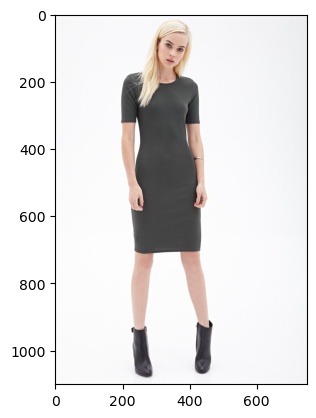

In [3]:
from matplotlib import pyplot as plt

# 读取词典和验证集
with open('../data/deepfashion_multimodal/output/vocab.json', 'r') as f:
    vocab = json.load(f)
vocab_idx2word = {idx:word for word, idx in vocab.items()}

with open('../data/deepfashion_multimodal/output/val_data.json', 'r') as f:
    data = json.load(f)
    
# 展示第14张图片
test_number_index = 14
content_img = Image.open(data['IMAGES'][test_number_index])
plt.imshow(content_img)

print(' '.join([vocab_idx2word[word_idx] for word_idx in data['CAPTIONS'][test_number_index]]))

# 统计最长的caption长度，以及平均长度
max_length = 0
avg_length = 0
for item in data['CAPTIONS']:
    leng = len(item)
    avg_length += leng
    if leng > max_length:
        max_length = leng
        
print(f"The max length of captions is {max_length}. The avg length is {avg_length / len(data['CAPTIONS'])}")

下面我们开始组织训练数据集，使用`torch`中的`dataset`来自定义我们的数据集，便于后续训练使用Dataloader

In [4]:
from torch.utils.data import Dataset
import torchvision.transforms as transforms

class DeepfashionDataset(Dataset):
    def __init__(self, 
                 dataset_path: str, 
                 vocab_path: str, 
                 dataset_type: str = 'train', 
                 max_len=80, 
                 transform=None):
        """
        @param:
            dataset_path：json格式数据文件路径(全路径)
            vocab_path：json格式词典文件路径
            split：train、val、test
            captions_per_image：每张图片对应的文本描述数
            max_len：文本描述包含的最大单词数
            transform: 图像预处理方法
        """
        self.dataset_type = dataset_type
        assert self.dataset_type in {'train', 'val', 'test'}
        
        with open(dataset_path, 'r') as f:
            self.data: Dict[str, List[str]] = json.load(f)
        with open(vocab_path, 'r') as f:
            self.vocab: Dict[str, int] = json.load(f)
            
        self.max_len = max_len
        self.transform = transform
        self.dataset_size = len(self.data['CAPTIONS'])
        
    def __getitem__(self, index) -> Tuple[Image.Image, torch.Tensor, int]:
        img = Image.open(self.data['IMAGES'][index]).convert('RGB')
        if self.transform is not None:
            img = self.transform(img)
            
        caplen = len(self.data['CAPTIONS'][index])
        if caplen > self.max_len:
            caption = torch.LongTensor(self.data['CAPTIONS'][index][:self.max_len])
            caplen = self.max_len
        else:
            caption = torch.LongTensor(self.data['CAPTIONS'][index] + [self.vocab['<pad>']] * (self.max_len - caplen))
            
        return img, caption, caplen # although the img here is PIL image, it will be converted to tensor in the dataloader
    
    def __len__(self) -> int:
        return self.dataset_size

/opt/conda/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


构建Dataloader

In [5]:
def make_dataloader(data_dir, vocab_path, batch_size, workers=4) -> tuple:
    train_tx = transforms.Compose([
        transforms.Resize(256),
        transforms.RandomCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
    
    val_tx = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
    
    train_set = DeepfashionDataset(os.path.join(data_dir, 'train_data.json'), 
                                 vocab_path, 'train',  transform=train_tx)
    valid_set = DeepfashionDataset(os.path.join(data_dir, 'val_data.json'), 
                                 vocab_path, 'val', transform=val_tx)
    test_set = DeepfashionDataset(os.path.join(data_dir, 'test_data.json'), 
                                 vocab_path, 'test', transform=val_tx)

    train_loader = torch.utils.data.DataLoader(
        train_set, batch_size=batch_size, shuffle=True, num_workers=workers, pin_memory=True)

    valid_loader = torch.utils.data.DataLoader(
        valid_set, batch_size=batch_size, shuffle=False, num_workers=workers, pin_memory=True, drop_last=False)
    
    test_loader = torch.utils.data.DataLoader(
        test_set, batch_size=batch_size, shuffle=False, num_workers=workers, pin_memory=True, drop_last=False)

    return train_loader, valid_loader, test_loader    

### 定义模型
小组计划完成两条路线的模型框架实现：
+ CNN + GRU实现基本的图像生成编解码框架
+ 网格划分表示 + transformer编码器 + 解码器


#### 1. Implement: CNN + GRU

TODO: finish this part

#### 2. Implement: Region Recognition + Transformer Encoder 2 Decoder

在此处实现 `区域划分 + Transformer Encoder + Decoder`的思路

在这里需要注意的是，“网格” 和 “区域” 并不是同一个意思。

<center> 
    <img src="./jupyter_images/grid_expr.png" height="200">
    <img src="./jupyter_images/region_expr.png" height="200">
    <div>
        左图为网格表示，右图为区域表示
    </div>
</center>

为了更加精准地描述图像，我们选择“区域”描述 + Transformer Encoder与Decoder的路线。

+ 区域描述：使用Resnet做卷积，提取区域特征，卷积层的最后一层输出就是提取的特征
+ Transformer Encoder
+ Transformer Decoder

##### Step 2.1 搭建Image Region Encoder

我们首先来做Resnet的卷积提取特征的工作。在这里我们选用resnet50作为卷积网络即可。

In [6]:
import torchvision.models as models
from torchvision.models import ResNet50_Weights

class ImageRegionEncoder(torch.nn.Module):
    def __init__(self, frozen=False):
        super(ImageRegionEncoder, self).__init__()
        resnet = models.resnet50(weights=ResNet50_Weights.DEFAULT)
        modules = list(resnet.children())[:-2]      # delete the last fc layer
        
        self.resnet = torch.nn.Sequential(*modules)
        
        if frozen:
            for p in self.resnet.parameters():
                p.requires_grad = frozen
        
    def forward(self, images):
        features = self.resnet(images)
        return features

从上面的`ImageRegionEncoder`的输出中，因为**移除了最后一个全连接层**， 我们得到的是一个特征图feature map，而不是用于分类的具体特征向量。这个特征图包含了图像的空间特征信息。

有关feature map：输出的形状是一个四维的tensor，具体来说是`[batch_size, Channel, Height, Width]`,
+ batch_size: 每份batch的图像数量
+ channel: 对于resnet50，如果仅仅移除了最后一个全连接层，应该是2048
+ Height, Width: 由图像原尺寸和神经网络架构决定

    + **特征图中的每个元素都是图像某个区域的高维特征表示**。这些特征被用来捕获图像中的重要信息（如边缘、纹理、颜色等）。

在此我们首先对图像的feature_map形状进行查看

In [7]:
model = ImageRegionEncoder(frozen=True).to(device)
model.eval()

train_loader_tmp, _, _ = make_dataloader(data_dir='../data/deepfashion_multimodal/output',
                                        vocab_path='../data/deepfashion_multimodal/output/vocab.json',
                                        batch_size=1)

# Select 8 images from the train_loader
images = []
for i, (image, _, _) in enumerate(train_loader_tmp):
    images.append(image)
    if i == 7:
        break

# Convert the list of images to a tensor
images = torch.cat(images, dim=0)

# Pass the images through the ImageRegionEncoder
features = model(images.to(device))

mid_channels = features.shape[1]
mid_height = features.shape[2]
mid_width = features.shape[3]


在构建 Transformer 编码器之前，有几个关键点需要注意：

1. 特征尺寸调整：Transformer 编码器通常接收一维的序列输入。因此，您可能需要将从 ImageRegionEncoder 得到的二维特征（即卷积特征图）转换为一维序列。这通常通过展平特征图的每个区域或者使用全局平均池化来实现。

2. 位置编码：由于 Transformer 编码器本身不处理序列的顺序信息，因此通常需要加入位置编码（Positional Encoding）以提供位置信息。

##### Step 2.2 对输出的`feature_map`进行处理

In [8]:
import numpy as np

def flatten_feature_map(feature_map: torch.Tensor) -> torch.Tensor:
    batch_size, channels, height, width = feature_map.size()
    feature_map = feature_map.permute(0, 2, 3, 1)  # 将通道移动到最后
    feature_map = feature_map.reshape(batch_size, height * width, channels)
    return feature_map

def positional_encoding(seq_len=mid_height*mid_width, d_model=mid_channels) -> torch.Tensor:
    pos_enc = np.array([
        [pos / np.power(10000, 2 * (j // 2) / d_model) for j in range(d_model)] 
        if pos != 0 else np.zeros(d_model) 
        for pos in range(seq_len)
    ])
    pos_enc[1:, 0::2] = np.sin(pos_enc[1:, 0::2])  # dim 2i
    pos_enc[1:, 1::2] = np.cos(pos_enc[1:, 1::2])  # dim 2i+1
    return torch.from_numpy(pos_enc).type(torch.FloatTensor)

##### Step 2.3 搭建Transformer Encoder


In [9]:
from torch.nn import TransformerEncoder, TransformerEncoderLayer
import torch.nn as nn

class ImageTransEncoder(nn.Module):
    def __init__(self, feature_size, num_layers, nhead):
        super(ImageTransEncoder, self).__init__()
        self.model_type = 'Transformer'
        
        # 编码器层
        encoder_layers = TransformerEncoderLayer(feature_size, nhead)
        self.transformer_encoder = TransformerEncoder(encoder_layers, num_layers)
        self.init_weights()
        
    def init_weights(self):
        initrange = 0.1
        for param in self.parameters():
            param.data.uniform_(-initrange, initrange)

    def forward(self, src, src_mask=None):
        src = src.transpose(0, 1)  # 将batch_size放在第二维
        output = self.transformer_encoder(src, src_mask)
        return output

在经过Transformer Encoder之后，这些输出特征的形状还是`[batch_size, 49, 2048]`，但是此时的output不仅包含了原始图像特征的信息，还融入了序列中不同元素之间的关系，这是通过Encoder中的自注意力机制实现的。

接下来我们可以开始搭建Transformer Decoder

##### Step 2.4 搭建Transformer Decoder

+ Decoder 的任务：Decoder的主要任务是基于Encoder的输出特征生成文本描述。它通常需要两个输入：一是Encoder的输出特征，二是目前为止已生成的文本序列（在训练时，这通常是真实文本序列的一部分；在推断时，这是之前Decoder步骤生成的文本序列）。

+ Decoder 结构：Transformer Decoder也是由多个相同的层堆叠而成，每层包含自注意力机制、交叉注意力机制（用来关注Encoder的输出）和前馈神经网络。

+ 注意力掩码：在Decoder中，通常需要使用注意力掩码（Attention Mask）来避免在生成某个单词时“看到”未来的单词。这对于训练和生成文本序列尤为重要。

In [10]:
from torch.nn import TransformerDecoder, TransformerDecoderLayer

class ImageTransDecoder(nn.Module):
    def __init__(self, feature_size, num_layers, nhead, vocab_size):
        super(ImageTransDecoder, self).__init__()
        self.embedding = nn.Embedding(vocab_size, feature_size) # convert each word to a vector
        
        decoder_layer = TransformerDecoderLayer(d_model=feature_size, nhead=nhead)
        self.transformer_decoder = TransformerDecoder(decoder_layer, num_layers)
        
        self.fc_out = nn.Linear(feature_size, vocab_size)
        
        self.init_weights()
        
    def init_weights(self):
        initrange = 0.1
        for param in self.parameters():
            param.data.uniform_(-initrange, initrange)

    def forward(self, trg, encode_features, trg_mask):
        trg = self.embedding(trg)
        
        target = trg.transpose(0, 1)  # 转换为 [sequence_length, batch_size, features]
        
        output = self.transformer_decoder(target, encode_features, trg_mask)
        output = self.fc_out(output)
        return output

##### Step 2.5 组建整体模型

In [11]:
import time

class ImageRegionE2D(nn.Module):
    def __init__(self, num_layers, nhead, *args, **kwargs) -> None:
        super().__init__(*args, **kwargs)
        self.num_layers = num_layers
        self.nhead = nhead
        self.image_region_encoder = ImageRegionEncoder(frozen=False)
        self.image_trans_encoder = ImageTransEncoder(mid_channels, num_layers=num_layers, nhead=nhead)
        self.image_trans_decoder = ImageTransDecoder(mid_channels, num_layers=num_layers, nhead=nhead, vocab_size=len(vocab))
        
    def generate_square_subsequent_mask(self, size):
        mask = torch.triu(torch.ones(size, size) * float('-inf'), diagonal=1)
        return mask
        
    def forward(self, 
                images: torch.Tensor, 
                captions: torch.Tensor=None):
        # Assume the images have been transformed and moved to the device
        # and the captions have been padded and moved to the device
        
        # step 1: Image Encoder to get the Region
        features = self.image_region_encoder(images)    # shape: [batch_size, 2048, 7, 7]
        features = flatten_feature_map(features)
        
        pos_enc = positional_encoding(seq_len=mid_height*mid_width, d_model=mid_channels).to(device)
        features = features + pos_enc
        
        # Step 2: Transformer Encoder
        # features shape: [batch_size, 49, 2048]
        features = self.image_trans_encoder(features)
        
        # Step 3: Transformer Decoder
        s_size = captions.size(1)
        trg_mask = self.generate_square_subsequent_mask(s_size).to(device)
        outputs = self.image_trans_decoder(captions, features, trg_mask)
        
        # Step 4: Output Transpose to [batch_size, seq_len, vocab_size]
        outputs = outputs.transpose(0, 1)
        return outputs

下面开始组织训练框架，需要注意的是，反向传播与误差计算，与模型评估是两个过程。

**反向传播**
+ 损失函数：在训练神经网络时，反向传播的依据是损失函数。对于文本生成任务，常用的损失函数是交叉熵损失（Cross-Entropy Loss）。交叉熵损失衡量的是模型预测的概率分布与真实标签的概率分布之间的差异。

+ 反向传播过程：在每次训练迭代中，您会先进行前向传播来计算损失函数，然后进行反向传播来计算梯度，并更新模型的权重。这个过程是基于损失函数的计算结果进行的。

**模型性能评估**
+ 评估指标：BLEU、ROUGE 等指标用于评估模型的性能，特别是在文本生成任务中。这些指标衡量的是模型生成的文本与参考文本（通常是人类编写的标准答案）之间的相似度。

+ 评估时机：通常，在训练过程中（例如每个 epoch 后）或训练完成后，您会使用这些指标来评估模型。这些评估指标不用于训练模型（即不用于反向传播），而是用来理解模型的性能，特别是模型在生成文本方面的质量。

In [12]:
from rouge_score import rouge_scorer
from tqdm import tqdm

def convert_idx_to_text(outputs: torch.Tensor) -> str:
    seq_len = outputs.size(0)
    batch_size = outputs.size(1)
    vocab_size = outputs.size(2)
    _, predicted_indices = torch.max(outputs, dim=2)
    
    generated_texts = []
    for i in range(batch_size):
        words = [vocab_idx2word[idx.item()] for idx in predicted_indices[:, i]]
        for word in words:
            # 如果遇到 <pad> 或者 <unk> 或者 <start>，<end>则不添加到生成的文本中
            if word in ['<pad>', '<unk>', '<start>', '<end>']:
                words.remove(word)
        sentence = ' '.join(words)
        generated_texts.append(sentence)

    return generated_texts


def convert_capt_to_text(captions: torch.Tensor) -> str:
    real_texts = []
    for caption in captions:
        words = [vocab_idx2word[idx.item()] for idx in caption]
        for idx, word in enumerate(words):
            # 如果遇到 <pad> 或者 <unk> 或者 <start>，<end>则不添加到生成的文本中
            if word in ['<unk>', '<start>', '<end>']:
                words.remove(word)
            elif word == '<pad>':
                words = words[:idx-1]
                break
        sentence = ' '.join(words)
        real_texts.append(sentence)
    return real_texts


def try_forward():
    model = ImageRegionE2D(num_layers=2, nhead=4).to(device)
    model.train()
    train_loader, valid_loader, test_loader = make_dataloader(data_dir='../data/deepfashion_multimodal/output',
                                                            vocab_path='../data/deepfashion_multimodal/output/vocab.json',
                                                            batch_size=2)
    # Select 8 images from the train_loader
    images = []
    captions = []
    for i, (image, caption, _) in enumerate(train_loader):
        images.append(image)
        captions.append(caption)
        if i == 7:
            break
        
    # Convert the list of images to a tensor
    images = torch.cat(images, dim=0)
    captions = torch.cat(captions, dim=0)

    outputs = model(images.to(device), captions.to(device))
    generated_texts: List[str] = convert_idx_to_text(outputs)
    real_texts = convert_capt_to_text(captions)
        
    print(f"Generated Text: {generated_texts}")
    print(f"Real Text: {real_texts}")
    return outputs

        
# outputs_tmp = try_forward()


下面开始进行模型训练

In [13]:
import time

def analyze_model_output(outputs):
    # 假设 outputs 形状为 [seq_len, batch_size, vocab_size]
    # 应用 softmax 获取概率分布
    probabilities = torch.softmax(outputs, dim=-1)

    # 遍历每个时间步
    for t in range(probabilities.size(0)):
        # 获取当前时间步的概率分布
        timestep_probs = probabilities[t]

        # 计算每个单词的平均概率
        average_probs = timestep_probs.mean(dim=0)
        print(average_probs.shape)
        # 打印当前时间步的信息
        print(f"Time Step {t}:")
        for idx, prob in enumerate(average_probs):
            print(f"Word Index {idx} - Probability: {prob.item()}")
        print("\n")


def train_logic_epoch(model, criterion, optimizer, train_loader, epoch):
    model.train()
    pbar = tqdm(enumerate(train_loader), total=len(train_loader))
    for i, (images, captions, _) in pbar:
        images = images.to(device)
        captions = captions.to(device)  # shape: [16, 80]   not transposed
        
        outputs = model(images, captions)   # forward
        
        # ========= NOTICE: the caption and output shape will be changed here =========
        captions = captions.view(-1)
        outputs = outputs.reshape(-1, outputs.size(-1))
        
        loss = criterion(outputs, captions)
        
        optimizer.zero_grad()
        loss.backward()
        
        optimizer.step()
        
        pbar.set_description(f"Epoch {epoch} - Loss: {loss.item():.4f}")


def validate_logic_epoch(model, valid_loader):
    model.eval()  # 设置模型为评估模式
    total_rouge_l = 0

    pbar = tqdm(enumerate(valid_loader), total=len(valid_loader))
    with torch.no_grad():
        for i, (images, captions, _) in pbar:
            pbar.set_description(f"Validating")
            images = images.to(device)
            captions = captions.to(device)  # shape: [16, 80]   not transposed

            # 使用模型生成描述
            outputs = model(images, captions)
            
            
            # ... 这里需要添加从模型输出到文本描述的转换逻辑
            generated_texts: List[str] = convert_idx_to_text(outputs)
            real_texts = convert_capt_to_text(captions)
            
            print(f"Generated Text: {generated_texts}")
            print(f"Real Text: {real_texts}")
            
            # 计算 ROUGE-L 分数
            # 假设 generated_texts 是模型生成的文本，real_texts 是真实文本
            scorer = rouge_scorer.RougeScorer(['rougeL'], use_stemmer=True)
            for gen_text, real_text in zip(generated_texts, real_texts):
                scores = scorer.score(real_text, gen_text)
                total_rouge_l += scores['rougeL'].fmeasure

    # 计算平均 ROUGE-L 分数
    avg_rouge_l = total_rouge_l / len(valid_loader.dataset)
    print(f"Average ROUGE-L Score: {avg_rouge_l}")
    return avg_rouge_l



def train(model, num_epochs, criterion, optimizer, train_loader, valid_loader):
    model.to(device)
    avg_rouge_score_l_max = 0
    checkpoint_path = '../data/deepfashion_multimodal/output/models/'
    if not os.path.exists(checkpoint_path):
        os.mkdir(checkpoint_path)
        
    for epoch in range(num_epochs):
        # ===== train logic =====
        train_logic_epoch(model, criterion, optimizer, train_loader, epoch)

        # ===== valid logic =====
        avg_rouge_score_l = validate_logic_epoch(model, valid_loader)
        
        # save the state dict if performance is improved
        if avg_rouge_score_l > avg_rouge_score_l_max:
            avg_rouge_score_l_max = avg_rouge_score_l
            torch.save(model.state_dict(), os.path.join(checkpoint_path, f"model_epoch_{epoch}_layer_{model.num_layers}.pth"))

train caption shape: torch.Size([16, 80])

train image shape: torch.Size([16, 3, 224, 224])

valid caption shape: torch.Size([16, 80])

valid image shape: torch.Size([16, 3, 224, 224])

train output shape: torch.Size([80, 16, 119])

valid output shape: torch.Size([80, 16, 119])

lr: 0.001 the the the the the the the the the the the the the the the the

lr: 0.0001 

lr: 0.00005

In [14]:
def warm_up():
    outputs = try_forward()
    print(f"output shape: {outputs.shape}")
    
def train_trans_model(num_layers=2, nhead=4):
    num_epochs = 20
    model = ImageRegionE2D(num_layers=num_layers, nhead=nhead)
    criterion = nn.CrossEntropyLoss(ignore_index=vocab['<pad>'])
    optimizer = torch.optim.Adam(model.parameters(), lr=0.00005)
    train_loader, valid_loader, _ = make_dataloader(data_dir='../data/deepfashion_multimodal/output',
                                                    vocab_path='../data/deepfashion_multimodal/output/vocab.json',
                                                    batch_size=16)
    train(model, num_epochs, criterion, optimizer, train_loader, valid_loader)


# train the model with different layer and head count
layer_count = [2, 4]
head_count = [4, 8]
    
warm_up()
for layer, head in zip(layer_count, head_count):
    print(f"============ training: layer: {layer}, head: {head} ============")
    # train
    train_trans_model(layer, head)


/opt/conda/lib/python3.11/site-packages/torch/nn/modules/transformer.py:282: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


Generated Text: ['finger finger finger finger color finger finger color color finger finger finger finger color finger finger', 'finger finger person finger finger finger finger finger finger finger finger finger color person finger finger', 'finger color finger color color finger finger finger finger finger finger finger color color finger finger', 'finger finger finger finger finger color finger finger finger finger finger color finger finger finger finger', 'finger finger finger finger finger finger finger finger finger person finger color finger finger color finger', 'finger finger finger finger color finger color finger finger finger finger finger finger color finger finger', 'color finger color finger finger finger finger finger finger finger finger finger finger color finger color', 'finger finger finger color finger finger finger finger finger color finger color color finger finger color', 'finger finger color finger finger finger finger finger color color person color finger f

Validating:   1%|          | 1/127 [00:00<01:06,  1.89it/s]

Generated Text: ['<start> <start> <start> <start> <start> <start> <start> <start>', 'this this the her her the the the sleeves, the the the this her this this', 'person person person her shirt clothing tank tank sleeves, female lady clothing person shirt female person', 'wears is is has has clothing top top has wears is clothing wears has wears wears', 'a wearing wearing long sleeves, has the this long a wearing has a long a a', 'long-sleeve a a sleeves, sleeves, sleeves, person female sleeves, long-sleeve a long long-sleeve sleeves, long-sleeve long-sleeve', 'shirt tank tank cotton cotton sleeves, wears wears cotton shirt long-sleeve sleeves, shirt long top tank', 'with tank tank fabric fabric sleeves, has has fabric with sweater long with fabric with top', 'graphic shirt top and and sleeves, top sleeves and pure with fabric pure and pure with', 'patterns with with solid color fabric top top solid color graphic and color it color solid', 'the solid pure color sleeves, and its its colo

Validating:   2%|▏         | 2/127 [00:00<00:45,  2.75it/s]

Generated Text: ['<start> <start> <start> <start> <start> <start> <start> <start>', 'the the the the the this the the this this this this her this the the', 'person person female person clothing person clothing shirt person female person female shirt person shirt lady', 'wears is is is clothing wears clothing the is is wears wears has is this is', 'a wearing wearing wearing has a has person wearing wearing a a long wearing person wearing', 'long-sleeve a a a sleeves, long-sleeve sleeves, wears a a tank long-sleeve sleeves, a wears a', 'sweater long-sleeve tank long-sleeve sleeves, sweater sleeves, has tank long-sleeve tank shirt long long-sleeve has long-sleeve', 'with tank tank sweater sleeves, with sleeves, long tank shirt top with fabric shirt sleeves, shirt', 'solid shirt top with cotton graphic cotton sleeves, top with with pure and with sleeves, with', 'color with with pure fabric patterns fabric and with sweater top color sleeves, solid and graphic', 'patterns pure pure color an

Validating:   2%|▏         | 3/127 [00:01<00:38,  3.25it/s]

Generated Text: ['<start> <start> <start> <start> <start> <start> <start> <start>', 'this this the this this the this this the the this her the the sleeves, the', 'female female person person lady shirt female person lady shirt person shirt person lady shirt female', 'is wears is wears wears the is wears is the is has is is has is', 'wearing a wearing a a female wearing a wearing person wearing long wearing wearing sleeves, wearing', 'a long-sleeve a long-sleeve long-sleeve wears a long-sleeve a wears a sleeves, a a sleeves, a', 'long-sleeve shirt long-sleeve shirt sweater has long-sleeve shirt long-sleeve has long-sleeve cotton long-sleeve tank cotton long-sleeve', 'shirt with tank with with long shirt with sweater sleeves, shirt fabric shirt tank fabric top', 'with solid shirt pure graphic sleeves, with pure with sleeves, with and with shirt and with', 'graphic color with color patterns and solid color sweater and graphic solid solid with it graphic', 'patterns patterns top patterns 

Validating:   3%|▎         | 4/127 [00:01<00:34,  3.57it/s]

Generated Text: ['<start> <start> <start> <start> <start> <start> <start> <start>', 'the the the this her this her the her this this the the the the the', 'sleeves, lady clothing female her person tank person tank female female female lady person lady shirt', 'the wears clothing is has is shirt is shirt wears is is wears wears wears the', 'lady a has wearing long wearing has wearing has a wearing wearing a a a lady', 'wears long-sleeve long a sleeves, a sleeves, a sleeves, long-sleeve a a long-sleeve long-sleeve long-sleeve wears', 'has shirt sleeves, long-sleeve cotton tank sleeves, long-sleeve sleeves, shirt long-sleeve tank shirt sweater tank has', 'long with long sweater fabric tank cotton tank cotton with tank tank with with shirt sleeves,', 'sleeves, graphic fabric with and shirt fabric shirt fabric pure top top solid pure with sleeves,', 'its patterns and solid solid with and with and color with with color color pure its', 'fabric and has color color solid pure solid sleeves, pa

Validating:   4%|▍         | 5/127 [00:01<00:32,  3.76it/s]

Generated Text: ['<start> <start> <start> <start> <start> <start> <start> <start>', 'the the the the the sleeves, the the the the her the the this the this', 'tank shirt clothing female shirt sleeves, shirt lady clothing person tank person shirt female person female', 'shirt this clothing wears this has the wears clothing is top wears the is wears is', 'this person has a lady sleeves, person a has wearing has a female wearing a wearing', 'female wears long long-sleeve wears sleeves, wears long-sleeve sleeves, a sleeves, long-sleeve wears a long-sleeve a', 'wears has sleeves, tank has cotton has tank sleeves, long-sleeve sleeves, sweater has long-sleeve shirt long-sleeve', 'has sleeves, cotton top long fabric sleeves, shirt cotton shirt cotton with long shirt with shirt', 'top sleeves, fabric with sleeves, and sleeves, with fabric with fabric solid sleeves, with pure with', 'top sleeves, and graphic and it and pure and pure and color and solid color graphic', 'long fabric solid patterns

Validating:   5%|▍         | 6/127 [00:01<00:32,  3.78it/s]

Generated Text: ['<start> <start> <start> <start> <start> <start> <start> <start>', 'her this this this the the this the the the this the her the the this', 'tank female female person female person lady sleeves, lady tank lady clothing her clothing person female', 'top is is wears wears is wears the wears shirt is clothing has clothing is wears', 'has wearing wearing a a wearing a female a the wearing has long has wearing a', 'sleeves, a a long-sleeve long-sleeve a long-sleeve wears long-sleeve person a sleeves, sleeves, sleeves, a top', 'sleeves, tank long-sleeve shirt tank long-sleeve shirt has shirt wears tank sleeves, cotton sleeves, long-sleeve tank', 'cotton tank sweater with top top with long with has tank cotton fabric sleeves, top top', 'fabric shirt with pure with with its sleeves, solid top shirt fabric and cotton with with', 'and with pure color top pure patterns its color top with and color fabric solid solid', 'sleeves, pure color patterns patterns color and fabric patter

Validating:   6%|▌         | 7/127 [00:02<00:31,  3.81it/s]

Generated Text: ['<start> <start> <start> <start> <start> <start> <start> <start>', 'this this her this this this the this this this the this this the her the', 'female person tank person female female lady person lady lady shirt female female lady tank female', 'wears is top is is wears wears wears is is the is is wears top is', 'a wearing has wearing wearing a a a wearing wearing lady wearing wearing a has wearing', 'long-sleeve a sleeves, a a top long-sleeve long-sleeve a a wears a a tank sleeves, a', 'sweater long-sleeve sleeves, long-sleeve long-sleeve tank sweater sweater long-sleeve long-sleeve has top tank tank sleeves, long-sleeve', 'with sweater sleeves, tank sweater shirt with with shirt sweater sleeves, tank tank top sleeves, shirt', 'solid with cotton top with with pure graphic with with sleeves, shirt tank with sleeves, with', 'color graphic fabric with sweater solid color patterns its sweater and with with solid fabric solid', 'patterns patterns and pure patterns color p

Validating:   6%|▋         | 8/127 [00:02<00:30,  3.90it/s]

Generated Text: ['<start> <start> <start> <start> <start> <start> <start> <start>', 'the the her the this this this this her this this this the her the the', 'person clothing shirt female female female female female sleeves, lady female female tank shirt lady lady', 'is clothing has wears is wears wears wears has is is is shirt has is is', 'wearing has sleeves, a wearing a a a sleeves, wearing wearing wearing this sleeves, wearing wearing', 'a long sleeves, long-sleeve a long-sleeve long-sleeve long-sleeve sleeves, a a a lady sleeves, a a', 'long-sleeve sleeves, cotton top long-sleeve shirt sweater sweater cotton long-sleeve long-sleeve long-sleeve wears cotton tank long-sleeve', 'shirt cotton fabric with tank with with with fabric sweater shirt tank has fabric tank shirt', 'with fabric and solid shirt pure graphic pure and with with shirt sleeves and shirt with', 'pure and it color with color patterns color color pure solid with sleeves, pure with color', 'color solid patterns pattern

Validating:   7%|▋         | 9/127 [00:02<00:29,  4.03it/s]

Generated Text: ['<start> <start> <start> <start> <start> <start> <start> <start>', 'her the the this this her the the sleeves, the the the her sleeves, the this', 'shirt lady sleeves, lady female shirt lady shirt shirt tank tank clothing tank shirt female person', 'has is this is wears has is this has shirt shirt clothing top has is is', 'sleeves, wearing person wearing a sleeves, wearing person sleeves, the the has has long wearing wearing', 'sleeves, a wears a tank sleeves, a wears sleeves, female female sleeves, sleeves, sleeves, a a', 'cotton long-sleeve has long-sleeve tank sleeves, long-sleeve has cotton wears wears sleeves, sleeves, cotton long-sleeve tank', 'fabric tank long shirt top fabric shirt long fabric has has sleeves, sleeves, fabric sweater tank', 'and top sleeves, with with and with sleeves, and top top fabric cotton and with top', 'solid with and pure solid sleeves, pure and pure top top and fabric it graphic with', 'color pure its color color patterns color its col

Validating:   8%|▊         | 10/127 [00:02<00:28,  4.10it/s]

Generated Text: ['<start> <start> <start> <start> <start> <start> <start> <start>', 'this the the the this the the the the the her the the the the her', 'female clothing lady female female shirt tank sleeves, person clothing tank female clothing female tank tank', 'wears clothing wears is wears the shirt the is clothing shirt wears clothing is shirt shirt', 'a has a wearing a female this female wearing has has a has wearing this has', 'long-sleeve sleeves, long-sleeve a tank wears person wears a long sleeves, long-sleeve sleeves, a person sleeves,', 'shirt sleeves, top long-sleeve tank has wears has long-sleeve sleeves, sleeves, sweater sleeves, tank wears sleeves,', 'with cotton with sweater tank sleeves has long shirt cotton cotton with cotton tank has sleeves,', 'pure fabric pure with with its top sweater with fabric fabric pure fabric tank top cotton', 'color and color sweater top and top and pure and and color and with top fabric', 'patterns sleeves, patterns patterns patterns it 

Validating:   9%|▊         | 11/127 [00:02<00:28,  4.05it/s]

Generated Text: ['<start> <start> <start> <start> <start> <start> <start> <start>', 'the her this the the this the the this the the this the the the this', 'lady tank female clothing clothing female person shirt female clothing female lady sleeves, sleeves, person person', 'wears shirt is clothing clothing wears is this wears clothing is is the this wears is', 'a has wearing has has a wearing female a has wearing wearing female person a wearing', 'long-sleeve sleeves, a long sleeves, long-sleeve a wears long-sleeve sleeves, a a wears wears long-sleeve a', 'shirt sleeves, long-sleeve sleeves, sleeves, shirt long-sleeve has shirt sleeves, long-sleeve long-sleeve has has sweater long-sleeve', 'with sleeves, sweater cotton sleeves, with shirt long with cotton tank sweater long long with sweater', 'graphic cotton with fabric cotton graphic with sleeves, its fabric shirt with its sleeves, pure with', 'patterns fabric solid and fabric patterns solid its patterns and with graphic and its color

Validating:   9%|▉         | 12/127 [00:03<00:28,  4.09it/s]

Generated Text: ['<start> <start> <start> <start> <start> <start> <start> <start>', 'this this this this the her this the this the her the the the the her', 'female person female person person tank lady tank female tank shirt person shirt clothing female shirt', 'wears wears is wears is shirt wears shirt wears shirt has wears this clothing is has', 'a a wearing a wearing has a the a this long a person has wearing long', 'long-sleeve long-sleeve a tank a sleeves, tank female long-sleeve female sleeves, long-sleeve wears long a sleeves,', 'tank shirt tank tank long-sleeve sleeves, tank wears shirt wears long tank has sleeves, tank cotton', 'shirt with tank shirt sweater sleeves, shirt has with has fabric top sleeves, cotton tank fabric', 'with pure top with with cotton with top graphic sleeves and with sleeves, fabric top and', 'top color with pure sweater fabric graphic top patterns its long graphic sleeves, and with solid', 'patterns patterns pure color patterns and patterns long the a

Validating:  10%|█         | 13/127 [00:03<00:28,  4.01it/s]

Generated Text: ['<start> <start> <start> <start> <start> <start> <start> <start>', 'this this the her this this the her the the the her this this the this', 'female lady lady shirt person female clothing tank female clothing lady shirt person female tank female', 'wears wears is has is is clothing shirt is clothing is has is is top wears', 'a a wearing sleeves, wearing wearing has has wearing has wearing long wearing wearing the a', 'long-sleeve long-sleeve a sleeves, a a long sleeves, a sleeves, a sleeves, a a lady tank', 'top shirt long-sleeve cotton tank long-sleeve sleeves, sleeves, tank sleeves, long-sleeve cotton tank top wears tank', 'with with shirt fabric tank shirt cotton sleeves, tank cotton shirt fabric tank tank has top', 'graphic solid with and top with fabric sleeves, tank fabric with and shirt top top with', 'patterns color solid it with graphic and fabric with and graphic solid with with top graphic', 'and patterns color patterns top patterns pure and graphic solid pa

Validating:  11%|█         | 14/127 [00:03<00:28,  3.99it/s]

Generated Text: ['<start> <start> <start> <start> <start> <start> <start> <start>', 'this the the her her this the the the her the her this the this the', 'female person clothing her her lady person lady female shirt female tank person tank female top', 'wears wears clothing has has wears wears wears is has is shirt is shirt wears this', 'a a has long long a a a wearing sleeves, wearing has wearing this a lady', 'long-sleeve long-sleeve sleeves, sleeves, sleeves, tank long-sleeve long-sleeve a sleeves, a sleeves, a person long-sleeve wears', 'shirt shirt sleeves, cotton cotton tank shirt sweater long-sleeve cotton long-sleeve sleeves, long-sleeve wears top has', 'with with cotton fabric fabric top with with sweater fabric sweater cotton tank has with sleeves,', 'pure sweater fabric and and with sweater sweater with and with fabric shirt top pure sleeves,', 'color patterns and long pure graphic patterns patterns solid it solid and with top color and', 'patterns and solid patterns color 

Validating:  12%|█▏        | 15/127 [00:03<00:27,  4.02it/s]

Generated Text: ['<start> <start> <start> <start> <start> <start> <start> <start>', 'the this the this the her the this her this this the the her the the', 'clothing female shirt person shirt her lady female shirt female person lady clothing shirt tank clothing', 'clothing wears this wears this has is wears has is wears wears clothing has top clothing', 'has a person a female long wearing a long wearing a a has long the has', 'long long-sleeve wears long-sleeve wears sleeves, a tank sleeves, a tank long-sleeve long sleeves, lady sleeves,', 'sleeves, shirt has sweater has cotton long-sleeve tank cotton top tank top sleeves, cotton wears sleeves,', 'cotton with long with sleeves fabric top tank fabric tank shirt with cotton fabric has sleeves,', 'fabric its sleeves, graphic its and with with and shirt with graphic fabric and top cotton', 'and patterns sleeves, patterns and solid graphic top sleeves, with pure patterns and it top fabric', 'solid and fabric and its color patterns patterns 

Validating:  13%|█▎        | 16/127 [00:04<00:26,  4.13it/s]

Generated Text: ['<start> <start> <start> <start> <start> <start> <start> <start>', 'the her this the this this the her the the the this this the this her', 'tank tank lady lady lady female clothing tank female clothing female female person lady female her', 'shirt shirt wears wears wears wears clothing shirt is clothing is wears is is wears has', 'this has a a a a has has wearing has wearing a wearing wearing a long', 'female sleeves, long-sleeve long-sleeve long-sleeve long-sleeve sleeves, sleeves, a sleeves, a long-sleeve a a long-sleeve sleeves,', 'wears sleeves, shirt sweater tank tank sleeves, sleeves, long-sleeve sleeves, tank shirt long-sleeve long-sleeve sweater cotton', 'has cotton with with shirt shirt cotton cotton shirt cotton tank with tank tank with fabric', 'sleeves fabric solid solid with with fabric fabric with fabric top solid shirt top pure and', 'its and color color pure solid and and pure and with color with with color pure', 'and it patterns patterns color color 

Validating:  13%|█▎        | 17/127 [00:04<00:26,  4.20it/s]

Generated Text: ['<start> <start> <start> <start> <start> <start> <start> <start>', 'this the the the the this the the the the this her sleeves, her the this', 'female tank tank female lady female clothing lady shirt person person shirt shirt her clothing female', 'is shirt shirt is is is clothing is this wears wears has has has clothing is', 'wearing this this wearing wearing wearing has wearing female a a long sleeves, long has wearing', 'a lady lady a a a long a wears long-sleeve tank sleeves, sleeves, sleeves, long a', 'tank wears wears tank long-sleeve tank sleeves, long-sleeve has tank tank cotton cotton cotton sleeves, long-sleeve', 'tank has has tank top tank cotton tank long shirt shirt fabric fabric fabric long top', 'shirt top sleeves tank with top fabric shirt sleeves, with with and and and fabric with', 'with top sleeves, with graphic with and with and graphic solid solid pure solid and graphic', 'solid long and graphic patterns pure pure pure has patterns color color colo

Validating:  14%|█▍        | 18/127 [00:04<00:25,  4.28it/s]

Generated Text: ['<start> <start> <start> <start> <start> <start> <start> <start>', 'the this this the this the this the this this the this the the the her', 'female female lady clothing person clothing lady person person person shirt person lady shirt female tank', 'wears wears wears clothing wears clothing is wears is wears the is is this wears top', 'a a a has a has wearing a wearing a female wearing wearing female a has', 'long-sleeve tank long-sleeve sleeves, long-sleeve sleeves, a tank a long-sleeve wears a a wears long-sleeve sleeves,', 'tank tank shirt sleeves, shirt sleeves, long-sleeve tank long-sleeve sweater has long-sleeve long-sleeve has tank sleeves,', 'shirt tank with sleeves, with cotton tank shirt sweater with sleeves, sweater tank long shirt sleeves,', 'with with pure cotton solid fabric shirt with with graphic sleeves, with top sleeves, with cotton', 'pure solid color fabric color and with graphic graphic patterns its sweater with and graphic fabric', 'color color p

Validating:  15%|█▍        | 19/127 [00:04<00:26,  4.14it/s]

Generated Text: ['<start> <start> <start> <start> <start> <start> <start> <start>', 'this this the the the this her this the the the her this the the this', 'female female lady person shirt female tank person person shirt person shirt female shirt person female', 'is is wears is this is top wears wears this wears has wears this wears wears', 'wearing wearing a wearing female wearing has a a person a sleeves, a female a a', 'a a long-sleeve a wears a sleeves, long-sleeve long-sleeve wears long-sleeve sleeves, long-sleeve wears long-sleeve tank', 'long-sleeve long-sleeve tank tank has long-sleeve sleeves, shirt shirt has shirt cotton shirt has shirt tank', 'tank shirt shirt tank sleeves, sweater cotton with with long with fabric with sleeves, with shirt', 'shirt with with top sleeves, with fabric solid solid sleeves, solid and pure sleeves, solid with', 'with pure pure with its color and color color and color solid color and color solid', 'top color color graphic fabric sweater solid pat

Validating:  16%|█▌        | 20/127 [00:05<00:25,  4.19it/s]

Generated Text: ['<start> <start> <start> <start> <start> <start> <start> <start>', 'her the the the her this the the the the her the the the this her', 'tank female female female shirt female clothing clothing clothing clothing shirt shirt clothing clothing lady shirt', 'top wears wears is has is clothing clothing clothing clothing has the clothing clothing wears has', 'has a a wearing sleeves, wearing has has has has sleeves, lady has has a long', 'sleeves, tank long-sleeve a sleeves, a sleeves, sleeves, long long sleeves, wears sleeves, long tank sleeves,', 'sleeves, tank shirt tank cotton long-sleeve sleeves, sleeves, sleeves, sleeves, cotton has sleeves, sleeves, tank long', 'cotton tank with tank fabric shirt cotton cotton cotton cotton fabric long cotton cotton shirt fabric', 'fabric with sweater tank and with fabric fabric fabric fabric and sleeves, fabric fabric with and', 'and solid patterns with pure pure and and and and pure sleeves, and and graphic solid', 'solid color and

Validating:  17%|█▋        | 21/127 [00:05<00:25,  4.17it/s]

Generated Text: ['<start> <start> <start> <start> <start> <start> <start> <start>', 'this her her the the the this this this this the this this her the the', 'person shirt her female clothing lady female person lady person shirt person person shirt female lady', 'wears has has wears clothing wears is is wears wears this is wears has is wears', 'a long long a has a wearing wearing a a lady wearing a sleeves, wearing a', 'long-sleeve sleeves, sleeves, long-sleeve sleeves, long-sleeve a a long-sleeve long-sleeve wears a long-sleeve sleeves, a long-sleeve', 'shirt cotton cotton tank sleeves, sweater tank long-sleeve shirt shirt has long-sleeve sweater cotton tank top', 'with fabric fabric shirt cotton with tank shirt with with sleeves, shirt with fabric tank with', 'pure and and with fabric graphic top with pure color sleeves, with sweater and tank pure', 'color sleeves, sleeves, pure and patterns with pure color sweater its pure patterns solid with color', 'patterns patterns patterns colo

Validating:  17%|█▋        | 22/127 [00:05<00:24,  4.26it/s]

Generated Text: ['<start> <start> <start> <start> <start> <start> <start> <start>', 'this the the this the this this her this her this her the this the this', 'lady clothing person person lady female female tank person tank person tank person person person female', 'is clothing is wears is is wears shirt is top is top is wears wears is', 'wearing has wearing a wearing wearing a has wearing has wearing has wearing a a wearing', 'a long a long-sleeve a a tank sleeves, a sleeves, a sleeves, a long-sleeve long-sleeve a', 'tank sleeves, long-sleeve tank tank tank tank sleeves, long-sleeve sleeves, long-sleeve sleeves, long-sleeve shirt shirt top', 'tank cotton sweater top tank tank top sleeves, shirt sleeves, tank sleeves, shirt with with tank', 'top fabric with with tank top with cotton with cotton top sleeves, with solid pure top', 'with and pure graphic with with solid fabric solid fabric with fabric solid color color with', 'solid pure color patterns solid graphic color and color and gr

Validating:  18%|█▊        | 23/127 [00:05<00:24,  4.24it/s]

Generated Text: ['<start> <start> <start> <start> <start> <start> <start> <start>', 'this this the the her her this the this this this this the the this this', 'female female person person tank tank female clothing lady female lady female female shirt female female', 'is wears is wears top shirt is clothing wears wears is wears wears the wears wears', 'wearing a wearing a has has wearing has a a wearing a a female a a', 'a long-sleeve a long-sleeve sleeves, sleeves, a long tank long-sleeve a long-sleeve long-sleeve wears long-sleeve long-sleeve', 'long-sleeve sweater long-sleeve shirt sleeves, sleeves, long-sleeve sleeves, tank shirt long-sleeve tank sweater has shirt sweater', 'tank with shirt with sleeves, cotton sweater cotton top with tank top with sleeves with with', 'top color with solid fabric fabric with fabric with pure top with pure its solid graphic', 'with sweater solid color and and solid and pure color with solid color and color patterns', 'graphic patterns color patterns

Validating:  19%|█▉        | 24/127 [00:06<00:24,  4.25it/s]

Generated Text: ['<start> <start> <start> <start> <start> <start> <start> <start>', 'her this the this the the this this the the her her the her the her', 'shirt female female lady lady lady lady person person clothing shirt her person tank shirt shirt', 'has wears wears wears wears wears wears wears wears clothing has has is top this has', 'sleeves, a a a a a a a a has long long wearing has female long', 'sleeves, top long-sleeve long-sleeve tank long-sleeve long-sleeve long-sleeve long-sleeve sleeves, sleeves, sleeves, a sleeves, wears sleeves,', 'cotton tank sweater tank tank shirt shirt shirt top sleeves, cotton sleeves, long-sleeve top has long', 'fabric top with shirt shirt with with with with cotton fabric fabric sweater sleeves, sleeves fabric', 'and with solid with with graphic pure solid solid fabric and and with cotton sleeves, and', 'pure solid color pure its patterns color color color and pure sleeves, sweater fabric its pure', 'color color patterns color patterns the patt

Validating:  20%|█▉        | 25/127 [00:06<00:24,  4.24it/s]

Generated Text: ['<start> <start> <start> <start> <start> <start> <start> <start>', 'this this this this this her sleeves, this the the this the her the her her', 'female person lady female female her sleeves, person person person person lady her tank tank tank', 'is wears wears wears wears has has wears wears is wears wears has shirt top shirt', 'wearing a a a a long long a a wearing a a long the has has', 'a long-sleeve long-sleeve top tank sleeves, sleeves, long-sleeve long-sleeve a long-sleeve tank sleeves, person sleeves, sleeves,', 'tank sweater shirt tank tank cotton cotton sweater tank long-sleeve sweater tank long wears sleeves, sleeves,', 'tank with with top top fabric fabric with top sweater with top fabric has cotton sleeves,', 'top solid graphic with with and and solid with with solid with and top fabric cotton', 'with color patterns pure pure pure solid color solid solid color graphic it top and fabric', 'graphic patterns the color color color color patterns color color p

Validating:  20%|██        | 26/127 [00:06<00:24,  4.16it/s]

Generated Text: ['<start> <start> <start> <start> <start> <start> <start> <start>', 'the this this the this this sleeves, the the this her the the the this the', 'female lady female female lady female sleeves, person female person sleeves, female clothing female person tank', 'is wears wears wears wears wears has wears wears is has is clothing wears wears shirt', 'wearing a a a a a long a a wearing sleeves, wearing has a a the', 'a long-sleeve long-sleeve long-sleeve tank long-sleeve sleeves, tank long-sleeve a sleeves, a sleeves, long-sleeve long-sleeve lady', 'long-sleeve tank shirt shirt tank sweater cotton tank top tank cotton tank sleeves, shirt tank wears', 'shirt top with with shirt with fabric shirt with tank fabric tank sleeves, with top has', 'with with its sweater with solid and with solid top and tank cotton color with top', 'pure graphic patterns patterns solid color solid pure color with pure with fabric sweater graphic top', 'color patterns the the color patterns color c

Validating:  21%|██▏       | 27/127 [00:06<00:24,  4.06it/s]

Generated Text: ['<start> <start> <start> <start> <start> <start> <start> <start>', 'the this this her this sleeves, this this this this the the her this her the', 'lady female lady tank person sleeves, lady female lady female clothing clothing shirt female her person', 'is wears is shirt is has wears is is is clothing clothing has is has is', 'wearing a wearing has wearing long a wearing wearing wearing has has long wearing long wearing', 'a long-sleeve a sleeves, a sleeves, long-sleeve a a a long long sleeves, a sleeves, a', 'long-sleeve sweater tank sleeves, long-sleeve cotton shirt long-sleeve tank long-sleeve sleeves, sleeves, cotton tank long long-sleeve', 'shirt with tank cotton shirt fabric with sweater tank sweater long long fabric tank fabric sweater', 'with pure shirt fabric with and graphic with top with fabric fabric and shirt and with', 'pure color with and solid pure patterns pure with graphic and and pure with color solid', 'color patterns solid solid color color and co

Validating:  22%|██▏       | 28/127 [00:07<00:24,  4.05it/s]

Generated Text: ['<start> <start> <start> <start> <start> <start> <start> <start>', 'the this this the her the this her this her the this the the her her', 'clothing person lady clothing tank person female tank person shirt person female person tank shirt sleeves,', 'clothing is wears clothing top wears is top wears has is wears wears top has has', 'has wearing a has has a wearing has a long wearing a a this sleeves, long', 'long a tank sleeves, sleeves, long-sleeve a sleeves, tank sleeves, a tank long-sleeve female sleeves, sleeves,', 'sleeves, long-sleeve tank sleeves, sleeves, shirt long-sleeve sleeves, tank cotton long-sleeve tank shirt wears cotton cotton', 'cotton shirt shirt cotton cotton with sweater sleeves, top fabric shirt tank with has fabric fabric', 'fabric with with fabric fabric graphic with cotton with and with with pure top and and', 'and solid graphic and and patterns solid fabric pure solid its solid color top solid solid', 'pure color patterns pure pure the color a

Validating:  23%|██▎       | 29/127 [00:07<00:24,  4.01it/s]

Generated Text: ['<start> <start> <start> <start> <start> <start> <start> <start>', 'the her the her her the the the this this the this the the the the', 'female her lady tank tank lady clothing person lady lady shirt person tank person tank shirt', 'wears has wears shirt shirt wears clothing wears is wears this wears shirt wears top this', 'a long a has has a has a wearing a female a the a the female', 'long-sleeve sleeves, long-sleeve sleeves, sleeves, long-sleeve sleeves, tank a tank wears long-sleeve female long-sleeve female wears', 'top long tank sleeves, sleeves, tank sleeves, tank long-sleeve tank has tank wears shirt wears has', 'with fabric shirt cotton cotton shirt cotton top shirt shirt long top has with has long', 'graphic and with fabric fabric with fabric with with with sleeves, with top graphic top sleeves,', 'patterns solid pure and and pure and solid solid its and pure top patterns top and', 'the color color sleeves, pure color it color color patterns has color and an

Validating:  24%|██▎       | 30/127 [00:07<00:25,  3.82it/s]

Generated Text: ['<start> <start> <start> <start> <start> <start> <start> <start>', 'the this the this the the this this this the the the the this this the', 'clothing female person lady tank female female person lady tank clothing lady tank female female sleeves,', 'clothing wears wears is top is wears wears is shirt clothing is shirt wears is the', 'has a a wearing this wearing a a wearing the has wearing this a wearing person', 'sleeves, long-sleeve long-sleeve a person a long-sleeve long-sleeve a lady sleeves, a lady long-sleeve a wears', 'sleeves, shirt tank long-sleeve wears long-sleeve sweater shirt long-sleeve wears sleeves, long-sleeve wears tank long-sleeve has', 'sleeves, with shirt shirt has shirt with with sweater has cotton shirt has shirt shirt long', 'cotton graphic with with top with pure color with top fabric with top with with sleeves,', 'fabric patterns graphic graphic top pure color sweater solid top and pure top pure pure and', 'and the patterns patterns and color

Validating:  24%|██▍       | 31/127 [00:07<00:24,  3.93it/s]

Generated Text: ['<start> <start> <start> <start> <start> <start> <start> <start>', 'her the the the sleeves, the the the the her her the the the the her', 'tank clothing clothing shirt sleeves, sleeves, tank tank clothing her tank tank female person person tank', 'shirt clothing clothing this has this top shirt clothing has shirt top wears is wears shirt', 'has has has female long lady this this has long has this a wearing a has', 'sleeves, sleeves, sleeves, wears sleeves, wears person person long sleeves, sleeves, lady long-sleeve a long-sleeve sleeves,', 'sleeves, sleeves, sleeves, has cotton has wears wears sleeves, cotton sleeves, wears top long-sleeve shirt sleeves,', 'cotton cotton sleeves, long fabric long has has long fabric sleeves, has with shirt with cotton', 'fabric fabric fabric sleeves, and sleeves, top top fabric and sleeves, top pure with pure fabric', 'and and and sleeves, pure and top top and it fabric top color sweater color and', 'it it it fabric color has long lon

Validating:  25%|██▌       | 32/127 [00:08<00:23,  3.98it/s]

Generated Text: ['<start> <start> <start> <start> <start> <start> <start> <start>', 'this the this the this the this her this this her this this the the this', 'female person female female lady sleeves, female shirt female lady shirt lady female tank person female', 'wears wears wears is wears the is has is is has is is top is is', 'a a a wearing a person wearing sleeves, wearing wearing sleeves, wearing wearing this wearing wearing', 'tank long-sleeve tank a long-sleeve wears a sleeves, a a sleeves, a a lady a a', 'tank top tank tank shirt has long-sleeve cotton tank tank sleeves, long-sleeve long-sleeve wears tank tank', 'tank with tank tank with long top fabric tank tank fabric tank sweater has tank tank', 'with sweater with tank pure sleeves, with and top shirt and shirt with top top top', 'graphic patterns solid with color its pure it with with sleeves, with sweater top with with', 'patterns and color solid patterns fabric color patterns graphic solid patterns top patterns top sol

Validating:  26%|██▌       | 33/127 [00:08<00:24,  3.91it/s]

Generated Text: ['<start> <start> <start> <start> <start> <start> <start> <start>', 'this her the this the her the the the the this this her the this the', 'person shirt tank female lady sleeves, person tank shirt shirt female person tank sleeves, lady person', 'wears has shirt is is has wears shirt this this is is shirt clothing is is', 'a sleeves, this wearing wearing sleeves, a this person female wearing wearing has has wearing wearing', 'tank sleeves, female a a sleeves, long-sleeve person wears wears a a sleeves, long a a', 'tank cotton wears long-sleeve tank cotton sweater wears has has top tank sleeves, sleeves, long-sleeve long-sleeve', 'shirt fabric has sweater tank fabric with has sleeves, long tank tank sleeves, sleeves, sweater shirt', 'with and top with top and pure top sleeves, sleeves, shirt top cotton fabric with with', 'pure solid top graphic with pure color top sleeves, and with with fabric and solid sweater', 'color color long patterns pure color patterns and fabric 

Validating:  27%|██▋       | 34/127 [00:08<00:23,  4.02it/s]

Generated Text: ['<start> <start> <start> <start> <start> <start> <start> <start>', 'the the her her this this the the the the the the this the her this', 'person person tank shirt female person person female person sleeves, shirt shirt female clothing shirt female', 'is is shirt has is wears is wears is the the this wears clothing has is', 'wearing wearing has long wearing a wearing a wearing person female person a has sleeves, wearing', 'a a sleeves, sleeves, a tank a long-sleeve a wears wears wears long-sleeve sleeves, sleeves, a', 'long-sleeve long-sleeve sleeves, long top tank long-sleeve sweater long-sleeve has has has sweater sleeves, cotton long-sleeve', 'tank tank sleeves, fabric shirt shirt tank with sweater long sleeves, sleeves, with cotton fabric shirt', 'shirt shirt sleeves, and with with shirt solid with sleeves, sleeves, sleeves, graphic fabric and with', 'with with fabric it graphic graphic with color solid its its and patterns and solid solid', 'pure solid and pattern

Validating:  28%|██▊       | 35/127 [00:08<00:23,  3.96it/s]

Generated Text: ['<start> <start> <start> <start> <start> <start> <start> <start>', 'her the this this the this the the this her the the the this this her', 'her clothing female person shirt female clothing person female her female female clothing person person shirt', 'has clothing wears is this is clothing is is has wears is clothing wears is has', 'long has a wearing female wearing has wearing wearing long a wearing has a wearing sleeves,', 'sleeves, sleeves, tank a wears a long a a sleeves, long-sleeve a sleeves, long-sleeve a sleeves,', 'cotton sleeves, tank long-sleeve has long-sleeve sleeves, long-sleeve long-sleeve cotton shirt long-sleeve sleeves, shirt tank cotton', 'fabric sleeves, top sweater sleeves shirt cotton tank sweater fabric with sweater cotton with tank fabric', 'and cotton with with sleeves, with fabric top with and sweater with fabric graphic shirt and', 'pure fabric solid graphic and solid and with graphic solid patterns graphic and patterns with solid', 'color 

Validating:  28%|██▊       | 36/127 [00:09<00:23,  3.88it/s]

Generated Text: ['<start> <start> <start> <start> <start> <start> <start> <start>', 'this the the this the the the the her the the the the the this her', 'person clothing shirt female lady tank female person shirt shirt clothing person clothing clothing person shirt', 'is clothing this wears wears top wears wears has this clothing wears clothing clothing is has', 'wearing has female a a this a a long female has a has has wearing sleeves,', 'a sleeves, wears top tank female tank long-sleeve sleeves, wears long long-sleeve sleeves, sleeves, a sleeves,', 'long-sleeve sleeves, has tank tank wears tank sweater cotton has sleeves, sweater sleeves, sleeves, long-sleeve cotton', 'shirt sleeves, sleeves top top has top with fabric sleeves cotton with cotton sleeves, shirt fabric', 'with cotton sleeves, with with top with graphic and sleeves, fabric solid fabric cotton with and', 'graphic fabric its top graphic top solid patterns pure its and color and fabric solid it', 'patterns and fabric patt

Validating:  29%|██▉       | 37/127 [00:09<00:23,  3.84it/s]

Generated Text: ['<start> <start> <start> <start> <start> <start> <start> <start>', 'the the sleeves, her her her the the the the this the the this the the', 'lady female shirt tank shirt her female tank lady person female person shirt female clothing person', 'wears wears has shirt has has wears shirt is is is is this wears clothing is', 'a a long has sleeves, long a the wearing wearing wearing wearing person a has wearing', 'long-sleeve long-sleeve sleeves, sleeves, sleeves, sleeves, long-sleeve person a a a a wears long-sleeve long a', 'shirt shirt cotton sleeves, cotton cotton shirt wears long-sleeve tank tank long-sleeve has sweater sleeves, tank', 'with with fabric cotton fabric fabric with has shirt tank tank sweater long with cotton tank', 'pure graphic and fabric and and solid top with top tank with sleeves, pure fabric shirt', 'color patterns sleeves, and it pure color top pure with with solid and color and with', 'patterns the patterns solid patterns color patterns long colo

Validating:  30%|██▉       | 38/127 [00:09<00:22,  4.00it/s]

Generated Text: ['<start> <start> <start> <start> <start> <start> <start> <start>', 'the this this this the this her the this the this the the this this the', 'clothing lady lady lady lady female her lady lady sleeves, female person clothing person person lady', 'clothing wears is wears is is has is is the wears is clothing is wears is', 'has a wearing a wearing wearing long wearing wearing person a wearing has wearing a wearing', 'sleeves, tank a long-sleeve a a sleeves, a a wears long-sleeve a sleeves, a tank a', 'sleeves, tank long-sleeve tank long-sleeve tank cotton long-sleeve long-sleeve has tank long-sleeve sleeves, long-sleeve tank tank', 'cotton shirt sweater top shirt tank fabric sweater sweater long shirt sweater sleeves, tank shirt tank', 'fabric with with with with top and with with sleeves, with with cotton shirt with top', 'and graphic solid pure pure with pure pure solid and solid pure fabric with graphic with', 'solid patterns color color color solid color color color 

Validating:  31%|███       | 39/127 [00:09<00:21,  4.06it/s]

Generated Text: ['<start> <start> <start> <start> <start> <start> <start> <start>', 'the her the the this her the the her the the the the this the her', 'person her sleeves, clothing lady tank person tank her person tank female shirt female clothing tank', 'wears has this clothing is top wears top her is top wears this is clothing shirt', 'a long female has wearing has a this her wearing this a person wearing has has', 'long-sleeve sleeves, wears sleeves, a sleeves, long-sleeve person her a lady long-sleeve wears a sleeves, sleeves,', 'shirt cotton has sleeves, tank sleeves, shirt wears her long-sleeve wears tank has long-sleeve sleeves, sleeves,', 'with fabric long sleeves, tank cotton with has and shirt has top long shirt sleeves, sleeves,', 'pure and sleeves, fabric shirt fabric solid top her with top with sleeves, with cotton cotton', 'color solid its and with and color top is graphic top pure and pure fabric fabric', 'patterns color fabric it solid sleeves, patterns and with patte

Validating:  31%|███▏      | 40/127 [00:10<00:22,  3.95it/s]

Generated Text: ['<start> <start> <start> <start> <start> <start> <start> <start>', 'the this this the her the the the this this this the this the the the', 'clothing lady lady shirt tank clothing person sleeves, person lady female shirt female lady clothing person', 'clothing wears is the shirt clothing is the is is wears the is is clothing is', 'has a wearing person has has wearing person wearing wearing a female wearing wearing has wearing', 'sleeves, long-sleeve a wears sleeves, long a wears a a long-sleeve wears a a sleeves, a', 'sleeves, tank long-sleeve has sleeves, sleeves, long-sleeve has long-sleeve long-sleeve long-sleeve has long-sleeve long-sleeve sleeves, tank', 'sleeves, shirt sweater long sleeves, cotton sweater long shirt sweater the sleeves, sweater shirt cotton tank', 'cotton with with sleeves, cotton fabric with sleeves, with with long-sleeve sleeves, with with fabric top', 'fabric top solid and fabric and pure and sweater solid with and pure pure and with', 'and pa

Validating:  32%|███▏      | 41/127 [00:10<00:21,  3.97it/s]

Generated Text: ['<start> <start> <start> <start> <start> <start> <start> <start>', 'the this this this her the the the the the the the this the the the', 'shirt female lady lady tank female clothing female lady shirt shirt shirt person sleeves, sleeves, clothing', 'this is wears is top wears clothing is wears this the the is the this clothing', 'female wearing a wearing has a has wearing a person person female wearing female lady has', 'wears a long-sleeve a sleeves, long-sleeve long a long-sleeve wears wears wears a wears wears sleeves,', 'has long-sleeve sweater tank sleeves, shirt sleeves, long-sleeve shirt has has has long-sleeve has has sleeves,', 'sleeves, shirt with tank sleeves, with cotton shirt with sleeves, sleeves, sleeves, sweater long long cotton', 'sleeves, with solid shirt cotton graphic fabric with color sleeves, sleeves, sleeves, with its sleeves, fabric', 'and solid color with fabric patterns and solid top sleeves, and and pure and and and', 'has color patterns pure

Validating:  33%|███▎      | 42/127 [00:10<00:21,  4.03it/s]

Generated Text: ['<start> <start> <start> <start> <start> <start> <start> <start>', 'her her the this this the her the her the her her this the this the', 'tank sleeves, person lady person clothing shirt person her shirt sleeves, shirt person person person person', 'top has wears is wears clothing has wears has this has has wears is wears is', 'has sleeves, a wearing a has sleeves, a long female sleeves, long a wearing a wearing', 'sleeves, sleeves, long-sleeve a long-sleeve sleeves, sleeves, long-sleeve sleeves, wears sleeves, sleeves, tank a long-sleeve a', 'sleeves, cotton shirt long-sleeve shirt sleeves, sleeves, tank long has cotton cotton tank long-sleeve sweater long-sleeve', 'cotton fabric with tank with cotton fabric top fabric sleeves, fabric fabric shirt sweater with shirt', 'fabric and solid top pure fabric and with and sleeves, and and with with graphic with', 'and pure color with color and it solid it and sleeves, pure graphic solid patterns its', 'solid color patterns to

Validating:  34%|███▍      | 43/127 [00:10<00:20,  4.05it/s]

Generated Text: ['<start> <start> <start> <start> <start> <start> <start> <start>', 'this the the the the this her the the the the this the her this this', 'person female person shirt person person shirt lady clothing female shirt person shirt shirt female person', 'is is wears this wears wears has is clothing wears this wears this has wears wears', 'wearing wearing a person a a sleeves, wearing has a person a person sleeves, a a', 'a a long-sleeve wears long-sleeve tank sleeves, a long long-sleeve wears tank wears sleeves, long-sleeve long-sleeve', 'long-sleeve long-sleeve shirt has sweater tank cotton long-sleeve sleeves, sweater has tank has cotton sweater sweater', 'shirt tank with long with shirt fabric shirt cotton with long shirt sleeves, fabric with with', 'with top graphic sleeves, solid with and with fabric pure sleeves, with sleeves, and solid pure', 'pure with patterns and color top pure pure and color and graphic and solid color color', 'color pure and has patterns pattern

Validating:  35%|███▍      | 44/127 [00:11<00:20,  3.98it/s]

Generated Text: ['<start> <start> <start> <start> <start> <start> <start> <start>', 'the this the this the her her the the the this her her this this the', 'sleeves, lady tank lady lady tank her shirt lady lady lady tank her female female clothing', 'this wears top wears is top has this is is is top has wears wears clothing', 'person a this a wearing has long person wearing wearing wearing has long a a has', 'wears long-sleeve female long-sleeve a sleeves, sleeves, wears a a a sleeves, sleeves, tank tank sleeves,', 'has sweater wears sweater long-sleeve top long has long-sleeve long-sleeve long-sleeve sleeves, cotton tank tank sleeves,', 'long with has with sweater sleeves, fabric sleeves, tank tank sweater cotton fabric tank tank cotton', 'sleeves, sweater sleeves solid with sleeves, and sleeves, shirt shirt with fabric and with with fabric', 'and patterns top color solid fabric it sleeves, with with pure and pure solid graphic and', 'has and its patterns color and patterns fabric sol

Validating:  35%|███▌      | 45/127 [00:11<00:21,  3.85it/s]

Generated Text: ['<start> <start> <start> <start> <start> <start> <start> <start>', 'the the this this her this the the the the this her the this her the', 'tank clothing lady lady shirt female shirt female shirt female person tank clothing female tank person', 'shirt clothing is is has wears this is the wears wears shirt clothing wears shirt wears', 'this has wearing wearing sleeves, a person wearing person a a has has a has a', 'female sleeves, a a sleeves, top wears a wears long-sleeve long-sleeve sleeves, long long-sleeve sleeves, long-sleeve', 'wears sleeves, tank long-sleeve cotton tank has tank has tank tank sleeves, sleeves, shirt sleeves, shirt', 'has sleeves, tank sweater fabric shirt sleeves, tank sleeves, shirt top cotton cotton with sleeves, with', 'sleeves sleeves, top with and with sleeves, top sleeves, with with fabric fabric its cotton graphic', 'its fabric with pure sleeves, graphic sleeves, with its solid solid and and patterns fabric patterns', 'and and graphic colo

Validating:  36%|███▌      | 46/127 [00:11<00:20,  3.89it/s]

Generated Text: ['<start> <start> <start> <start> <start> <start> <start> <start>', 'this this her this this the the this this this the her her this the her', 'female lady shirt person female female female person female female tank shirt shirt person lady tank', 'wears wears has is wears is is wears wears is top has has wears is top', 'a a long wearing a wearing wearing a a wearing the sleeves, long a wearing has', 'long-sleeve long-sleeve sleeves, a long-sleeve a a long-sleeve top a person sleeves, sleeves, long-sleeve a sleeves,', 'sweater top long tank shirt tank long-sleeve tank shirt top wears cotton cotton shirt long-sleeve sleeves,', 'with with fabric tank with tank tank top with tank has fabric fabric with shirt sleeves,', 'solid graphic and top pure top top with graphic shirt top and and pure with cotton', 'color patterns it with color with with solid patterns with top solid pure color sweater fabric', 'patterns the patterns pure patterns pure solid color and pure and color co

Validating:  37%|███▋      | 47/127 [00:11<00:19,  4.00it/s]

Generated Text: ['<start> <start> <start> <start> <start> <start> <start> <start>', 'this her this the the this this the the the her the this her this the', 'person sleeves, female shirt person female person lady lady person tank person female shirt lady shirt', 'is has wears this wears wears wears wears is is top wears wears has is the', 'wearing sleeves, a person a a a a wearing wearing has a a long wearing person', 'a sleeves, tank wears long-sleeve long-sleeve tank tank a a sleeves, tank long-sleeve sleeves, a wears', 'long-sleeve cotton tank has tank sweater tank tank long-sleeve long-sleeve sleeves, tank sweater cotton tank has', 'sweater fabric top sleeves, shirt with shirt shirt tank shirt cotton top with fabric tank long', 'with and with sleeves, with pure with with top with fabric with solid and shirt sleeves,', 'pure solid solid sleeves, pure color top pure with solid and pure color it with and', 'color color color fabric color patterns patterns color solid color solid color

Validating:  38%|███▊      | 48/127 [00:12<00:19,  4.06it/s]

Generated Text: ['<start> <start> <start> <start> <start> <start> <start> <start>', 'this this the this the the her this her the this the the this her the', 'female person clothing female person tank tank person shirt person lady person clothing female shirt sleeves,', 'wears wears clothing wears wears top top wears has is is wears clothing is has the', 'a a has a a this has a sleeves, wearing wearing a has wearing sleeves, female', 'long-sleeve long-sleeve sleeves, long-sleeve long-sleeve person sleeves, long-sleeve sleeves, a a long-sleeve long a sleeves, wears', 'sweater sweater sleeves, shirt shirt wears sleeves, shirt cotton tank long-sleeve top sleeves, long-sleeve cotton has', 'with with cotton with with has sleeves, with fabric tank shirt with cotton tank fabric long', 'solid pure fabric solid solid top sleeves, pure and shirt with pure fabric shirt and sweater', 'color color and color color top fabric color it with its color and with solid and', 'patterns patterns solid patter

Validating:  39%|███▊      | 49/127 [00:12<00:19,  4.10it/s]

Generated Text: ['<start> <start> <start> <start> <start> <start> <start> <start>', 'this the this the the the her this this her this the the her this sleeves,', 'lady clothing female person lady female tank person female shirt female tank shirt shirt lady tank', 'wears clothing is is is is shirt wears is has wears top this has wears top', 'a has wearing wearing wearing wearing has a wearing sleeves, a this female sleeves, a has', 'long-sleeve sleeves, a a a a sleeves, long-sleeve a sleeves, long-sleeve person wears sleeves, tank sleeves,', 'tank sleeves, long-sleeve tank tank long-sleeve sleeves, sweater long-sleeve cotton sweater wears has cotton tank sleeves,', 'top sleeves, shirt tank tank tank sleeves, with sweater fabric with has sleeves fabric top sleeves,', 'with cotton with top shirt top fabric graphic with and graphic sleeves sleeves, and with cotton', 'pure fabric graphic with with with and patterns graphic sleeves, patterns sleeves, its solid top fabric', 'color and pattern

Validating:  39%|███▉      | 50/127 [00:12<00:19,  4.02it/s]

Generated Text: ['<start> <start> <start> <start> <start> <start> <start> <start>', 'this the this the the this this the this the her this her her the the', 'lady person person lady tank female female shirt female tank tank female tank tank lady tank', 'wears wears is is top is wears the wears top top is shirt top wears shirt', 'a a wearing wearing this wearing a female a the has wearing has has a the', 'tank long-sleeve a a lady a top wears long-sleeve lady sleeves, a sleeves, sleeves, long-sleeve person', 'tank sweater long-sleeve tank wears tank tank has shirt wears sleeves, long-sleeve sleeves, sleeves, sweater wears', 'shirt with shirt tank has tank top long with has cotton shirt sleeves, cotton with has', 'with solid with top sleeves shirt with sleeves, graphic top fabric with cotton fabric graphic top', 'trousers color sweater with top with solid and patterns top and solid fabric and patterns top', 'patterns patterns patterns top and graphic color it and top sleeves, color and i

Validating:  40%|████      | 51/127 [00:12<00:18,  4.03it/s]

Generated Text: ['<start> <start> <start> <start> <start> <start> <start> <start>', 'the the the the her the this this this this the this the the the this', 'shirt clothing lady clothing tank clothing person lady person person female female person tank lady person', 'the clothing is clothing shirt clothing wears wears is is wears wears wears shirt is is', 'female has wearing has has has a a wearing wearing a a a this wearing wearing', 'wears sleeves, a long sleeves, sleeves, long-sleeve long-sleeve a a long-sleeve long-sleeve long-sleeve female a a', 'has sleeves, tank sleeves, sleeves, sleeves, sweater shirt tank tank tank shirt tank wears long-sleeve long-sleeve', 'long cotton tank cotton cotton cotton with with tank tank shirt with shirt has top shirt', 'sleeves, fabric top fabric fabric fabric sweater graphic top shirt with solid with top with with', 'and and with and and and patterns patterns with with solid color solid top pure pure', 'it solid graphic pure it it and and solid so

Validating:  41%|████      | 52/127 [00:13<00:18,  4.01it/s]

Generated Text: ['<start> <start> <start> <start> <start> <start> <start> <start>', 'this this this the the the her the this this the her the this the the', 'person person female clothing clothing tank shirt clothing lady female lady shirt tank lady tank female', 'wears is wears clothing clothing top has clothing is wears wears has top is top is', 'a wearing a has has this long has wearing a a long this wearing this wearing', 'long-sleeve a tank sleeves, sleeves, female sleeves, sleeves, a long-sleeve tank sleeves, female a female a', 'sweater long-sleeve tank sleeves, sleeves, wears long sleeves, tank shirt tank cotton wears long-sleeve wears long-sleeve', 'with shirt tank sleeves, cotton has fabric cotton tank with top fabric has sweater has tank', 'solid with with fabric fabric top and fabric shirt solid with and top with top top', 'color solid graphic and and top solid and with color pure solid top pure top with', 'patterns color patterns it sleeves, long color solid solid patterns

Validating:  42%|████▏     | 53/127 [00:13<00:18,  3.99it/s]

Generated Text: ['<start> <start> <start> <start> <start> <start> <start> <start>', 'this the the the her her the the the her the the this the the this', 'female tank tank clothing shirt shirt person person female tank lady person female sleeves, shirt person', 'is top shirt clothing has has wears is is shirt wears is is this this wears', 'wearing the this has long long a wearing wearing has a wearing wearing female person a', 'a female female sleeves, sleeves, sleeves, long-sleeve a a sleeves, long-sleeve a a wears wears long-sleeve', 'top wears wears sleeves, cotton long tank long-sleeve tank sleeves, sweater long-sleeve tank has has shirt', 'tank has has sleeves, fabric fabric shirt shirt tank sleeves, with shirt tank long sleeves, with', 'top top top cotton and and with with top cotton solid with top its sleeves, pure', 'with top top fabric solid it graphic graphic with fabric color solid with and sleeves, color', 'pure top long and color patterns patterns patterns pure and pattern

Validating:  43%|████▎     | 54/127 [00:13<00:17,  4.08it/s]

Generated Text: ['<start> <start> <start> <start> <start> <start> <start> <start>', 'the the her this her her her this the this the the this the this the', 'shirt person sleeves, female shirt shirt shirt lady person lady lady lady person person person clothing', 'this wears has is has has has wears wears wears is is is is is clothing', 'lady a sleeves, wearing long long sleeves, a a a wearing wearing wearing wearing wearing has', 'wears long-sleeve sleeves, a sleeves, sleeves, sleeves, tank long-sleeve tank a a a a a long', 'has shirt cotton long-sleeve cotton cotton cotton tank tank tank tank long-sleeve long-sleeve long-sleeve tank sleeves,', 'sleeves, with fabric shirt fabric fabric fabric top shirt shirt tank shirt tank shirt tank long', 'sleeves, pure and with and and and with with with top with top with shirt fabric', 'and color solid graphic sleeves, sleeves, sleeves, solid solid solid with its with pure with and', 'its patterns color patterns patterns patterns patterns color co

Validating:  43%|████▎     | 55/127 [00:13<00:17,  4.05it/s]

Generated Text: ['<start> <start> <start> <start> <start> <start> <start> <start>', 'the the her her this this her the the the this her the her the her', 'shirt person tank shirt lady person tank shirt shirt person female shirt person tank person tank', 'the is shirt has wears is top the this wears wears has is top wears top', 'female wearing has long a wearing has lady person a a long wearing has a has', 'wears a sleeves, sleeves, tank a sleeves, wears wears long-sleeve long-sleeve sleeves, a sleeves, long-sleeve sleeves,', 'has tank sleeves, cotton tank long-sleeve sleeves, has has shirt shirt cotton tank sleeves, shirt sleeves,', 'sleeves tank sleeves, fabric top shirt cotton sleeves, sleeves, with with fabric tank cotton with sleeves,', 'its top sleeves, and with with fabric sleeves, sleeves, pure graphic and top fabric pure fabric', 'and with fabric pure solid graphic and and sleeves, color patterns solid with and color and', 'it solid and color color patterns solid its fabric pat

Validating:  44%|████▍     | 56/127 [00:14<00:17,  4.08it/s]

Generated Text: ['<start> <start> <start> <start> <start> <start> <start> <start>', 'her the the her this her this this her this the her this her the the', 'tank female clothing her female sleeves, person lady shirt person clothing tank person shirt shirt female', 'shirt wears clothing has is has wears is has wears clothing shirt is has this is', 'has a has long wearing sleeves, a wearing long a has has wearing long person wearing', 'sleeves, long-sleeve sleeves, sleeves, a sleeves, long-sleeve a sleeves, long-sleeve sleeves, sleeves, a sleeves, wears a', 'sleeves, shirt sleeves, cotton long-sleeve sleeves, sweater long-sleeve cotton sweater sleeves, sleeves, tank long has long-sleeve', 'cotton with sleeves, fabric sweater fabric with tank fabric with sleeves, sleeves, tank fabric long sweater', 'fabric solid cotton and with and pure shirt and solid cotton cotton shirt and sleeves, with', 'and color fabric sleeves, graphic it color with pure color fabric fabric with it and pure', 'it p

Validating:  45%|████▍     | 57/127 [00:14<00:17,  4.08it/s]

Generated Text: ['<start> <start> <start> <start> <start> <start> <start> <start>', 'her the the the the this the her this her the the the the the the', 'her clothing clothing tank person lady tank sleeves, female shirt female person lady shirt tank shirt', 'has clothing clothing shirt is is shirt has wears has is wears wears this shirt the', 'long has has this wearing wearing the sleeves, a sleeves, wearing a a person this person', 'sleeves, long long lady a a female sleeves, top sleeves, a long-sleeve long-sleeve wears female wears', 'cotton sleeves, sleeves, wears long-sleeve long-sleeve wears cotton tank sleeves, long-sleeve tank tank has wears has', 'fabric cotton cotton has shirt tank has fabric top fabric sweater top top sleeves has sleeves,', 'and fabric fabric top with shirt top and with and with with with sleeves, sleeves sleeves,', 'solid and and top graphic with top solid pure it pure solid pure its top its', 'color pure pure its patterns its long color color patterns color

Validating:  46%|████▌     | 58/127 [00:14<00:16,  4.08it/s]

Generated Text: ['<start> <start> <start> <start> <start> <start> <start> <start>', 'her her the her this the this the the the this the the this this the', 'tank tank sleeves, tank person sleeves, person tank shirt tank lady clothing lady female female person', 'shirt shirt this top wears the wears top this top is clothing is wears wears wears', 'has has lady has a person a this person this wearing has wearing a a a', 'sleeves, sleeves, wears sleeves, long-sleeve wears long-sleeve female wears person a sleeves, a long-sleeve long-sleeve long-sleeve', 'sleeves, sleeves, has sleeves, shirt has shirt wears has wears long-sleeve sleeves, tank tank shirt shirt', 'cotton sleeves, long sleeves, with long with has long has sweater cotton tank top with with', 'fabric sleeves, sleeves, cotton pure sleeves, pure sleeves sleeves, top with fabric top with pure pure', 'and fabric and fabric color and color top and top sweater and with solid color color', 'pure and has and patterns its patterns and h

Validating:  46%|████▋     | 59/127 [00:14<00:16,  4.05it/s]

Generated Text: ['<start> <start> <start> <start> <start> <start> <start> <start>', 'this this the the the this this the this this sleeves, the the this the this', 'female person sleeves, female sleeves, person female sleeves, lady female shirt clothing clothing female lady female', 'wears wears this is this is wears the is wears has clothing clothing is wears is', 'a a clothing wearing person wearing a female wearing a long has has wearing a wearing', 'long-sleeve long-sleeve wears a wears a long-sleeve wears a long-sleeve sleeves, sleeves, long a long-sleeve a', 'top shirt has tank has long-sleeve tank has long-sleeve shirt cotton sleeves, sleeves, long-sleeve shirt long-sleeve', 'with with long tank long sweater shirt long shirt with fabric sleeves, cotton shirt with sweater', 'solid graphic sleeves, top sleeves, with with its with its and cotton fabric with solid with', 'color patterns and with and graphic pure and pure patterns sleeves, fabric and pure color sweater', 'patterns th

Validating:  47%|████▋     | 60/127 [00:15<00:15,  4.20it/s]

Generated Text: ['<start> <start> <start> <start> <start> <start> <start> <start>', 'the this the her this her this her her her her the the the her sleeves,', 'clothing person person shirt female tank female shirt tank her shirt person person person shirt sleeves,', 'clothing is wears has wears shirt is has shirt has has is is is has has', 'has wearing a sleeves, a has wearing long has long long wearing wearing wearing sleeves, sleeves,', 'sleeves, a long-sleeve sleeves, tank sleeves, a sleeves, sleeves, sleeves, sleeves, a a a sleeves, sleeves,', 'sleeves, long-sleeve shirt cotton tank sleeves, tank cotton sleeves, cotton long long-sleeve long-sleeve long-sleeve cotton cotton', 'cotton shirt with fabric tank cotton tank fabric cotton fabric fabric shirt tank shirt fabric fabric', 'fabric with pure and with fabric top and fabric and and with shirt with and and', 'and pure color solid pure and with pure and it pure solid with sweater it solid', 'it color patterns color color it top colo

Validating:  48%|████▊     | 61/127 [00:15<00:16,  4.02it/s]

Generated Text: ['<start> <start> <start> <start> <start> <start> <start> <start>', 'the this her her this the the the her this this the her this the her', 'tank lady tank her lady shirt female shirt tank female lady female tank female lady tank', 'shirt is shirt has wears the is the top is wears is top is wears top', 'the wearing has long a female wearing person has wearing a wearing has wearing a has', 'lady a sleeves, sleeves, long-sleeve wears a wears sleeves, a long-sleeve a sleeves, a long-sleeve sleeves,', 'wears tank sleeves, cotton tank has long-sleeve has sleeves, long-sleeve sweater tank sleeves, long-sleeve shirt sleeves,', 'has tank sleeves, fabric shirt sleeves, shirt sleeves, long shirt with tank cotton sweater with sleeves,', 'top shirt cotton and with sleeves, with sleeves, fabric with solid shirt fabric with pure cotton', 'top with fabric it pure its solid and and graphic color with and sweater color fabric', 'and pure and patterns color fabric color has pure patterns

Validating:  49%|████▉     | 62/127 [00:15<00:16,  3.97it/s]

Generated Text: ['<start> <start> <start> <start> <start> <start> <start> <start>', 'the this this this the this the her her the the the this this this her', 'female person person female lady female tank shirt shirt sleeves, clothing clothing person person female tank', 'is wears wears wears is wears top has has this clothing clothing wears is is shirt', 'wearing a a a wearing a the sleeves, long female has has a wearing wearing has', 'a tank long-sleeve long-sleeve a long-sleeve person sleeves, sleeves, wears long long tank a a sleeves,', 'tank tank sweater shirt tank sweater wears sleeves, cotton has sleeves, sleeves, tank long-sleeve long-sleeve sleeves,', 'tank shirt with with tank with has fabric fabric long cotton cotton top shirt sweater sleeves,', 'top with pure sweater top solid top and and its fabric fabric with with with cotton', 'with top color patterns with color top it solid and and and solid graphic pure fabric', 'graphic patterns patterns and graphic patterns its patter

Validating:  50%|████▉     | 63/127 [00:15<00:16,  3.87it/s]

Generated Text: ['<start> <start> <start> <start> <start> <start> <start> <start>', 'the the this this the the the the the the the this the her the the', 'person lady female female female tank shirt clothing shirt shirt person female clothing her tank shirt', 'is is wears wears is top this clothing the this is is clothing has shirt this', 'wearing wearing a a wearing the lady has person person wearing wearing has long this person', 'a a top long-sleeve a female wears long wears wears a a sleeves, sleeves, female wears', 'long-sleeve long-sleeve top shirt long-sleeve wears has sleeves, has has long-sleeve long-sleeve sleeves, cotton wears has', 'shirt top with with shirt has long cotton sleeves, long shirt sweater cotton fabric has long', 'with with sweater color with top sleeves, fabric sleeves, sleeves, with with fabric and sleeves sleeves,', 'graphic graphic patterns top pure top and and and and solid solid and it its and', 'patterns patterns and patterns color its its solid has has 

Validating:  50%|█████     | 64/127 [00:16<00:16,  3.82it/s]

Generated Text: ['<start> <start> <start> <start> <start> <start> <start> <start>', 'the this the the the this this her the this this the the her her the', 'tank female tank clothing person female person tank clothing person female lady person sleeves, tank tank', 'top is top clothing wears wears is top clothing wears is is wears has top shirt', 'the wearing the has a a wearing has has a wearing wearing a sleeves, has the', 'female a person sleeves, long-sleeve long-sleeve a sleeves, sleeves, tank a a long-sleeve sleeves, sleeves, female', 'wears tank wears sleeves, shirt sweater long-sleeve sleeves, sleeves, tank long-sleeve long-sleeve tank sleeves, sleeves, wears', 'has tank has sleeves, with with sweater sleeves, cotton top sweater shirt top fabric cotton has', 'top shirt top sleeves, pure solid with fabric fabric with with with with and fabric top', 'top with top fabric color color pure and and graphic solid graphic solid it and top', 'and top its and patterns patterns color solid

Validating:  51%|█████     | 65/127 [00:16<00:15,  3.88it/s]

Generated Text: ['<start> <start> <start> <start> <start> <start> <start> <start>', 'the the the the this the her her her this this the the the this the', 'shirt female shirt tank female lady tank tank tank female female lady clothing person female female', 'this is the shirt is is top shirt top wears wears wears clothing is is is', 'female wearing female the wearing wearing has has has a a a has wearing wearing wearing', 'wears a wears person a a sleeves, sleeves, sleeves, tank long-sleeve long-sleeve long a a a', 'has long-sleeve has wears long-sleeve long-sleeve top sleeves, sleeves, tank a shirt sleeves, long-sleeve long-sleeve long-sleeve', 'long tank long has sweater tank sleeves, cotton sleeves, top the with cotton tank tank shirt', 'sleeves, top sleeves, top with top cotton fabric cotton with a graphic fabric shirt shirt with', 'and with its top graphic with fabric and fabric solid with patterns and with with solid', 'has graphic fabric and patterns solid and solid and color wi

Validating:  52%|█████▏    | 66/127 [00:16<00:16,  3.75it/s]

Generated Text: ['<start> <start> <start> <start> <start> <start> <start> <start>', 'the her this the this the the this the the her the the the this her', 'female tank person shirt female tank person person shirt sleeves, tank female shirt clothing person sleeves,', 'is top is the is shirt is wears this this top is this clothing is has', 'wearing has wearing lady wearing the wearing a female female has wearing female has wearing sleeves,', 'a sleeves, a wears a lady a long-sleeve wears wears sleeves, a wears sleeves, a sleeves,', 'long-sleeve sleeves, long-sleeve has long-sleeve wears long-sleeve sweater has has sleeves, long-sleeve has sleeves, long-sleeve cotton', 'sweater cotton tank long shirt has shirt with long long cotton tank sleeves, sleeves, tank fabric', 'with fabric top sleeves, with top with solid sleeves, sleeves, fabric shirt sleeves, sleeves, shirt and', 'graphic and with and solid top pure color its its and with and fabric with pure', 'patterns sleeves, solid its color

Validating:  53%|█████▎    | 67/127 [00:16<00:15,  3.83it/s]

Generated Text: ['<start> <start> <start> <start> <start> <start> <start> <start>', 'this this the the the this this the her her the the her her this the', 'female female female clothing lady female person shirt shirt shirt tank sleeves, tank shirt lady female', 'wears is wears clothing wears wears wears this has has top the top has is is', 'a wearing a has a a a person long sleeves, this person has long wearing wearing', 'long-sleeve a long-sleeve long tank long-sleeve long-sleeve wears sleeves, sleeves, lady wears sleeves, sleeves, a a', 'shirt long-sleeve top sleeves, tank top shirt has long cotton wears has top long long-sleeve long-sleeve', 'with shirt with long top with with sleeves, fabric fabric has long sleeves, fabric shirt shirt', 'solid with pure fabric with sweater sweater sleeves, and and top sleeves, cotton and with with', 'color pure color and graphic patterns patterns and it sleeves, top and fabric it solid pure', 'patterns color patterns solid patterns and the its pat

Validating:  54%|█████▎    | 68/127 [00:17<00:15,  3.90it/s]

Generated Text: ['<start> <start> <start> <start> <start> <start> <start> <start>', 'this this the this her the the the this this her her the the the the', 'person person lady female tank person lady clothing person female her sleeves, lady tank clothing lady', 'is wears wears wears top is wears clothing wears wears has has wears top clothing wears', 'wearing a a a has wearing a has a a long long a the has a', 'a long-sleeve long-sleeve long-sleeve sleeves, a tank sleeves, long-sleeve tank sleeves, sleeves, long-sleeve lady long tank', 'long-sleeve shirt tank shirt sleeves, tank tank sleeves, shirt tank cotton cotton tank wears sleeves, tank', 'sweater with shirt with long tank shirt cotton with top fabric fabric shirt has cotton top', 'with solid with pure fabric shirt with fabric graphic with and and with top fabric with', 'sweater color graphic color and with pure and patterns graphic pure solid color top and pure', 'patterns patterns patterns patterns solid solid color it and patte

Validating:  54%|█████▍    | 69/127 [00:17<00:14,  3.92it/s]

Generated Text: ['<start> <start> <start> <start> <start> <start> <start> <start>', 'the the her this this her this the the the the the the sleeves, this this', 'shirt lady tank female person tank female shirt tank sleeves, person female lady shirt person person', 'this is top is wears top wears the shirt clothing wears is wears has wears wears', 'person wearing has wearing a has a person this has a wearing a sleeves, a a', 'wears a sleeves, a long-sleeve sleeves, long-sleeve wears lady long tank a long-sleeve sleeves, long-sleeve long-sleeve', 'has long-sleeve sleeves, top tank sleeves, sweater has wears sleeves, tank tank top cotton shirt shirt', 'long sweater cotton tank shirt sleeves, with long has sleeves, top tank with fabric with with', 'sleeves, with fabric shirt with cotton pure sleeves, sleeves fabric with top top and pure pure', 'and solid and with top fabric color and its and pure with patterns solid color color', 'has color solid graphic patterns and patterns it and it col

Validating:  55%|█████▌    | 70/127 [00:17<00:14,  3.95it/s]

Generated Text: ['<start> <start> <start> <start> <start> <start> <start> <start>', 'the the the the her the the the this her the this the sleeves, this sleeves,', 'female person clothing person shirt lady lady shirt female her sleeves, female female sleeves, person shirt', 'wears wears clothing is has is is the is has this is is has is has', 'a a has wearing long wearing wearing female wearing long person wearing wearing sleeves, wearing sleeves,', 'tank long-sleeve sleeves, a sleeves, a a wears a sleeves, wears a a sleeves, a sleeves,', 'tank sweater sleeves, long-sleeve cotton long-sleeve long-sleeve has top cotton has top tank cotton tank cotton', 'top with cotton sweater fabric shirt shirt long tank fabric long tank tank fabric tank fabric', 'with pure fabric with and with with sleeves, shirt and sleeves, top top and shirt and', 'graphic color and sweater solid pure pure and with it and with with it with it', 'patterns patterns it patterns color color color its graphic patterns ha

Validating:  56%|█████▌    | 71/127 [00:17<00:14,  3.84it/s]

Generated Text: ['<start> <start> <start> <start> <start> <start> <start> <start>', 'the the the the this the the this the this this this the the this this', 'lady person person shirt female sleeves, person lady tank female person female shirt shirt female female', 'wears is wears this wears the wears wears top is wears is this this is wears', 'a wearing a lady a lady a a this wearing a wearing female person wearing a', 'tank a long-sleeve wears tank wears long-sleeve long-sleeve female a tank a wears wears a long-sleeve', 'tank long-sleeve shirt has tank has tank shirt wears tank tank long-sleeve has has tank sweater', 'top sweater with sleeves, top long shirt with has tank shirt sweater sleeves sleeves tank with', 'with with pure sleeves, with sleeves, with graphic sleeves top with with sleeves, sleeves, tank solid', 'pure sweater color its solid its solid patterns top with solid pure and and with color', 'color patterns patterns fabric color fabric color the its graphic color color 

Validating:  57%|█████▋    | 72/127 [00:18<00:13,  3.99it/s]

Generated Text: ['<start> <start> <start> <start> <start> <start> <start> <start>', 'this the this the her her the this her this this the the this the the', 'female person female person tank shirt lady person shirt female person person clothing female female shirt', 'wears is wears is top has is is has is wears is clothing wears is this', 'a wearing a wearing has long wearing wearing sleeves, wearing a wearing has a wearing female', 'long-sleeve a long-sleeve a sleeves, sleeves, a a sleeves, a tank a sleeves, tank a wears', 'shirt long-sleeve top long-sleeve sleeves, cotton long-sleeve long-sleeve cotton long-sleeve tank tank sleeves, tank long-sleeve has', 'with shirt with tank cotton fabric tank sweater fabric sweater top tank sleeves, top shirt sleeves', 'pure with graphic shirt fabric and top with and with with top fabric with with sleeves,', 'color pure patterns with and it with graphic sleeves, pure graphic with and graphic pure and', 'patterns color the graphic it patterns graph

Validating:  57%|█████▋    | 73/127 [00:18<00:13,  3.90it/s]

Generated Text: ['<start> <start> <start> <start> <start> <start> <start> <start>', 'her sleeves, the the the this her her her her this this the the this her', 'tank sleeves, lady clothing shirt female shirt shirt tank her female female person tank lady shirt', 'shirt has is clothing the wears has has shirt has wears wears is top is has', 'has long wearing has person a long sleeves, has long a a wearing this wearing long', 'sleeves, sleeves, a long wears top sleeves, sleeves, sleeves, sleeves, long-sleeve top a lady a sleeves,', 'sleeves, cotton tank sleeves, has tank cotton cotton sleeves, cotton shirt tank long-sleeve wears long-sleeve cotton', 'cotton fabric tank cotton sleeves, shirt fabric fabric sleeves, fabric with top shirt has tank fabric', 'fabric and shirt fabric sleeves, with and and cotton and pure with with top shirt and', 'and solid with and and pure pure it fabric pure color top color top with solid', 'pure color pure has it color color patterns and color patterns patte

Validating:  58%|█████▊    | 74/127 [00:18<00:13,  3.96it/s]

Generated Text: ['<start> <start> <start> <start> <start> <start> <start> <start>', 'the this the the this her the the the the the the the the the this', 'clothing female shirt sleeves, person tank sleeves, clothing female lady person female person shirt clothing female', 'clothing is this this wears shirt this clothing wears wears wears is is this clothing wears', 'has wearing person lady a has female has a a a wearing wearing person has a', 'sleeves, a wears wears long-sleeve sleeves, wears long tank long-sleeve long-sleeve a a wears long tank', 'sleeves, tank has has shirt sleeves, has sleeves, tank shirt shirt long-sleeve long-sleeve has sleeves, tank', 'cotton tank long long with sleeves, long cotton top with with shirt shirt sleeves, cotton top', 'fabric tank sleeves, sleeves, color cotton its fabric with pure color with with sleeves, fabric with', 'and with and and sweater fabric and and solid color sweater pure pure and and top', 'sleeves, top its has patterns and has pure colo

Validating:  59%|█████▉    | 75/127 [00:18<00:13,  3.99it/s]

Generated Text: ['<start> <start> <start> <start> <start> <start> <start> <start>', 'the the her the the the this the this the this this this the her her', 'tank shirt tank female lady top person female person person lady female lady tank her tank', 'top the shirt wears is the is is is wears is wears is top has shirt', 'this female has a wearing female wearing wearing wearing a wearing a wearing this long has', 'person wears sleeves, long-sleeve a wears a a a long-sleeve a tank a person sleeves, sleeves,', 'wears has sleeves, shirt long-sleeve has long-sleeve tank long-sleeve tank tank tank long-sleeve wears cotton sleeves,', 'has long sleeves, with tank sleeves shirt tank tank shirt tank top tank has fabric sleeves,', 'top sleeves, cotton solid top its with tank top with shirt with top top and cotton', 'top and fabric color with and solid with with graphic with graphic with top it fabric', 'long it and patterns graphic its color pure pure patterns solid patterns pure long patterns and

Validating:  60%|█████▉    | 76/127 [00:19<00:12,  4.00it/s]

Generated Text: ['<start> <start> <start> <start> <start> <start> <start> <start>', 'the the this the the the the this her the the the this the this this', 'clothing person female female clothing person lady person tank lady sleeves, person female clothing person female', 'clothing wears is is clothing is is is top wears the wears is clothing is wears', 'has a wearing wearing has wearing wearing wearing has a person a wearing has wearing a', 'sleeves, long-sleeve a a long a a a sleeves, tank wears tank a sleeves, a long-sleeve', 'sleeves, top tank long-sleeve sleeves, long-sleeve long-sleeve tank top tank has tank long-sleeve sleeves, long-sleeve shirt', 'sleeves, with tank tank cotton tank top tank sleeves, shirt long top shirt sleeves, tank with', 'cotton top tank shirt fabric top with shirt cotton with sleeves, with with cotton top solid', 'fabric patterns with with and with sweater with fabric pure its solid graphic fabric with color', 'and and solid pure has pure patterns top and 

Validating:  61%|██████    | 77/127 [00:19<00:12,  4.01it/s]

Generated Text: ['<start> <start> <start> <start> <start> <start> <start> <start>', 'this this the this the this this her the the the this this her the sleeves,', 'lady lady female female person person female tank person person person female lady tank lady sleeves,', 'wears wears is is wears wears wears shirt is is is wears is top is has', 'a a wearing wearing a a a has wearing wearing wearing a wearing has wearing sleeves,', 'long-sleeve tank a a long-sleeve long-sleeve long-sleeve sleeves, a a a long-sleeve a sleeves, a sleeves,', 'shirt tank long-sleeve long-sleeve tank sweater shirt sleeves, long-sleeve long-sleeve long-sleeve sweater long-sleeve sleeves, long-sleeve cotton', 'with shirt sweater sweater top with with cotton shirt shirt shirt with shirt sleeves, shirt fabric', 'graphic with with with with pure pure fabric with with with sweater with fabric with and', 'patterns solid graphic graphic graphic color color and graphic sweater solid patterns graphic and graphic it', 'the 

Validating:  61%|██████▏   | 78/127 [00:19<00:12,  3.96it/s]

Generated Text: ['<start> <start> <start> <start> <start> <start> <start> <start>', 'the the the this the this the the her the this this her the her the', 'shirt person lady lady female lady person clothing tank clothing person female tank tank shirt clothing', 'this is wears wears is wears wears clothing shirt clothing is wears shirt top has clothing', 'female wearing a a wearing a a has has has wearing a has the sleeves, has', 'wears a long-sleeve tank a long-sleeve tank sleeves, sleeves, long a long-sleeve sleeves, person sleeves, sleeves,', 'has long-sleeve tank tank long-sleeve tank tank sleeves, sleeves, sleeves, long-sleeve sweater sleeves, wears cotton sleeves,', 'long shirt top shirt tank top top sleeves, sleeves, cotton shirt with cotton has fabric cotton', 'sleeves, with with with shirt with with fabric sleeves, fabric with solid fabric top and fabric', 'its sweater solid graphic with solid solid and fabric and sweater color and top it and', 'fabric patterns color patterns p

Validating:  62%|██████▏   | 79/127 [00:19<00:11,  4.00it/s]

Generated Text: ['<start> <start> <start> <start> <start> <start> <start> <start>', 'the this the the the the the the her the this her the the her the', 'clothing lady person lady clothing clothing lady shirt shirt shirt lady tank person shirt shirt clothing', 'clothing wears is is clothing clothing is the has this is shirt wears this has clothing', 'has a wearing wearing has has wearing person long lady wearing has a lady long has', 'sleeves, long-sleeve a a sleeves, sleeves, a wears sleeves, wears a sleeves, long-sleeve wears sleeves, sleeves,', 'sleeves, shirt long-sleeve long-sleeve sleeves, sleeves, long-sleeve has cotton has long-sleeve sleeves, shirt has cotton sleeves,', 'cotton with shirt tank cotton sleeves, top long fabric long sweater sleeves, with long fabric sleeves,', 'fabric pure with top fabric cotton with sleeves, and sleeves, with cotton sweater sleeves, and cotton', 'and color pure with and fabric solid and it sleeves, graphic fabric patterns sleeves, solid fabric',

Validating:  63%|██████▎   | 80/127 [00:20<00:11,  3.97it/s]

Generated Text: ['<start> <start> <start> <start> <start> <start> <start> <start>', 'the this the the this the the the the the the this the sleeves, the the', 'tank female clothing person female shirt clothing clothing clothing shirt person lady shirt shirt clothing female', 'top is clothing is is this clothing clothing clothing the wears wears the has clothing is', 'the wearing has wearing wearing female has has has lady a a lady sleeves, has wearing', 'lady a sleeves, a a wears sleeves, sleeves, long wears long-sleeve long-sleeve wears sleeves, sleeves, a', 'wears long-sleeve sleeves, long-sleeve tank has sleeves, sleeves, sleeves, has shirt sweater has cotton sleeves, long-sleeve', 'has shirt cotton shirt tank sleeves sleeves, cotton sleeves, sleeves, with with sleeves, fabric cotton shirt', 'top with fabric with shirt sleeves, cotton fabric fabric sleeves, graphic sweater sleeves, and fabric with', 'top pure and graphic with and fabric and and and patterns patterns sleeves, color a

Validating:  64%|██████▍   | 81/127 [00:20<00:11,  4.01it/s]

Generated Text: ['<start> <start> <start> <start> <start> <start> <start> <start>', 'the the this sleeves, the the this the this this the this the the this the', 'tank tank person sleeves, female clothing lady lady person female tank female clothing person lady lady', 'top top wears has wears clothing wears wears is wears shirt is clothing is wears is', 'this this a sleeves, a has a a wearing a this wearing has wearing a wearing', 'person female long-sleeve sleeves, long-sleeve sleeves, tank long-sleeve a long-sleeve female a long a long-sleeve a', 'wears wears tank cotton sweater sleeves, tank sweater long-sleeve shirt wears long-sleeve sleeves, tank sweater long-sleeve', 'has has top fabric with cotton shirt with shirt with has tank cotton tank with tank', 'top top with and graphic fabric with solid with pure top top fabric shirt solid top', 'top top solid color patterns and solid color pure color top with and with color with', 'long long color sleeves, the pure color patterns color 

Validating:  65%|██████▍   | 82/127 [00:20<00:11,  3.99it/s]

Generated Text: ['<start> <start> <start> <start> <start> <start> <start> <start>', 'her the her the her her this her the her the this this the her the', 'sleeves, sleeves, tank clothing shirt shirt lady shirt top her female female female tank shirt person', 'has this shirt clothing has has wears has this has wears wears wears top has is', 'sleeves, female has has long long a long female long a a a this sleeves, wearing', 'sleeves, wears sleeves, sleeves, sleeves, sleeves, tank sleeves, wears sleeves, long-sleeve tank tank lady sleeves, a', 'cotton has sleeves, sleeves, cotton cotton tank cotton has cotton tank tank tank wears sleeves, long-sleeve', 'fabric long sleeves, cotton fabric fabric tank fabric long fabric shirt top tank has fabric shirt', 'and its cotton fabric and and with and its and with with with sleeves and with', 'pure and fabric and sleeves, it pure solid and long top pure graphic top it solid', 'color its and it patterns patterns color color its patterns patterns colo

Validating:  65%|██████▌   | 83/127 [00:20<00:10,  4.04it/s]

Generated Text: ['<start> <start> <start> <start> <start> <start> <start> <start>', 'this the the the this the the the the the her her the the the this', 'person tank tank female female clothing tank sleeves, clothing clothing tank tank tank lady lady lady', 'is top top is is clothing top the clothing clothing shirt shirt shirt is is is', 'wearing this the wearing wearing has this female has has has has the wearing wearing wearing', 'a female top a a long lady wears sleeves, sleeves, sleeves, sleeves, female a a a', 'tank wears wears long-sleeve long-sleeve sleeves, wears has sleeves, sleeves, sleeves, sleeves, wears long-sleeve long-sleeve tank', 'tank has has tank tank cotton has long cotton sleeves, cotton sleeves, has tank shirt tank', 'top top top top top fabric sleeves sleeves, fabric cotton fabric cotton top shirt with top', 'with top top with with and top its and fabric and fabric top with pure with', 'solid long and top pure has and fabric color and sleeves, and and solid colo

Validating:  66%|██████▌   | 84/127 [00:21<00:10,  3.95it/s]

Generated Text: ['<start> <start> <start> <start> <start> <start> <start> <start>', 'this the the her the this this her the this the the this the this this', 'female clothing clothing tank clothing female female tank person female person shirt female clothing lady female', 'is clothing clothing shirt clothing is wears top is is is this wears clothing wears wears', 'wearing has has has has wearing a has wearing wearing wearing female a has a a', 'a sleeves, sleeves, sleeves, long a long-sleeve sleeves, a a a wears long-sleeve sleeves, long-sleeve tank', 'long-sleeve sleeves, sleeves, sleeves, sleeves, tank sweater sleeves, long-sleeve top long-sleeve has tank sleeves, shirt tank', 'sweater sleeves, sleeves, sleeves, cotton tank with cotton sweater tank shirt sleeves top sleeves, with top', 'with fabric fabric cotton fabric top graphic fabric with shirt with sleeves, with cotton solid with', 'solid and and fabric and with patterns and pure with pure its pure fabric color pure', 'color so

Validating:  67%|██████▋   | 85/127 [00:21<00:10,  3.94it/s]

Generated Text: ['<start> <start> <start> <start> <start> <start> <start> <start>', 'the this the the the the this this this the the the this the this the', 'female lady person sleeves, tank clothing female person female female lady clothing lady clothing lady female', 'wears is is this top clothing wears is wears wears wears clothing wears clothing is wears', 'a wearing wearing person the has a wearing a a a has a has wearing a', 'long-sleeve a a wears lady long long-sleeve a long-sleeve long-sleeve long-sleeve long long-sleeve long a long-sleeve', 'tank long-sleeve tank has wears sleeves, sweater long-sleeve sweater tank tank sleeves, sweater sleeves, long-sleeve tank', 'top shirt tank long has long with shirt with top shirt long with cotton shirt shirt', 'with with shirt sleeves, top fabric solid with graphic with with fabric graphic fabric with with', 'solid pure with and top and color pure patterns graphic graphic and patterns and solid solid', 'color color graphic its its has pat

Validating:  68%|██████▊   | 86/127 [00:21<00:10,  3.97it/s]

Generated Text: ['<start> <start> <start> <start> <start> <start> <start> <start>', 'her the her the the the the this this her the the her her this the', 'sleeves, person shirt lady sleeves, person clothing female female tank person lady tank tank female clothing', 'has is has is this is clothing wears wears shirt wears wears top shirt wears clothing', 'sleeves, wearing long wearing lady wearing has a a has a a has has a has', 'sleeves, a sleeves, a wears a long long-sleeve long-sleeve sleeves, long-sleeve long-sleeve sleeves, sleeves, top long', 'sleeves, long-sleeve long long-sleeve has long-sleeve sleeves, top shirt sleeves, shirt sweater sleeves, sleeves, tank sleeves,', 'fabric shirt fabric tank long sweater long with with cotton with with cotton sleeves, shirt cotton', 'and with and shirt sleeves, with fabric solid its fabric pure pure fabric cotton with fabric', 'it graphic it with its solid and color patterns and color color and fabric solid and', 'patterns patterns patterns pu

Validating:  69%|██████▊   | 87/127 [00:21<00:10,  3.98it/s]

Generated Text: ['<start> <start> <start> <start> <start> <start> <start> <start>', 'the this the the her her her the the the the this the her this the', 'clothing person shirt female sleeves, her shirt clothing lady shirt female person shirt shirt female female', 'clothing is this wears has has has clothing is the wears is this has wears is', 'has wearing person a long long long has wearing female a wearing female long a wearing', 'sleeves, a wears long-sleeve sleeves, sleeves, sleeves, long a wears long-sleeve a wears sleeves, long-sleeve a', 'sleeves, long-sleeve has shirt cotton cotton cotton sleeves, tank has shirt long-sleeve has cotton sweater long-sleeve', 'cotton tank long with fabric fabric fabric cotton tank long with sweater sleeves fabric with shirt', 'fabric top sleeves, graphic and and and fabric top sleeves, graphic with sleeves, and graphic with', 'and with and patterns solid pure color and with its patterns solid its pure patterns solid', 'sleeves, solid its and color

Validating:  69%|██████▉   | 88/127 [00:22<00:10,  3.79it/s]

Generated Text: ['<start> <start> <start> <start> <start> <start> <start> <start>', 'the the sleeves, this her the the the the the this the the the her the', 'tank shirt shirt female tank clothing clothing female sleeves, shirt female shirt female clothing her lady', 'top this has is top clothing clothing is this this wears the is clothing has is', 'this female sleeves, wearing has has has wearing lady lady a female wearing has long wearing', 'lady wears sleeves, a sleeves, sleeves, sleeves, a wears wears long-sleeve wears a sleeves, sleeves, a', 'wears has cotton long-sleeve sleeves, sleeves, sleeves, long-sleeve has has tank has long-sleeve sleeves, long long-sleeve', 'has sleeves fabric sweater sleeves, cotton cotton sweater long sleeves, shirt sleeves, top cotton fabric shirt', 'sleeves sleeves, and with sleeves, fabric fabric with sleeves, sleeves, with sleeves, with fabric and with', 'top and pure graphic fabric and and graphic its its pure and pure and solid graphic', 'its its c

Validating:  70%|███████   | 89/127 [00:22<00:10,  3.72it/s]

Generated Text: ['<start> <start> <start> <start> <start> <start> <start> <start>', 'her the the the the the the the this the her this the this this this', 'sleeves, female tank shirt sleeves, female tank shirt lady clothing tank person top person lady person', 'has wears top this this wears shirt this is clothing top is this wears is is', 'long a the person person a this female wearing has has wearing female a wearing wearing', 'sleeves, long-sleeve lady wears wears long-sleeve female wears a sleeves, sleeves, a wears tank a a', 'cotton tank wears has has sweater wears has long-sleeve sleeves, sleeves, long-sleeve has tank long-sleeve long-sleeve', 'fabric shirt has sleeves, long with has long sweater cotton cotton shirt sleeves top shirt shirt', 'and with top sleeves, sleeves, pure top sleeves, with fabric fabric with sleeves, with with with', 'solid solid top and and color top its solid and and solid its solid graphic graphic', 'color color top its its patterns long fabric color col

Validating:  71%|███████   | 90/127 [00:22<00:09,  3.93it/s]

Generated Text: ['<start> <start> <start> <start> <start> <start> <start> <start>', 'this her this this the this the the the this this her the the this the', 'female tank person person person female shirt clothing sleeves, female female tank shirt lady person sleeves,', 'is top is is is wears this clothing this wears is top this is wears this', 'wearing has wearing wearing wearing a person has female a wearing has female wearing a female', 'a sleeves, a a a long-sleeve wears sleeves, wears long-sleeve a sleeves, wears a long-sleeve wears', 'long-sleeve sleeves, long-sleeve long-sleeve long-sleeve tank has sleeves, has tank tank sleeves, has long-sleeve shirt has', 'shirt cotton sweater shirt shirt top long cotton long shirt tank cotton sleeves, shirt with long', 'with fabric with with with with sleeves, fabric sleeves, with top fabric sleeves, with solid its', 'graphic and solid pure solid graphic and and its pure with and and solid color and', 'patterns solid color color color pattern

Validating:  72%|███████▏  | 91/127 [00:22<00:09,  3.97it/s]

Generated Text: ['<start> <start> <start> <start> <start> <start> <start> <start>', 'the her the the sleeves, the this her her this the this her the this this', 'clothing tank shirt clothing shirt person lady sleeves, sleeves, lady shirt female shirt sleeves, person female', 'clothing top the clothing has is wears has has is this is has clothing wears is', 'has has person has long wearing a sleeves, long wearing person wearing long has a wearing', 'sleeves, sleeves, wears sleeves, sleeves, a long-sleeve sleeves, sleeves, a wears a sleeves, long tank a', 'sleeves, sleeves, has sleeves, cotton long-sleeve sweater cotton cotton long-sleeve has tank cotton sleeves, tank tank', 'cotton cotton sleeves, cotton fabric shirt with fabric fabric sweater long tank fabric long shirt tank', 'fabric fabric sleeves, fabric and with sweater and and with sleeves, shirt and fabric with top', 'and and sleeves, and pure solid patterns pure it pure and with color and pure with', 'solid solid fabric pure col

Validating:  72%|███████▏  | 92/127 [00:23<00:08,  3.92it/s]

Generated Text: ['<start> <start> <start> <start> <start> <start> <start> <start>', 'this the this the this the the the the the sleeves, this this the the the', 'person clothing person shirt person female shirt tank clothing lady shirt lady lady lady female lady', 'wears clothing wears this is wears the shirt clothing wears has is wears is is is', 'a has a person wearing a female the has a sleeves, wearing a wearing wearing wearing', 'long-sleeve sleeves, long-sleeve wears a long-sleeve wears lady sleeves, long-sleeve sleeves, a tank a a a', 'tank sleeves, sweater has long-sleeve sweater has wears sleeves, shirt cotton long-sleeve tank long-sleeve long-sleeve long-sleeve', 'top cotton with sleeves, tank with sleeves has sleeves, with fabric tank shirt shirt top top', 'with fabric solid sleeves, top pure its top cotton its and top with with with with', 'graphic and color sleeves, with color and top fabric patterns color with pure graphic pure pure', 'patterns solid patterns fabric solid

Validating:  73%|███████▎  | 93/127 [00:23<00:08,  4.00it/s]

Generated Text: ['<start> <start> <start> <start> <start> <start> <start> <start>', 'the the her this the this the the the the the the the the her this', 'lady top her lady tank female female lady lady person clothing clothing person clothing tank lady', 'is the has is shirt is wears wears is is clothing clothing is clothing shirt is', 'wearing person long wearing the wearing a a wearing wearing has has wearing has has wearing', 'a wears sleeves, a female a long-sleeve long-sleeve a a sleeves, sleeves, a sleeves, sleeves, a', 'tank has cotton long-sleeve wears long-sleeve sweater tank long-sleeve long-sleeve sleeves, sleeves, long-sleeve sleeves, sleeves, long-sleeve', 'tank sleeves, fabric shirt has shirt with shirt shirt tank sleeves, sleeves, sweater cotton cotton sweater', 'top sleeves, and with top with sweater with with shirt sleeves, cotton with fabric fabric with', 'with its solid pure top graphic patterns its sweater with fabric fabric sweater and and solid', 'graphic fabric c

Validating:  74%|███████▍  | 94/127 [00:23<00:08,  4.02it/s]

Generated Text: ['<start> <start> <start> <start> <start> <start> <start> <start>', 'this the this this the the this this the the the the the the the the', 'person lady person person female shirt female person shirt female lady lady person shirt female shirt', 'is is is wears is the wears wears this wears wears is is the is the', 'wearing wearing wearing a wearing person a a person a a wearing wearing female wearing person', 'a a a long-sleeve a wears long-sleeve long-sleeve wears long-sleeve tank a a wears a wears', 'long-sleeve long-sleeve long-sleeve sweater long-sleeve has shirt shirt has shirt tank long-sleeve long-sleeve has tank has', 'tank tank sweater with sweater sleeves, with with long with top shirt sweater sleeves, tank sleeves,', 'shirt top with sweater with sleeves, solid graphic sleeves, pure with with with sleeves, tank sleeves,', 'with with graphic patterns graphic and color patterns sleeves, color solid solid solid and with and', 'solid pure patterns and patterns its

Validating:  75%|███████▍  | 95/127 [00:23<00:08,  3.98it/s]

Generated Text: ['<start> <start> <start> <start> <start> <start> <start> <start>', 'the this the this the this this the this her this the her this this this', 'person person shirt female person female person shirt female tank lady sleeves, shirt lady female female', 'wears wears this wears is is is this is shirt is clothing has is is wears', 'a a person a wearing wearing wearing female wearing has wearing has long wearing wearing a', 'tank long-sleeve wears top a a a wears a sleeves, a long sleeves, a a long-sleeve', 'tank tank has tank tank long-sleeve long-sleeve has long-sleeve sleeves, long-sleeve sleeves, long long-sleeve long-sleeve sweater', 'shirt shirt long top tank sweater tank sleeves sweater sleeves, tank sleeves, fabric shirt sweater with', 'with with sleeves, with top with top sleeves, with cotton top fabric and with with graphic', 'pure pure and top with pure with and solid fabric with and pure graphic solid patterns', 'color color has patterns pure color pure its color

Validating:  76%|███████▌  | 96/127 [00:24<00:07,  4.01it/s]

Generated Text: ['<start> <start> <start> <start> <start> <start> <start> <start>', 'her this the this the her the the this her the her this the this this', 'shirt female clothing person clothing shirt person tank female her female shirt lady female female lady', 'has wears clothing wears clothing has is shirt is has is has wears is is is', 'long a has a has long wearing the wearing long wearing sleeves, a wearing wearing wearing', 'sleeves, tank sleeves, long-sleeve sleeves, sleeves, a person a sleeves, a sleeves, tank a a a', 'long tank sleeves, tank sleeves, cotton long-sleeve wears tank cotton long-sleeve cotton tank tank long-sleeve tank', 'fabric top cotton top sleeves, fabric sweater has tank fabric shirt fabric tank tank shirt tank', 'and with fabric with cotton and with top tank and with and with top with shirt', 'solid solid and graphic fabric pure graphic top with solid pure pure top with graphic with', 'color color pure patterns and color patterns and solid color color colo

Validating:  76%|███████▋  | 97/127 [00:24<00:07,  3.89it/s]

Generated Text: ['<start> <start> <start> <start> <start> <start> <start> <start>', 'the her this the the this the the this her the the this the her the', 'female tank female female shirt female person tank person tank clothing clothing female female sleeves, tank', 'is shirt wears wears the wears is top is shirt clothing clothing is wears has top', 'wearing has a a person a wearing the wearing has has has wearing a sleeves, this', 'a sleeves, long-sleeve long-sleeve wears tank a lady a sleeves, long sleeves, a long-sleeve sleeves, female', 'tank sleeves, tank shirt has tank long-sleeve wears long-sleeve sleeves, sleeves, sleeves, long-sleeve shirt sleeves, wears', 'tank sleeves, top with sleeves, tank sweater has shirt sleeves, cotton sleeves, sweater with fabric has', 'top fabric with sweater sleeves, with with top with cotton fabric cotton with pure and top', 'with and pure patterns sleeves, solid pure top pure fabric and fabric pure color it top', 'graphic it color the fabric color

Validating:  77%|███████▋  | 98/127 [00:24<00:07,  3.83it/s]

Generated Text: ['<start> <start> <start> <start> <start> <start> <start> <start>', 'this this the this the the her this the the the this this the the the', 'female female lady person person female her lady lady female female female person shirt tank clothing', 'is is is is wears wears has is wears wears wears wears wears the shirt clothing', 'wearing wearing wearing wearing a a long wearing a a a a a lady this has', 'a a a a long-sleeve tank sleeves, a tank tank long-sleeve long-sleeve long-sleeve wears female sleeves,', 'tank long-sleeve long-sleeve long-sleeve sweater tank long long-sleeve tank tank shirt sweater sweater has wears sleeves,', 'tank top shirt shirt with top fabric shirt shirt top with with with long has cotton', 'top with with with graphic with and with with with graphic graphic solid sleeves, sleeves fabric', 'with sweater pure solid patterns pure pure solid solid pure patterns patterns color and its and', 'top patterns color color and color color color color color a

Validating:  78%|███████▊  | 99/127 [00:25<00:07,  3.78it/s]

Generated Text: ['<start> <start> <start> <start> <start> <start> <start> <start>', 'the sleeves, the this her the this this this the the the this this this the', 'person shirt clothing female sleeves, lady female female lady person tank person person female person person', 'is has clothing is has wears wears is wears is top is is is is wears', 'wearing sleeves, has wearing sleeves, a a wearing a wearing the wearing wearing wearing wearing a', 'a sleeves, long a sleeves, long-sleeve long-sleeve a long-sleeve a person a a a a long-sleeve', 'long-sleeve cotton sleeves, long-sleeve cotton sweater shirt long-sleeve sweater long-sleeve wears long-sleeve long-sleeve long-sleeve tank sweater', 'shirt fabric cotton sweater fabric with with tank with shirt has shirt shirt tank tank with', 'with and fabric with and solid its top pure with top with with shirt shirt graphic', 'graphic pure and graphic pure color patterns with color its top pure sweater with with patterns', 'patterns color solid pa

Validating:  79%|███████▊  | 100/127 [00:25<00:06,  3.95it/s]

Generated Text: ['<start> <start> <start> <start> <start> <start> <start> <start>', 'the the this the the the the the this the the the this the this the', 'female tank female lady person person female clothing female lady sleeves, sleeves, person person lady sleeves,', 'wears shirt wears wears is is is clothing wears wears this this is is wears the', 'a the a a wearing wearing wearing has a a person female wearing wearing a lady', 'tank female long-sleeve tank a a a sleeves, long-sleeve tank wears wears a a long-sleeve wears', 'tank wears sweater tank tank tank long-sleeve sleeves, sweater tank has has long-sleeve long-sleeve tank has', 'tank has with top tank tank tank cotton with tank long long shirt sweater top long', 'with top pure with top shirt top fabric pure with sleeves, its with with with sleeves,', 'pure top color solid with with with and color graphic its and solid pure color its', 'color and patterns color pure pure pure it patterns patterns fabric has color color top fabr

Validating:  80%|███████▉  | 101/127 [00:25<00:06,  3.90it/s]

Generated Text: ['<start> <start> <start> <start> <start> <start> <start> <start>', 'this the the this the her the the the this the sleeves, the the this this', 'female tank lady lady person tank clothing shirt shirt person female sleeves, lady shirt lady female', 'wears shirt is is wears top clothing this this wears is has is this wears is', 'a this wearing wearing a has has person lady a wearing sleeves, wearing female a wearing', 'top female a a long-sleeve sleeves, sleeves, wears wears long-sleeve a sleeves, a wears long-sleeve a', 'tank wears tank long-sleeve sweater sleeves, sleeves, has has shirt long-sleeve cotton long-sleeve has sweater long-sleeve', 'top has tank shirt with cotton sleeves, sleeves, sleeves, with shirt fabric tank long with shirt', 'with sleeves shirt with graphic fabric cotton sleeves, sleeves, graphic with and top sleeves, graphic with', 'graphic top with pure patterns and fabric and and patterns pure it with its patterns sweater', 'patterns its pure color t

Validating:  80%|████████  | 102/127 [00:25<00:06,  4.01it/s]

Generated Text: ['<start> <start> <start> <start> <start> <start> <start> <start>', 'the the the the the the this the the the the her the her this her', 'shirt female tank clothing lady shirt person sleeves, shirt clothing sleeves, shirt lady shirt female her', 'this wears top clothing wears this is this this clothing the has is has is has', 'person a this has a female wearing female lady has female sleeves, wearing sleeves, wearing long', 'wears long-sleeve female long long-sleeve wears a wears wears sleeves, wears sleeves, a sleeves, a sleeves,', 'has top wears sleeves, tank has tank has has sleeves, has sleeves, long-sleeve sleeves, long-sleeve cotton', 'sleeves, with has cotton top sleeves tank long long cotton long fabric tank fabric shirt fabric', 'sleeves, sweater top fabric with sleeves, shirt its sleeves, fabric its and shirt and with and', 'and patterns top and solid and with and sleeves, and and it with sleeves, graphic it', 'has the long has color has color has fabric sleev

Validating:  81%|████████  | 103/127 [00:26<00:06,  3.97it/s]

Generated Text: ['<start> <start> <start> <start> <start> <start> <start> <start>', 'this this this the the the the the the the this the her the this the', 'lady female female lady person person person female sleeves, person female person her top lady shirt', 'is is is is is is wears wears the wears is wears has this is this', 'wearing wearing wearing wearing wearing wearing a a person a wearing a long female wearing lady', 'a a a a a a long-sleeve tank wears long-sleeve a long-sleeve sleeves, wears a wears', 'tank tank long-sleeve long-sleeve long-sleeve long-sleeve shirt tank has shirt long-sleeve shirt cotton has long-sleeve has', 'tank tank shirt tank sweater shirt with top long with tank with fabric long shirt sleeves,', 'top shirt with shirt with with solid with sleeves, pure top solid and its with sleeves,', 'with with solid with solid graphic color graphic and color with color solid and pure and', 'solid graphic color solid color patterns patterns patterns its patterns top patt

Validating:  82%|████████▏ | 104/127 [00:26<00:05,  4.10it/s]

Generated Text: ['<start> <start> <start> <start> <start> <start> <start> <start>', 'her the this the this this the the the the sleeves, this her the sleeves, the', 'shirt shirt female person lady female lady lady sleeves, clothing sleeves, female sleeves, tank sleeves, shirt', 'has this is wears wears wears is is this clothing has wears has shirt has the', 'long person wearing a a a wearing wearing female has long a sleeves, this sleeves, person', 'sleeves, wears a long-sleeve tank long-sleeve a a wears sleeves, sleeves, long-sleeve sleeves, person sleeves, wears', 'cotton has long-sleeve shirt tank top long-sleeve long-sleeve has sleeves, cotton shirt cotton wears cotton has', 'fabric sleeves, tank with shirt with shirt shirt long cotton fabric with fabric has fabric sleeves,', 'and sleeves, shirt pure with graphic with with sleeves, fabric and graphic and top and sleeves,', 'sleeves, and with color graphic patterns graphic pure its and pure patterns pure top it and', 'patterns its i

Validating:  83%|████████▎ | 105/127 [00:26<00:05,  4.12it/s]

Generated Text: ['<start> <start> <start> <start> <start> <start> <start> <start>', 'the her this the sleeves, the the this the this this this the this this the', 'clothing her female shirt shirt lady tank female female lady female female sleeves, female female clothing', 'clothing has is this has is shirt is is wears wears is the is is clothing', 'has long wearing female sleeves, wearing this wearing wearing a a wearing lady wearing wearing has', 'sleeves, sleeves, a wears sleeves, a female a a long-sleeve long-sleeve a wears a a sleeves,', 'sleeves, cotton long-sleeve has cotton long-sleeve wears long-sleeve long-sleeve shirt tank long-sleeve has tank long-sleeve sleeves,', 'sleeves, fabric sweater sleeves fabric sweater has shirt tank with shirt shirt long tank shirt sleeves,', 'cotton and with sleeves, and with sleeves with shirt pure with with sleeves, tank with cotton', 'fabric pure graphic its solid pure its pure with color pure graphic and with graphic fabric', 'and color patte

Validating:  83%|████████▎ | 106/127 [00:26<00:05,  4.15it/s]

Generated Text: ['<start> <start> <start> <start> <start> <start> <start> <start>', 'her this the this this the the the the this the this her her the this', 'tank person clothing female female lady sleeves, lady clothing female tank female shirt sleeves, tank female', 'shirt wears clothing is wears wears the wears clothing is shirt is has has top is', 'has a has wearing a a female a has wearing the wearing long sleeves, this wearing', 'sleeves, long-sleeve long a long-sleeve long-sleeve wears long-sleeve sleeves, a person a sleeves, sleeves, female a', 'sleeves, tank sleeves, tank sweater shirt has shirt sleeves, long-sleeve wears long-sleeve cotton cotton wears long-sleeve', 'sleeves, top cotton tank with with long with sleeves, shirt has top fabric fabric has shirt', 'sleeves, with fabric top sweater solid sleeves, graphic cotton with top with and and top with', 'fabric pure and with patterns color its patterns fabric graphic top pure pure sleeves, top graphic', 'and color pure pure 

Validating:  84%|████████▍ | 107/127 [00:27<00:05,  3.97it/s]

Generated Text: ['<start> <start> <start> <start> <start> <start> <start> <start>', 'the her the her her this this the the this the the the the the the', 'clothing tank clothing shirt tank person female lady lady female female person shirt female person female', 'clothing shirt clothing has shirt is wears wears is wears wears wears this wears wears is', 'has has has long has wearing a a wearing a a a female a a wearing', 'sleeves, sleeves, long sleeves, sleeves, a long-sleeve long-sleeve a tank long-sleeve long-sleeve wears long-sleeve long-sleeve a', 'sleeves, sleeves, sleeves, cotton sleeves, long-sleeve sweater tank long-sleeve tank shirt tank has tank top long-sleeve', 'sleeves, cotton cotton fabric sleeves, shirt with top shirt tank with top sleeves, top with tank', 'cotton fabric fabric and cotton with graphic with with with pure with sleeves, with graphic top', 'fabric and and pure fabric color patterns solid pure top color graphic and graphic patterns with', 'and it solid color

Validating:  85%|████████▌ | 108/127 [00:27<00:05,  3.80it/s]

Generated Text: ['<start> <start> <start> <start> <start> <start> <start> <start>', 'the this the this her the this this the the this the the the the the', 'tank female person person her clothing lady female tank sleeves, female clothing female female clothing sleeves,', 'shirt is wears is has clothing wears wears shirt clothing is clothing is is clothing this', 'this wearing a wearing long has a a this has wearing has wearing wearing has female', 'female a tank a sleeves, sleeves, tank long-sleeve female long a sleeves, a a sleeves, wears', 'wears long-sleeve tank long-sleeve cotton sleeves, tank shirt wears sleeves, long-sleeve sleeves, long-sleeve long-sleeve sleeves, has', 'has shirt shirt tank fabric sleeves, top with has cotton shirt cotton tank tank sleeves, long', 'top with with top and cotton with its sleeves fabric with fabric shirt top fabric its', 'top solid pure with sleeves, fabric graphic patterns top and sweater and with with and and', 'top color color solid patterns an

Validating:  86%|████████▌ | 109/127 [00:27<00:04,  3.90it/s]

Generated Text: ['<start> <start> <start> <start> <start> <start> <start> <start>', 'her the her the her the the her the the the this her the the the', 'shirt clothing shirt tank shirt clothing clothing tank person person tank female tank female clothing tank', 'has clothing has shirt has clothing clothing shirt is is shirt wears shirt is clothing shirt', 'sleeves, has sleeves, this long has has has wearing wearing this a has wearing has this', 'sleeves, sleeves, sleeves, female sleeves, sleeves, sleeves, sleeves, a a lady top sleeves, a long person', 'cotton sleeves, cotton wears cotton sleeves, sleeves, sleeves, long-sleeve tank wears top sleeves, long-sleeve sleeves, wears', 'fabric sleeves, fabric has fabric sleeves, cotton sleeves, sweater tank has with cotton shirt long has', 'and cotton and sleeves and cotton fabric fabric with shirt sleeves solid fabric with fabric top', 'it fabric it its sleeves, fabric and and pure with its color and solid and top', 'patterns and patterns and

Validating:  87%|████████▋ | 110/127 [00:27<00:04,  3.92it/s]

Generated Text: ['<start> <start> <start> <start> <start> <start> <start> <start>', 'this this this the the the the the the the her this sleeves, the the the', 'lady female lady shirt shirt female female female lady tank shirt female sleeves, person person shirt', 'is is wears this the is is wears is top has wears has wears is the', 'wearing wearing a female lady wearing wearing a wearing the long a sleeves, a wearing person', 'a a tank wears wears a a long-sleeve a person sleeves, long-sleeve sleeves, tank a wears', 'long-sleeve long-sleeve tank has has long-sleeve long-sleeve shirt long-sleeve wears long tank cotton tank long-sleeve has', 'sweater sweater shirt long sleeves, tank tank with top has fabric top fabric shirt sweater long', 'with with with sleeves, sleeves, shirt top pure with top and with and with with sleeves,', 'graphic graphic solid and and with with color solid top pure graphic solid top pure and', 'patterns patterns color has its graphic pure patterns color and colo

Validating:  87%|████████▋ | 111/127 [00:28<00:04,  3.96it/s]

Generated Text: ['<start> <start> <start> <start> <start> <start> <start> <start>', 'the this her the the the her the the the this her her the this the', 'person person tank female sleeves, clothing tank clothing person person lady sleeves, tank sleeves, female person', 'wears is top is this clothing top clothing is wears is has shirt clothing is is', 'a wearing has wearing person has has has wearing a wearing sleeves, has has wearing wearing', 'long-sleeve a sleeves, a wears long sleeves, sleeves, a tank a sleeves, sleeves, sleeves, a a', 'top long-sleeve sleeves, long-sleeve has sleeves, sleeves, sleeves, long-sleeve tank long-sleeve cotton sleeves, sleeves, long-sleeve long-sleeve', 'with shirt cotton tank long long sleeves, cotton tank shirt tank fabric sleeves, cotton shirt sweater', 'sweater with fabric top sleeves, fabric fabric fabric top with top and cotton fabric with with', 'patterns graphic and with and and and and with top with it fabric and graphic pure', 'and patterns so

Validating:  88%|████████▊ | 112/127 [00:28<00:03,  4.03it/s]

Generated Text: ['<start> <start> <start> <start> <start> <start> <start> <start>', 'this the this the her this the the this the the this this this the this', 'female female lady female tank female clothing clothing lady female shirt person female female lady female', 'wears is is is shirt is clothing clothing is wears this is is is is is', 'a wearing wearing wearing has wearing has has wearing a person wearing wearing wearing wearing wearing', 'long-sleeve a a a sleeves, a long sleeves, a tank wears a a a a a', 'shirt long-sleeve long-sleeve long-sleeve sleeves, top sleeves, sleeves, long-sleeve tank has tank long-sleeve tank long-sleeve long-sleeve', 'with tank sweater shirt cotton tank cotton sleeves, sweater top sleeves, tank sweater tank sweater sweater', 'its shirt with with fabric top fabric fabric with with sleeves, shirt with top with with', 'patterns with solid its and with and and graphic top and with solid with pure pure', 'and top color patterns it graphic pure it patterns

Validating:  89%|████████▉ | 113/127 [00:28<00:03,  4.03it/s]

Generated Text: ['<start> <start> <start> <start> <start> <start> <start> <start>', 'the the her this the the this the the this the her this her her the', 'sleeves, person tank female person person lady clothing female person shirt shirt female tank shirt person', 'this is shirt is is wears is clothing wears is this has is shirt has is', 'person wearing has wearing wearing a wearing has a wearing female sleeves, wearing has long wearing', 'wears a sleeves, a a long-sleeve a sleeves, long-sleeve a wears sleeves, a sleeves, sleeves, a', 'has long-sleeve sleeves, long-sleeve long-sleeve tank tank sleeves, shirt long-sleeve has cotton long-sleeve sleeves, cotton long-sleeve', 'long shirt sleeves, sweater shirt shirt tank sleeves, with shirt sleeves fabric shirt cotton fabric sweater', 'sleeves, with fabric with with with shirt fabric graphic with its and with fabric and with', 'and solid and graphic graphic solid with and patterns solid and pure graphic and pure solid', 'has color it patte

Validating:  90%|████████▉ | 114/127 [00:28<00:03,  4.06it/s]

Generated Text: ['<start> <start> <start> <start> <start> <start> <start> <start>', 'her the this the the this the this the this her the this the the the', 'shirt clothing lady female sleeves, female lady female person person sleeves, clothing person shirt clothing clothing', 'has clothing wears is this is is is is wears has clothing wears this clothing clothing', 'long has a wearing female wearing wearing wearing wearing a sleeves, has a female has has', 'sleeves, sleeves, long-sleeve a wears a a a a long-sleeve sleeves, sleeves, long-sleeve wears long sleeves,', 'long sleeves, tank long-sleeve has long-sleeve tank tank long-sleeve shirt sleeves, sleeves, sweater has sleeves, sleeves,', 'fabric sleeves, top shirt long top tank tank shirt with fabric sleeves, with sleeves cotton cotton', 'and cotton with with sleeves, with shirt shirt with graphic and cotton pure sleeves, fabric fabric', 'pure fabric pure pure its graphic with with pure patterns it fabric color and and and', 'color and

Validating:  91%|█████████ | 115/127 [00:29<00:03,  3.83it/s]

Generated Text: ['<start> <start> <start> <start> <start> <start> <start> <start>', 'the this the the the this the the the the the her her her the the', 'female lady sleeves, tank lady lady tank female clothing shirt clothing shirt shirt tank lady person', 'wears wears this shirt wears is top is clothing the clothing has has shirt is is', 'a a lady this a wearing this wearing has female has sleeves, long has wearing wearing', 'long-sleeve tank wears lady tank a female a sleeves, wears long sleeves, sleeves, sleeves, a a', 'top tank has wears tank long-sleeve wears tank sleeves, has sleeves, cotton cotton sleeves, long-sleeve tank', 'with tank long has shirt tank has tank cotton long cotton fabric fabric sleeves, sweater tank', 'graphic with sleeves, top with shirt top tank fabric sleeves, fabric and and cotton with shirt', 'patterns its and top graphic with top with and and and it pure fabric solid with', 'and patterns has long patterns color long graphic it it solid patterns color and

Validating:  91%|█████████▏| 116/127 [00:29<00:02,  3.76it/s]

Generated Text: ['<start> <start> <start> <start> <start> <start> <start> <start>', 'the the this this this the the this the this this the the the her the', 'female female female female person shirt clothing person shirt female person shirt clothing person tank person', 'wears wears wears wears is the clothing is this wears wears this clothing is shirt wears', 'a a a a wearing person has wearing lady a a female has wearing has a', 'long-sleeve long-sleeve long-sleeve long-sleeve a wears sleeves, a wears tank long-sleeve wears sleeves, a sleeves, long-sleeve', 'shirt shirt sweater tank long-sleeve has sleeves, long-sleeve has tank top has sleeves, long-sleeve sleeves, sweater', 'with with with top sweater sleeves, cotton shirt sleeves, top with long sleeves, tank sleeves, with', 'pure its pure with with sleeves, fabric with sleeves, with solid sleeves, fabric top cotton pure', 'color patterns color pure graphic sleeves, and solid and pure color sleeves, and with fabric color', 'patterns

Validating:  92%|█████████▏| 117/127 [00:29<00:02,  3.62it/s]

Generated Text: ['<start> <start> <start> <start> <start> <start> <start> <start>', 'the the the this this this sleeves, her the her this this this the the her', 'top person tank female female person sleeves, shirt clothing her lady person person person person tank', 'female is top is is wears has has clothing has wears wears wears wears wears shirt', 'is wearing this wearing wearing a sleeves, sleeves, has long a a a a a has', 'has a female a a long-sleeve sleeves, sleeves, sleeves, sleeves, tank tank long-sleeve long-sleeve long-sleeve sleeves,', 'long long-sleeve wears long-sleeve long-sleeve shirt cotton cotton sleeves, cotton tank tank sweater tank shirt sleeves,', 'top tank has sweater tank with fabric fabric sleeves, fabric shirt shirt with shirt with sleeves,', 'the shirt sleeves with shirt graphic and and cotton and with with graphic with solid fabric', 'fabric with top pure with patterns pure it fabric pure pure solid patterns solid color and', 'is pure and color solid and co

Validating:  93%|█████████▎| 118/127 [00:29<00:02,  3.72it/s]

Generated Text: ['<start> <start> <start> <start> <start> <start> <start> <start>', 'this the the this the the this the this the her the the the the this', 'person female shirt female person person lady clothing person clothing sleeves, female clothing shirt tank person', 'is is the wears is wears wears clothing wears clothing has wears clothing the top is', 'wearing wearing person a wearing a a has a has sleeves, a has person this wearing', 'a a wears long-sleeve a tank long-sleeve long long-sleeve sleeves, sleeves, tank long wears female a', 'long-sleeve long-sleeve has tank long-sleeve tank shirt sleeves, tank sleeves, cotton tank sleeves, has wears long-sleeve', 'shirt sweater sleeves, top shirt top with cotton top cotton fabric top cotton sleeves, has sweater', 'with with sleeves, with with with its fabric with fabric and with fabric sleeves, top with', 'graphic solid its solid sweater graphic patterns and pure and pure pure and its top sweater', 'patterns color fabric color patte

Validating:  94%|█████████▎| 119/127 [00:30<00:02,  3.78it/s]

Generated Text: ['<start> <start> <start> <start> <start> <start> <start> <start>', 'the the the this the this this the the the her the the the the the', 'female clothing female female clothing female female clothing clothing female tank tank lady lady person person', 'is clothing is is clothing wears wears clothing clothing wears top shirt wears wears wears wears', 'wearing has wearing wearing has a a has has a has this a a a a', 'a sleeves, a a long long-sleeve tank sleeves, sleeves, long-sleeve sleeves, lady tank long-sleeve tank long-sleeve', 'tank sleeves, tank long-sleeve sleeves, shirt tank sleeves, sleeves, shirt sleeves, wears tank tank tank top', 'tank sleeves, tank shirt cotton with tank cotton sleeves, with cotton has top shirt top with', 'tank cotton top with fabric solid with fabric cotton its fabric top with with with sweater', 'with fabric with graphic and color graphic and fabric patterns and top graphic pure graphic patterns', 'pure and pure patterns pure patterns pat

Validating:  94%|█████████▍| 120/127 [00:30<00:01,  3.88it/s]

Generated Text: ['<start> <start> <start> <start> <start> <start> <start> <start>', 'her this this the this her the the her the her this this the the her', 'her lady female tank female her shirt tank tank female shirt person person lady person shirt', 'has wears wears shirt wears has the top shirt wears has wears is is is has', 'long a a the a long female this has a long a wearing wearing wearing sleeves,', 'sleeves, long-sleeve long-sleeve person long-sleeve sleeves, wears lady sleeves, long-sleeve sleeves, long-sleeve a a a sleeves,', 'cotton shirt top wears shirt cotton has wears sleeves, tank cotton shirt long-sleeve tank long-sleeve sleeves,', 'fabric with with has with fabric sleeves has sleeves, shirt fabric with tank tank top fabric', 'and color solid top solid and sleeves, sleeves cotton with and graphic shirt shirt with and', 'solid top color top color solid and top fabric top it patterns with with sweater it', 'color patterns patterns top patterns color its its and patterns 

Validating:  95%|█████████▌| 121/127 [00:30<00:01,  3.69it/s]

Generated Text: ['<start> <start> <start> <start> <start> <start> <start> <start>', 'this her the the her this this the her the the the the the this the', 'female tank female tank tank lady female shirt shirt tank tank person female clothing female clothing', 'wears top wears top shirt is wears this has shirt top is wears clothing is clothing', 'a has a this has wearing a person long the this wearing a has wearing has', 'long-sleeve sleeves, long-sleeve lady sleeves, a top wears sleeves, person person a long-sleeve sleeves, a sleeves,', 'sweater top tank wears sleeves, long-sleeve tank has cotton wears wears long-sleeve tank sleeves, long-sleeve sleeves,', 'with sleeves, top has sleeves, tank top sleeves, fabric has has shirt shirt sleeves, shirt cotton', 'solid cotton with top sleeves, shirt with sleeves, and top top with with cotton with fabric', 'color fabric graphic top fabric with top and solid top top solid pure fabric color and', 'patterns and patterns top and pure patterns its 

Validating:  96%|█████████▌| 122/127 [00:30<00:01,  3.89it/s]

Generated Text: ['<start> <start> <start> <start> <start> <start> <start> <start>', 'the the this the the the the the her the the the the the this this', 'clothing person female clothing female person female lady shirt person shirt person clothing tank female female', 'clothing is is clothing wears wears wears wears has is this wears clothing shirt wears wears', 'has wearing wearing has a a a a long wearing person a has the a a', 'long a a sleeves, long-sleeve long-sleeve long-sleeve long-sleeve sleeves, a wears tank long female long-sleeve long-sleeve', 'sleeves, long-sleeve long-sleeve sleeves, tank top tank shirt long long-sleeve has tank sleeves, wears tank sweater', 'long shirt shirt cotton shirt with top with fabric top sleeves, top long has top with', 'fabric with with fabric with graphic with pure and with sleeves, with fabric top with solid', 'and graphic graphic and graphic patterns graphic color long solid and pure and top pure color', 'it patterns patterns it patterns and p

Validating:  97%|█████████▋| 123/127 [00:31<00:01,  3.93it/s]

Generated Text: ['<start> <start> <start> <start> <start> <start> <start> <start>', 'this the the this this this the her the her this the her her the this', 'person female female female lady person clothing tank lady tank lady lady tank shirt person female', 'wears is wears wears is is clothing shirt wears shirt wears is shirt has is is', 'a wearing a a wearing wearing has has a has a wearing has long wearing wearing', 'long-sleeve a long-sleeve tank a a long sleeves, long-sleeve sleeves, long-sleeve a sleeves, sleeves, a a', 'shirt long-sleeve shirt tank long-sleeve long-sleeve sleeves, sleeves, top sleeves, tank long-sleeve sleeves, cotton long-sleeve long-sleeve', 'with tank with top shirt shirt cotton sleeves, with sleeves, shirt sweater sleeves, fabric sweater sweater', 'solid shirt pure with with with fabric cotton color cotton with with sleeves, and with with', 'color with color pure solid graphic and fabric sweater fabric graphic sweater fabric it graphic solid', 'patterns top 

Validating:  98%|█████████▊| 124/127 [00:31<00:00,  3.96it/s]

Generated Text: ['<start> <start> <start> <start> <start> <start> <start> <start>', 'the the this the the the her the the the this the this the this this', 'female clothing person clothing person shirt shirt clothing female clothing person shirt female clothing female female', 'wears clothing is clothing is this has clothing wears clothing is the is clothing wears is', 'a has wearing has wearing person long has a has wearing lady wearing has a wearing', 'long-sleeve sleeves, a sleeves, a wears sleeves, sleeves, long-sleeve sleeves, a wears a long long-sleeve a', 'shirt sleeves, long-sleeve sleeves, long-sleeve has long sleeves, sweater sleeves, long-sleeve has tank sleeves, sweater long-sleeve', 'with sleeves, sweater cotton shirt long fabric cotton with cotton sweater long tank cotton with shirt', 'sweater cotton with fabric with sleeves, and fabric graphic fabric with sleeves, top fabric solid with', 'patterns fabric pure and solid sleeves, it and patterns and pure and with and color

Validating:  98%|█████████▊| 125/127 [00:31<00:00,  3.94it/s]

Generated Text: ['<start> <start> <start> <start> <start> <start> <start> <start>', 'her the this the this her the the the the the the this the this the', 'shirt lady female person female tank lady lady lady female shirt sleeves, female shirt female sleeves,', 'has wears is is is shirt is is is is the this wears the is the', 'long a wearing wearing wearing has wearing wearing wearing wearing person clothing a person wearing person', 'sleeves, tank a a a sleeves, a a a a wears wears long-sleeve wears a wears', 'long tank long-sleeve long-sleeve long-sleeve sleeves, long-sleeve long-sleeve tank long-sleeve has has tank has tank has', 'fabric tank sweater sweater top sleeves, tank sweater tank sweater sleeves, long top long tank long', 'and with with with with cotton top with shirt with sleeves, sleeves, with sleeves, top sleeves,', 'pure graphic solid pure pure fabric with sweater with graphic and and pure its with its', 'color patterns color color color and graphic patterns graphic patt

Validating:  99%|█████████▉| 126/127 [00:31<00:00,  3.75it/s]

Generated Text: ['<start> <start> <start> <start> <start> <start> <start> <start>', 'the this her her this the this the this this this the this the the this', 'clothing female tank shirt lady person female person person lady female lady female female lady person', 'clothing wears shirt has is is wears is is is is wears is is wears is', 'has a has long wearing wearing a wearing wearing wearing wearing a wearing wearing a wearing', 'long long-sleeve sleeves, sleeves, a a long-sleeve a a a a long-sleeve a a long-sleeve a', 'sleeves, shirt sleeves, cotton long-sleeve tank shirt tank long-sleeve tank tank shirt long-sleeve long-sleeve shirt long-sleeve', 'cotton with sleeves, fabric sweater tank with tank tank tank tank with shirt tank with shirt', 'fabric sweater cotton and with top pure top shirt shirt top its with shirt graphic with', 'and patterns fabric it pure with color with with with with patterns its with patterns pure', 'sleeves, and and patterns color pure patterns pure pure soli

Validating: 100%|██████████| 127/127 [00:32<00:00,  3.93it/s]

Generated Text: ['<start> <start> <start> <start> <start> <start> <start>', 'this this her the sleeves, the the the this the the the her this the', 'person person shirt female sleeves, person female clothing lady tank female top shirt lady female', 'is is has wears has is is clothing is top wears this has is is', 'wearing wearing sleeves, a sleeves, wearing wearing has wearing this a female long wearing wearing', 'a a sleeves, tank sleeves, a a sleeves, a female tank wears sleeves, a a', 'long-sleeve tank cotton tank cotton long-sleeve tank sleeves, long-sleeve wears tank has cotton long-sleeve long-sleeve', 'sweater tank fabric tank fabric shirt tank cotton tank has tank long fabric sweater shirt', 'with top and with and with tank fabric top top with its and with with', 'solid with sleeves, pure solid its with and with top solid and sleeves, solid solid', 'color graphic patterns color color patterns top solid pure its color its patterns color color', 'patterns patterns the patterns pa


Validating:   1%|          | 1/127 [00:00<01:11,  1.77it/s]

Generated Text: ['<start> <start> <start> <start> <start> <start> <start> <start>', 'this this the her her the the the his the the the this her this this', 'person person person sweater shirt upper tank tank sweater female lady upper guy shirt woman person', 'wears is is has has clothing top top has wears is clothing wears has wears wears', 'a wearing wearing long medium has the this long a wearing has a long a a', 'medium-sleeve a a sleeves, sleeves, sleeves person woman sleeves, medium-sleeve a long long-sleeve sleeves, short-sleeve sleeveless', 'shirt tank tank cotton cotton cut wears wears cotton shirt long-sleeve sleeves, shirt knitting t-shirt tank', 'with tank tank fabric fabric off, has has fabric with sweater chiffon with fabric with top', 'graphic shirt top and and chiffon sleeves no and pure with fabric pure and pure with', 'patterns with with solid color fabric cut sleeves, solid color graphic and color graphic color solid', 'the solid pure color striped and off its color p

Validating:   2%|▏         | 2/127 [00:00<00:48,  2.60it/s]

Generated Text: ['<start> <start> <start> <start> <start> <start> <start> <start>', 'the the the the the this the the this this this this her this the the', 'person person female person upper gentleman upper shirt person woman person woman shirt person t-shirt lady', 'wears is is is clothing wears clothing the is is wears wears has is this is', 'a wearing wearing wearing has a has person wearing wearing a a long wearing gentleman wearing', 'long-sleeve a a a sleeves short-sleeve sleeves wears a a tank long-sleeve sleeves, a wears a', 'sweater sleeveless tank short-sleeve cut t-shirt cut has tank long-sleeve tank shirt knitting long-sleeve has long-sleeve', 'with tank tank t-shirt off, with off, long tank shirt top with fabric shirt short shirt', 'solid shirt top with cotton graphic cotton sleeves top with with pure and with sleeves with', 'color with with pure fabric patterns fabric and with striped floral color stripe solid and graphic', 'patterns pure pure color and the and its flora

Validating:   2%|▏         | 3/127 [00:01<00:41,  2.98it/s]

Generated Text: ['<start> <start> <start> <start> <start> <start> <start> <start>', 'this this the this this the this this the the this her the the his the', 'female guy person person lady shirt woman person lady shirt person shirt person lady shirt female', 'is wears is wears wears the is wears is the is has is is has is', 'wearing a wearing a a female wearing a wearing person wearing long wearing wearing short wearing', 'a long-sleeve a long-sleeve long-sleeve wears a long-sleeve a wears a sleeves, a a sleeves, a', 'medium-sleeve shirt sleeveless shirt sweater has short-sleeve shirt long-sleeve has short-sleeve cotton long-sleeve tank cotton short-sleeve', 'shirt with tank with with long shirt with sweater medium shirt fabric shirt tank fabric t-shirt', 'with solid shirt pure graphic sleeves with pure with sleeves with and with shirt and with', 'graphic color with color patterns and solid color other and graphic solid solid with graphic graphic', 'patterns patterns stripe patterns an

Validating:   3%|▎         | 4/127 [00:01<00:38,  3.21it/s]

Generated Text: ['<start> <start> <start> <start> <start> <start> <start> <start>', 'the the the this her this her the her this this the the the the the', 'sweater lady upper female sweater person tank person tank female female female lady person lady t-shirt', 'the wears clothing is has is shirt is shirt wears is is wears wears wears the', 'lady a has wearing long wearing has wearing has a wearing wearing a a a lady', 'wears short-sleeve long a sleeves, a no a no long-sleeve a a long-sleeve long-sleeve sleeveless wears', 'has shirt sleeves, long-sleeve cotton tank sleeves, sleeveless sleeves, shirt sleeveless tank shirt sweater tank has', 'long with knitting sweater fabric tank cotton tank cotton with tank tank with with shirt short', 'sleeves, graphic fabric with and shirt fabric shirt fabric pure top top solid pure with sleeves,', 'its patterns and solid solid with and with and color with with color color pure its', 'fabric and graphic color color solid pure solid striped patterns s

Validating:   4%|▍         | 5/127 [00:01<00:34,  3.51it/s]

Generated Text: ['<start> <start> <start> <start> <start> <start> <start> <start>', 'the the the the the his the the the the her the the this the this', 'tank shirt upper female shirt t-shirt shirt lady upper person tank guy shirt female person female', 'shirt this clothing wears this has the wears clothing is top wears the is wears is', 'this person has a lady short person a has wearing has a female wearing a wearing', 'woman wears long sleeveless wears sleeves, wears sleeveless no a no long-sleeve wears a long-sleeve a', 'wears has sleeves, tank has cotton has tank sleeves, long-sleeve sleeves, sweater has medium-sleeve shirt long-sleeve', 'has short cotton top long fabric medium shirt cotton shirt cotton with long shirt with shirt', 'sleeves sleeves, fabric with sleeves and sleeves with fabric with fabric solid sleeves with pure with', 'cut its and graphic and graphic and pure and pure and color and solid color graphic', 'off fabric solid patterns its patterns it color pure color gr

Validating:   5%|▍         | 6/127 [00:01<00:33,  3.57it/s]

Generated Text: ['<start> <start> <start> <start> <start> <start> <start> <start>', 'her this this this the the this the the the this the her the the this', 'tank female female gentleman female person lady sweater lady tank lady upper sweater upper person woman', 'top is is wears wears is wears the wears shirt is clothing has clothing is wears', 'has wearing wearing a a wearing a female a the wearing has long has wearing a', 'no a a long-sleeve sleeveless a long-sleeve wears short-sleeve person a short sleeves, sleeves a sleeveless', 'sleeves, tank long-sleeve shirt tank short-sleeve shirt has shirt wears tank sleeves, cotton cut short-sleeve tank', 'cotton tank sweater with top t-shirt with long with has tank cotton fabric off, t-shirt top', 'fabric shirt with pure with with floral sleeves, solid no shirt fabric and cotton with with', 'and with pure color stripe pure patterns its color sleeves with and color fabric solid solid', 'striped pure color patterns patterns color and fabric p

Validating:   6%|▌         | 7/127 [00:02<00:33,  3.63it/s]

Generated Text: ['<start> <start> <start> <start> <start> <start> <start> <start>', 'this this her this this this the this this this the this this the her the', 'female person tank person female woman lady person lady lady shirt woman female lady tank female', 'wears is top is is wears wears wears is is the is is wears top is', 'a wearing has wearing wearing a a a wearing wearing lady wearing wearing a has wearing', 'short-sleeve a sleeves a a sleeveless long-sleeve long-sleeve a a wears a a tank sleeves a', 't-shirt long-sleeve cut sleeveless long-sleeve tank sweater sweater short-sleeve long-sleeve has sleeveless tank tank cut long-sleeve', 'with sweater off, tank sweater shirt with with shirt sweater medium tank tank top off, shirt', 'solid with cotton top with with pure graphic with with sleeves shirt shirt with chiffon with', 'color graphic fabric with stripe solid color patterns striped complicated and with with solid fabric solid', 'patterns patterns and pure patterns color patt

Validating:   6%|▋         | 8/127 [00:02<00:33,  3.60it/s]

Generated Text: ['<start> <start> <start> <start> <start> <start> <start> <start>', 'the the her the this this this this her this this this the her the the', 'person upper shirt female female guy woman guy t-shirt lady female female tank shirt lady lady', 'is clothing has wears is wears wears wears has is is is shirt has is is', 'wearing has medium a wearing a a a short wearing wearing wearing this short wearing wearing', 'a long sleeves, short-sleeve a long-sleeve long-sleeve long-sleeve sleeves, a a a lady sleeves, a a', 'long-sleeve sleeves, cotton t-shirt sleeveless shirt sweater sweater cotton long-sleeve long-sleeve sleeveless wears cotton tank short-sleeve', 'shirt cotton fabric with tank with with with fabric sweater shirt tank has fabric tank shirt', 'with fabric and solid shirt pure graphic pure and with with shirt no and shirt with', 'pure and graphic color with color patterns color color pure solid with sleeves, pure with color', 'color solid patterns patterns graphic patte

Validating:   7%|▋         | 9/127 [00:02<00:32,  3.65it/s]

Generated Text: ['<start> <start> <start> <start> <start> <start> <start> <start>', 'her the the this this her the the his the the the her his the this', 'shirt lady sweater lady female shirt lady shirt shirt tank tank upper tank shirt female person', 'has is this is wears has is this has shirt shirt clothing top has is is', 'medium wearing person wearing a medium wearing guy short the the has has long wearing wearing', 'sleeves, a wears a tank sleeves, a wears sleeves, female female medium sleeves sleeves, a a', 'cotton sleeveless has long-sleeve tank chiffon long-sleeve has cotton wears wears sleeves, cut cotton long-sleeve tank', 'fabric tank long shirt top fabric shirt long fabric has has chiffon off, fabric sweater tank', 'and top sleeves with with and with sleeves and sleeves sleeves fabric cotton and with top', 'solid with and pure solid floral pure and pure cut cut and fabric graphic graphic with', 'color pure its color color patterns color its color off, off graphic and patter

Validating:   8%|▊         | 10/127 [00:02<00:31,  3.74it/s]

Generated Text: ['<start> <start> <start> <start> <start> <start> <start> <start>', 'this the the the this the the the the the her the the the the her', 'woman upper lady female female t-shirt tank sweater person upper tank female upper female tank tank', 'wears clothing wears is wears the shirt the is clothing shirt wears clothing is shirt shirt', 'a has a wearing a female this female wearing has has a has wearing this has', 'medium-sleeve no short-sleeve a tank wears person wears a long no long-sleeve short a person sleeves', 'shirt sleeves, t-shirt long-sleeve tank has wears has long-sleeve sleeves, sleeves, sweater sleeves, tank wears cut', 'with cotton with sweater shirt short has long shirt cotton cotton with cotton tank has off,', 'pure fabric pure with with sleeves no sleeves with fabric fabric pure fabric shirt sleeves cotton', 'color and color striped stripe and sleeves and pure and and color and with cut fabric', 'patterns striped patterns patterns patterns it and its color 

Validating:   9%|▊         | 11/127 [00:03<00:31,  3.69it/s]

Generated Text: ['<start> <start> <start> <start> <start> <start> <start> <start>', 'the her this the the this the the this the the this the the the this', 'lady tank woman upper upper female person shirt woman upper female lady sweater sweater person person', 'wears shirt is clothing clothing wears is this wears clothing is is the this wears is', 'a has wearing has has a wearing woman a has wearing wearing female person a wearing', 'short-sleeve sleeves a long sleeves long-sleeve a wears short-sleeve no a a wears wears long-sleeve a', 'shirt cut long-sleeve sleeves, cut shirt long-sleeve has shirt sleeves, sleeveless short-sleeve has has sweater long-sleeve', 'with off, sweater cotton off, with shirt long with cotton tank t-shirt long long with sweater', 'graphic cotton with fabric cotton graphic with sleeves, floral fabric shirt with sleeves sleeves, pure with', 'patterns fabric solid and fabric patterns solid its patterns and with graphic and its color pure', 'and and color graphic 

Validating:   9%|▉         | 12/127 [00:03<00:31,  3.69it/s]

Generated Text: ['<start> <start> <start> <start> <start> <start> <start> <start>', 'this this this this the her this the this the her the the the the her', 'female person female person person tank lady tank woman tank shirt person t-shirt upper female shirt', 'wears wears is wears is shirt wears shirt wears shirt has wears this clothing is has', 'a a wearing a wearing has a the a this long a t-shirt has wearing long', 'sleeveless medium-sleeve a tank a sleeves tank female long-sleeve female sleeves, sleeveless wears long a sleeves,', 'tank shirt tank tank long-sleeve cut tank wears shirt wears chiffon tank has sleeves, tank cotton', 'shirt with tank shirt sweater off, shirt has with has fabric top short cotton tank fabric', 'with pure top with with cotton with sleeves graphic no and with sleeves, fabric top and', 'floral color with pure other fabric graphic cut patterns sleeves other graphic its and with solid', 'patterns patterns pure color patterns and patterns off the and patterns 

Validating:  10%|█         | 13/127 [00:03<00:30,  3.79it/s]

Generated Text: ['<start> <start> <start> <start> <start> <start> <start> <start>', 'this this the her this this the her the the the her this this the this', 'woman lady lady shirt person female upper tank female upper lady shirt person woman tank female', 'wears wears is has is is clothing shirt is clothing is has is is top wears', 'a a wearing short wearing wearing has has wearing has wearing long wearing wearing the a', 'short-sleeve long-sleeve a sleeves, a a long sleeves a medium a sleeves, a a lady tank', 't-shirt shirt long-sleeve cotton tank short-sleeve sleeves, cut tank sleeves, medium-sleeve cotton tank sleeveless wears tank', 'with with shirt fabric tank shirt cotton off, tank cotton shirt fabric tank tank has top', 'graphic solid with and top with fabric chiffon shirt fabric with and shirt top sleeves with', 'patterns color solid graphic with graphic and fabric with and graphic solid with with cut graphic', 'and patterns color patterns striped patterns pure and graphic sol

Validating:  11%|█         | 14/127 [00:04<00:30,  3.75it/s]

Generated Text: ['<start> <start> <start> <start> <start> <start> <start> <start>', 'this the the her her this the the the her the her this the this the', 'woman guy upper sweater sweater lady person lady female shirt female tank person tank woman t-shirt', 'wears wears clothing has has wears wears wears is has is shirt is shirt wears this', 'a a has long long a a a wearing short wearing has wearing this a lady', 'long-sleeve long-sleeve short sleeves, sleeves, tank long-sleeve long-sleeve a sleeves, a no a person short-sleeve wears', 'shirt shirt sleeves, cotton cotton tank shirt sweater long-sleeve cotton long-sleeve sleeves, sleeveless wears t-shirt has', 'with with cotton fabric fabric top with with sweater fabric sweater cotton tank has with short', 'pure striped fabric and and with floral floral with and with fabric shirt sleeves pure sleeves', 'color patterns and complicated pure graphic patterns patterns solid graphic solid and with cut color and', 'patterns and solid patterns 

Validating:  12%|█▏        | 15/127 [00:04<00:30,  3.73it/s]

Generated Text: ['<start> <start> <start> <start> <start> <start> <start> <start>', 'the this the this the her the this her this this the the her the the', 'upper woman shirt person t-shirt sweater lady female shirt woman person lady upper shirt tank upper', 'clothing wears this wears this has is wears has is wears wears clothing has top clothing', 'has a person a female long wearing a long wearing a a has long the has', 'long long-sleeve wears long-sleeve wears sleeves, a tank sleeves, a tank short-sleeve long sleeves, lady sleeves', 'sleeves, shirt has sweater has cotton short-sleeve tank cotton sleeveless tank t-shirt sleeves, cotton wears cut', 'cotton with long with short fabric t-shirt shirt fabric tank shirt with cotton fabric has off,', 'fabric stripe sleeves, graphic sleeves and with with and shirt with graphic fabric and sleeves cotton', 'and patterns its patterns and solid graphic medium floral with pure patterns and graphic cut fabric', 'solid and fabric and its color patte

Validating:  13%|█▎        | 16/127 [00:04<00:30,  3.67it/s]

Generated Text: ['<start> <start> <start> <start> <start> <start> <start> <start>', 'the her this the this this the her the the the this this the this her', 'tank tank lady lady lady female upper tank female upper female guy person lady female sweater', 'shirt shirt wears wears wears wears clothing shirt is clothing is wears is is wears has', 'this has a a a a has has wearing has wearing a wearing wearing a long', 'female no long-sleeve long-sleeve sleeveless sleeveless no no a medium a short-sleeve a a long-sleeve sleeves,', 'wears sleeves, shirt sweater tank tank sleeves, sleeves, long-sleeve sleeves, tank shirt sleeveless sleeveless sweater cotton', 'has cotton with with shirt shirt cotton cotton shirt cotton tank with tank tank with fabric', 'no fabric solid solid with with fabric fabric with fabric top solid shirt top pure and', 'sleeves and color color pure solid and and pure and with color with with color pure', 'and graphic patterns patterns color color pure solid color graphic

Validating:  13%|█▎        | 17/127 [00:04<00:31,  3.51it/s]

Generated Text: ['<start> <start> <start> <start> <start> <start> <start> <start>', 'this the the the the this the the the the this her his her the this', 'female tank tank female lady female upper lady shirt person person shirt shirt sweater upper woman', 'is shirt shirt is is is clothing is this wears wears has has has clothing is', 'wearing this this wearing wearing wearing has wearing female a a long short long has wearing', 'a lady lady a a a long a wears sleeveless tank sleeves, sleeves, sleeves, long a', 'tank wears wears tank short-sleeve tank sleeves, sleeveless has tank tank cotton cotton cotton sleeves, short-sleeve', 'tank has has tank t-shirt tank cotton tank long shirt shirt fabric fabric fabric knitting t-shirt', 'shirt sleeves no shirt with top fabric shirt sleeves with with and and and fabric with', 'with cut sleeves with graphic with and with and graphic solid solid pure solid and graphic', 'solid off and graphic patterns pure pure pure it patterns color color color c

Validating:  14%|█▍        | 18/127 [00:05<00:31,  3.49it/s]

Generated Text: ['<start> <start> <start> <start> <start> <start> <start> <start>', 'the this this the this the this the this this the this the the the her', 'female woman lady upper person upper lady gentleman person person shirt person lady shirt female tank', 'wears wears wears clothing wears clothing is wears is wears the is is this wears top', 'a a a has a has wearing a wearing a female wearing wearing female a has', 'sleeveless tank medium-sleeve sleeves long-sleeve medium a tank a long-sleeve wears a a wears sleeveless sleeves', 'tank tank shirt cut shirt sleeves, sleeveless tank long-sleeve sweater has long-sleeve sleeveless has tank cut', 'shirt shirt with off, with cotton tank shirt sweater with short sweater tank long shirt off,', 'with with pure cotton solid fabric shirt with with graphic sleeves, with top sleeves with cotton', 'pure solid color fabric color and with graphic graphic patterns its complicated with and graphic fabric', 'color color patterns and patterns pure p

Validating:  15%|█▍        | 19/127 [00:05<00:30,  3.53it/s]

Generated Text: ['<start> <start> <start> <start> <start> <start> <start> <start>', 'this this the the the this his this the the the her this the the this', 'female guy lady person shirt woman tank gentleman person shirt person shirt woman shirt person woman', 'is is wears is this is top wears wears this wears has wears this wears wears', 'wearing wearing a wearing female wearing has a a person a medium a woman a a', 'a a sleeveless a wears a no short-sleeve long-sleeve wears medium-sleeve sleeves, medium-sleeve wears short-sleeve tank', 'sleeveless long-sleeve tank tank has short-sleeve sleeves, shirt shirt has shirt cotton shirt has shirt tank', 'tank shirt shirt tank short t-shirt cotton with with long with fabric with short with shirt', 'shirt with with top sleeves, with fabric solid solid sleeves solid and pure sleeves solid with', 'with pure pure with its color and color color and color solid color and color solid', 'floral color color graphic fabric block solid patterns patterns

Validating:  16%|█▌        | 20/127 [00:05<00:29,  3.57it/s]

Generated Text: ['<start> <start> <start> <start> <start> <start> <start> <start>', 'her the the the her this the the the the her the the the this her', 'tank female female female shirt female upper upper upper upper shirt shirt upper upper lady shirt', 'top wears wears is has is clothing clothing clothing clothing has the clothing clothing wears has', 'has a a wearing short wearing has has has has short lady has has a long', 'no tank medium-sleeve a sleeves, a no short long long sleeves, wears no long tank sleeves,', 'sleeves, tank shirt tank cotton long-sleeve sleeves, sleeves, sleeves, sleeves, cotton has sleeves, sleeves, tank knitting', 'cotton shirt with tank fabric shirt cotton cotton cotton cotton fabric long cotton cotton shirt fabric', 'fabric with medium shirt and with fabric fabric fabric fabric and sleeves, fabric fabric with and', 'and solid patterns with pure pure and and and and pure its and and graphic solid', 'solid color and graphic color color pure other pure pure c

Validating:  17%|█▋        | 21/127 [00:06<00:29,  3.54it/s]

Generated Text: ['<start> <start> <start> <start> <start> <start> <start> <start>', 'this his her the the the this this this this the this this her the the', 'person shirt sweater female upper lady female person lady gentleman shirt person guy shirt female lady', 'wears has has wears clothing wears is is wears wears this is wears has is wears', 'a long long a has a wearing wearing a a lady wearing a medium wearing a', 'long-sleeve sleeves, sleeves, sleeveless no long-sleeve a a medium-sleeve long-sleeve wears a short-sleeve sleeves, a short-sleeve', 'shirt cotton cotton tank sleeves, sweater tank short-sleeve shirt shirt has short-sleeve t-shirt cotton tank t-shirt', 'with fabric fabric shirt cotton with tank shirt with with medium shirt with fabric tank with', 'pure and and with fabric graphic top with pure color sleeves, with stripe and shirt pure', 'color floral floral pure and patterns with pure color gentleman its pure patterns solid with color', 'patterns patterns patterns color 

Validating:  17%|█▋        | 22/127 [00:06<00:30,  3.50it/s]

Generated Text: ['<start> <start> <start> <start> <start> <start> <start> <start>', 'this the the this the this this her this her this her the this the this', 'lady upper gentleman person lady female female tank person tank person tank person guy gentleman woman', 'is clothing is wears is is wears shirt is top is top is wears wears is', 'wearing has wearing a wearing wearing a has wearing has wearing has wearing a a wearing', 'a long a sleeveless a a tank sleeves a sleeves a sleeves a long-sleeve short-sleeve a', 'tank sleeves, long-sleeve tank tank tank tank cut short-sleeve cut sleeveless cut medium-sleeve shirt shirt sleeveless', 'tank cotton sweater top tank tank top off, shirt off, tank off, shirt with with tank', 'top fabric with with shirt top with cotton with cotton top chiffon with solid pure top', 'with and pure graphic with with solid fabric solid fabric with fabric solid color color with', 'solid pure color patterns solid graphic color and color and graphic and color patter

Validating:  18%|█▊        | 23/127 [00:06<00:29,  3.54it/s]

Generated Text: ['<start> <start> <start> <start> <start> <start> <start> <start>', 'this this the the her her this the this this this this the the this this', 'female guy person person tank tank female upper lady guy lady woman female t-shirt female woman', 'is wears is wears top shirt is clothing wears wears is wears wears the wears wears', 'wearing a wearing a has has wearing has a a wearing a a female a a', 'a long-sleeve a short-sleeve no no a long tank short-sleeve a sleeveless long-sleeve wears short-sleeve long-sleeve', 'sleeveless sweater short-sleeve shirt sleeves, sleeves, short-sleeve sleeves, tank shirt sleeveless tank sweater has shirt sweater', 'tank with shirt with chiffon cotton t-shirt cotton top with tank top with short with with', 'top color with solid fabric fabric with fabric with pure top with pure sleeves solid graphic', 'with block solid color and and solid and pure color with solid color and color patterns', 'graphic patterns color patterns solid solid color g

Validating:  19%|█▉        | 24/127 [00:06<00:28,  3.59it/s]

Generated Text: ['<start> <start> <start> <start> <start> <start> <start> <start>', 'her this the this the the this this the the her her the her the her', 'shirt woman female lady lady lady lady person gentleman upper shirt sweater person tank shirt shirt', 'has wears wears wears wears wears wears wears wears clothing has has is top this has', 'medium a a a a a a a a has long long wearing has woman long', 'sleeves, sleeveless long-sleeve sleeveless tank short-sleeve long-sleeve short-sleeve short-sleeve short sleeves, sleeves, a sleeves wears sleeves,', 'cotton tank sweater tank tank shirt shirt shirt t-shirt sleeves, cotton sleeves, long-sleeve cut has knitting', 'fabric top with shirt shirt with with with with cotton fabric fabric sweater off, medium fabric', 'and with solid with with graphic pure solid solid fabric and and with cotton sleeves, and', 'pure solid color pure complicated patterns color color color and pure floral other fabric its pure', 'color color patterns color patte

Validating:  20%|█▉        | 25/127 [00:07<00:28,  3.62it/s]

Generated Text: ['<start> <start> <start> <start> <start> <start> <start> <start>', 'this this this this this her his this the the this the her the her her', 'female gentleman lady woman woman sweater sweater gentleman person person person lady sweater tank tank tank', 'is wears wears wears wears has has wears wears is wears wears has shirt top shirt', 'wearing a a a a long long a a wearing a a long the has has', 'a long-sleeve short-sleeve sleeveless tank sleeves, sleeves, short-sleeve sleeveless a short-sleeve tank sleeves, person no sleeves', 'tank sweater shirt tank tank cotton cotton t-shirt tank long-sleeve t-shirt tank chiffon wears sleeves, cut', 'tank with with top top fabric fabric with top sweater with top fabric has cotton off,', 'top solid graphic with with and and solid with with solid with and no fabric cotton', 'with color patterns pure pure pure solid color solid solid color graphic graphic sleeves and fabric', 'graphic patterns the color color color color patterns col

Validating:  20%|██        | 26/127 [00:07<00:27,  3.66it/s]

Generated Text: ['<start> <start> <start> <start> <start> <start> <start> <start>', 'the this this the this this his the the this his the the the this the', 'female lady female female lady woman sweater person female person t-shirt female upper female person tank', 'is wears wears wears wears wears has wears wears is has is clothing wears wears shirt', 'wearing a a a a a long a a wearing short wearing has a a the', 'a sleeveless long-sleeve long-sleeve tank long-sleeve sleeves, tank short-sleeve a sleeves, a sleeves long-sleeve sleeveless lady', 'long-sleeve tank shirt shirt tank sweater cotton tank t-shirt tank cotton tank cut shirt tank wears', 'shirt top with with shirt with fabric shirt with tank fabric tank off, with top has', 'with with floral striped with solid and with solid top and shirt cotton color with no', 'pure graphic patterns patterns solid color solid pure color with pure with fabric block graphic sleeves', 'color patterns the the color patterns color color patterns pu

Validating:  21%|██▏       | 27/127 [00:07<00:27,  3.67it/s]

Generated Text: ['<start> <start> <start> <start> <start> <start> <start> <start>', 'the this this her this his this this this this the the her this her the', 'lady woman lady tank gentleman sweater lady female lady female upper upper shirt female sweater gentleman', 'is wears is shirt is has wears is is is clothing clothing has is has is', 'wearing a wearing has wearing long a wearing wearing wearing has has long wearing long wearing', 'a long-sleeve a no a sleeves, long-sleeve a a a long long sleeves, a sleeves, a', 'medium-sleeve sweater tank sleeves, long-sleeve cotton shirt long-sleeve tank long-sleeve sleeves, sleeves, cotton tank knitting long-sleeve', 'shirt with tank cotton shirt fabric with sweater tank sweater knitting denim fabric tank fabric sweater', 'with pure shirt fabric with and graphic with top with fabric fabric and shirt and with', 'pure color with and solid pure patterns pure with graphic and and pure with color solid', 'color patterns solid solid color color and 

Validating:  22%|██▏       | 28/127 [00:07<00:27,  3.60it/s]

Generated Text: ['<start> <start> <start> <start> <start> <start> <start> <start>', 'the this this the her the this her this her the this the the her his', 'upper guy lady upper tank gentleman woman tank person shirt person woman person tank shirt sweater', 'clothing is wears clothing top wears is top wears has is wears wears top has has', 'has wearing a has has a wearing has a long wearing a a this medium long', 'long a tank short no long-sleeve a sleeves tank sleeves, a tank long-sleeve female sleeves, sleeves,', 'sleeves, short-sleeve tank sleeves, sleeves, shirt short-sleeve cut tank cotton short-sleeve tank shirt wears cotton cotton', 'cotton shirt shirt cotton cotton with t-shirt off, top fabric shirt shirt with has fabric fabric', 'fabric with with fabric fabric graphic with cotton with and with with pure sleeves and and', 'and solid graphic and and patterns solid fabric pure solid stripe solid color cut solid solid', 'pure color patterns pure pure the color and color color patt

Validating:  23%|██▎       | 29/127 [00:08<00:27,  3.62it/s]

Generated Text: ['<start> <start> <start> <start> <start> <start> <start> <start>', 'the her the her her the the the this this the this the the the the', 'female sweater lady tank tank lady upper person lady lady shirt person tank person tank shirt', 'wears has wears shirt shirt wears clothing wears is wears this wears shirt wears top this', 'a long a has has a has a wearing a female a the a the female', 'short-sleeve sleeves, sleeveless no no sleeveless no tank a tank wears sleeveless female medium-sleeve female wears', 't-shirt chiffon tank sleeves, sleeves, tank sleeves, tank medium-sleeve tank has tank wears shirt wears has', 'with fabric shirt cotton cotton shirt cotton top shirt shirt long top has with has long', 'graphic and with fabric fabric with fabric with with with sleeves with no graphic no sleeves', 'patterns solid pure and and pure and solid solid floral and pure sleeves patterns sleeves, and', 'the color color floral pure color graphic color color patterns it color and 

Validating:  24%|██▎       | 30/127 [00:08<00:26,  3.66it/s]

Generated Text: ['<start> <start> <start> <start> <start> <start> <start> <start>', 'the this the this the the this this this the the the the this this the', 'upper woman person lady tank female woman person lady tank upper lady tank female woman sweater', 'clothing wears wears is top is wears wears is shirt clothing is shirt wears is the', 'has a a wearing this wearing a a wearing the has wearing this a wearing person', 'sleeves medium-sleeve sleeveless a person a long-sleeve short-sleeve a lady short a lady sleeveless a wears', 'cut shirt tank long-sleeve wears short-sleeve sweater shirt short-sleeve wears sleeves, long-sleeve wears tank long-sleeve has', 'off, with shirt shirt has shirt with with t-shirt has cotton shirt has shirt shirt long', 'cotton graphic with with no with pure color with sleeves fabric with sleeves with with sleeves', 'fabric patterns graphic graphic sleeves pure color block solid cut and pure cut pure pure and', 'and the patterns patterns and color patterns pa

Validating:  24%|██▍       | 31/127 [00:08<00:25,  3.70it/s]

Generated Text: ['<start> <start> <start> <start> <start> <start> <start> <start>', 'her the the the his the the the the her her the the the the her', 'tank upper upper shirt sweater sweater tank tank upper sweater tank tank female person guy tank', 'shirt clothing clothing this has this top shirt clothing has shirt top wears is wears shirt', 'has has has woman long lady this this has long has this a wearing a has', 'no medium medium wears sleeves, wears person person long sleeves, sleeves lady short-sleeve a short-sleeve no', 'sleeves, sleeves, sleeves, has cotton has wears wears sleeves, cotton cut wears t-shirt long-sleeve shirt sleeves,', 'cotton cotton chiffon long fabric long has has knitting fabric off, has with shirt with cotton', 'fabric fabric fabric sleeves, and sleeves sleeves sleeves fabric and chiffon sleeves pure with pure fabric', 'and and and its pure and cut cut and graphic fabric cut color floral color and', 'graphic graphic graphic fabric color it off off graphic pa

Validating:  25%|██▌       | 32/127 [00:09<00:26,  3.55it/s]

Generated Text: ['<start> <start> <start> <start> <start> <start> <start> <start>', 'this the this the this the this her this this her this this the the this', 'woman guy female female lady sweater woman shirt woman lady shirt lady female tank person woman', 'wears wears wears is wears the is has is is has is is top is is', 'a a a wearing a person wearing medium wearing wearing medium wearing wearing this wearing wearing', 'tank short-sleeve tank a long-sleeve wears a sleeves, a a sleeves, a a lady a a', 'tank t-shirt tank tank shirt has short-sleeve cotton tank tank chiffon sleeveless long-sleeve wears tank tank', 'shirt with shirt tank with long t-shirt fabric tank tank fabric tank sweater has tank tank', 'with stripe with shirt pure sleeves, with and top shirt and shirt with sleeves top top', 'graphic patterns solid with color its pure graphic with with other with complicated cut with with', 'patterns and color solid patterns fabric color patterns graphic solid patterns floral patte

Validating:  26%|██▌       | 33/127 [00:09<00:25,  3.67it/s]

Generated Text: ['<start> <start> <start> <start> <start> <start> <start> <start>', 'this her the this the her the the the the this this her the this the', 'person shirt tank guy lady t-shirt person tank t-shirt shirt woman person tank upper lady person', 'wears has shirt is is has wears shirt this this is is shirt clothing is is', 'a short this wearing wearing short a this guy female wearing wearing has has wearing wearing', 'tank sleeves, woman a a sleeves, long-sleeve person wears wears a a sleeves long a a', 'tank cotton wears short-sleeve tank cotton sweater wears has has sleeveless tank cut sleeves, long-sleeve medium-sleeve', 'shirt fabric has t-shirt tank fabric with has short long tank tank off, chiffon sweater shirt', 'with and sleeves with top and pure no sleeves, sleeves shirt top cotton fabric with with', 'pure solid cut graphic with pure color sleeves its and with with fabric and solid striped', 'color color off patterns pure color patterns and fabric it striped solid and

Validating:  27%|██▋       | 34/127 [00:09<00:24,  3.72it/s]

Generated Text: ['<start> <start> <start> <start> <start> <start> <start> <start>', 'the the her her this this the the the the the the this the her this', 'person person tank shirt woman person person female guy sweater shirt shirt woman upper shirt female', 'is is shirt has is wears is wears is the the this wears clothing has is', 'wearing wearing has long wearing a wearing a wearing person female guy a has medium wearing', 'a a sleeves sleeves, a tank a long-sleeve a wears wears wears long-sleeve no sleeves, a', 'sleeveless sleeveless cut knitting medium-sleeve tank sleeveless sweater short-sleeve has has has sweater sleeves, cotton short-sleeve', 'tank tank off, fabric shirt shirt tank with t-shirt long short short with cotton fabric shirt', 'shirt shirt chiffon and with with shirt solid with sleeves, sleeves, sleeves graphic fabric and with', 'with with fabric graphic graphic graphic with color solid its its and patterns and solid solid', 'pure solid and patterns patterns patterns 

Validating:  28%|██▊       | 35/127 [00:09<00:24,  3.78it/s]

Generated Text: ['<start> <start> <start> <start> <start> <start> <start> <start>', 'her the this this the this the the this her the the the this this her', 'sweater upper woman person shirt female upper person female sweater female female upper person person shirt', 'has clothing wears is this is clothing is is has wears is clothing wears is has', 'long has a wearing woman wearing has wearing wearing long a wearing has a wearing medium', 'sleeves, sleeves tank a wears a long a a sleeves, long-sleeve a no short-sleeve a sleeves,', 'cotton cut tank long-sleeve has long-sleeve sleeves, sleeveless short-sleeve cotton shirt long-sleeve sleeves, shirt tank cotton', 'fabric off, top sweater medium shirt cotton tank t-shirt fabric with sweater cotton with tank fabric', 'and cotton with with sleeves with fabric top with and striped with fabric graphic shirt and', 'pure fabric solid graphic and solid and with graphic solid patterns graphic and patterns with solid', 'color and color patterns its

Validating:  28%|██▊       | 36/127 [00:10<00:24,  3.72it/s]

Generated Text: ['<start> <start> <start> <start> <start> <start> <start> <start>', 'this the the this the the the the her the the the the the this her', 'person upper t-shirt woman lady tank female person shirt shirt upper person upper upper person shirt', 'is clothing this wears wears top wears wears has this clothing wears clothing clothing is has', 'wearing has female a a this a a long female has a has has wearing medium', 'a sleeves wears sleeveless tank female tank long-sleeve sleeves, wears long long-sleeve medium sleeves a sleeves,', 'medium-sleeve cut has tank tank wears tank sweater cotton has sleeves, sweater sleeves, cut long-sleeve cotton', 'shirt off, short top top has top with fabric medium cotton with cotton off, shirt fabric', 'with cotton sleeves, with with sleeves with graphic and sleeves, fabric solid fabric cotton with and', 'graphic fabric its other graphic cut solid patterns pure its and color and fabric solid graphic', 'patterns and fabric patterns patterns off 

Validating:  29%|██▉       | 37/127 [00:10<00:24,  3.61it/s]

Generated Text: ['<start> <start> <start> <start> <start> <start> <start> <start>', 'the the his her her her the the the the this the the this the the', 'lady female shirt tank shirt sweater female tank lady person woman person shirt female upper person', 'wears wears has shirt has has wears shirt is is is is this wears clothing is', 'a a long has short long a the wearing wearing wearing wearing guy a has wearing', 'long-sleeve medium-sleeve sleeves, no sleeves, sleeves, long-sleeve person a a a a wears short-sleeve long a', 'shirt shirt cotton sleeves, cotton cotton shirt wears long-sleeve tank tank long-sleeve has t-shirt sleeves, tank', 'with with fabric cotton fabric fabric with has shirt tank tank sweater long with cotton tank', 'pure graphic and fabric and and solid sleeves with top shirt with sleeves pure fabric shirt', 'color patterns striped and graphic pure color cut pure with with solid and color and with', 'patterns the patterns solid patterns color patterns off color solid

Validating:  30%|██▉       | 38/127 [00:10<00:24,  3.62it/s]

Generated Text: ['<start> <start> <start> <start> <start> <start> <start> <start>', 'the this this this the this her the this the this the the this this the', 'upper lady lady lady lady female sweater lady lady sweater female person upper person person lady', 'clothing wears is wears is is has is is the wears is clothing is wears is', 'has a wearing a wearing wearing long wearing wearing guy a wearing has wearing a wearing', 'no tank a sleeveless a a sleeves, a a wears sleeveless a sleeves a tank a', 'sleeves, tank long-sleeve tank medium-sleeve tank cotton long-sleeve short-sleeve has tank long-sleeve cut sleeveless tank tank', 'cotton shirt sweater top shirt tank fabric sweater t-shirt long shirt sweater off, tank shirt tank', 'fabric with with with with top and with with sleeves with with cotton shirt with top', 'and graphic solid pure pure with pure pure solid and solid pure fabric with graphic with', 'solid patterns color color color solid color color color it color color and soli

Validating:  31%|███       | 39/127 [00:10<00:25,  3.52it/s]

Generated Text: ['<start> <start> <start> <start> <start> <start> <start> <start>', 'the her the the this her the the her the the the the this the her', 'gentleman sweater sweater upper lady tank gentleman tank her person tank female shirt woman upper tank', 'wears has this clothing is top wears top her is top wears this is clothing shirt', 'a long female has wearing has a this her wearing this a person wearing has has', 'long-sleeve sleeves, wears short a no long-sleeve person her a lady sleeveless wears a sleeves sleeves', 'shirt cotton has sleeves, tank sleeves, shirt wears length long-sleeve wears tank has short-sleeve cut cut', 'with fabric long knitting tank cotton with has and shirt has top long shirt off, off,', 'pure and sleeves, fabric shirt fabric solid no it with sleeves with sleeves with cotton cotton', 'color solid its and with and color sleeves is graphic cut pure and pure fabric fabric', 'patterns color fabric graphic solid stripe patterns and with patterns off color it

Validating:  31%|███▏      | 40/127 [00:11<00:24,  3.58it/s]

Generated Text: ['<start> <start> <start> <start> <start> <start> <start> <start>', 'the this this the her the the the this this this the this the the the', 'upper lady lady shirt tank upper person sweater person lady woman shirt female lady upper gentleman', 'clothing wears is the shirt clothing is the is is wears the is is clothing is', 'has a wearing person has has wearing person wearing wearing a female wearing wearing has wearing', 'sleeves sleeveless a wears sleeves long a wears a a three-point wears a a short a', 'cut tank long-sleeve has cut sleeves, long-sleeve has long-sleeve long-sleeve shorts has short-sleeve short-sleeve sleeves, tank', 'off, shirt sweater long off, cotton sweater long shirt sweater the short t-shirt shirt cotton tank', 'cotton with with sleeves cotton fabric with sleeves with with shorts sleeves with with fabric top', 'fabric striped solid and fabric and pure and floral solid are and pure pure and with', 'and patterns color its and solid color it patterns

Validating:  32%|███▏      | 41/127 [00:11<00:23,  3.66it/s]

Generated Text: ['<start> <start> <start> <start> <start> <start> <start> <start>', 'the this this this her the the the the the the the this the the the', 'shirt female lady lady tank female upper female lady shirt t-shirt shirt person sweater sweater upper', 'this is wears is top wears clothing is wears this the the is the this clothing', 'female wearing a wearing has a has wearing a guy lady female wearing female lady has', 'wears a long-sleeve a sleeves long-sleeve long a medium-sleeve wears wears wears a wears wears no', 'has short-sleeve sweater tank cut shirt sleeves, short-sleeve shirt has has has long-sleeve has has sleeves,', 'short shirt with tank off, with cotton shirt with short short short sweater long long cotton', 'sleeves with solid shirt cotton graphic fabric with color sleeves, sleeves sleeves with sleeves sleeves fabric', 'and solid color with fabric patterns and solid medium-sleeve its and and pure and and and', 'it color patterns pure and the color color patterns f

Validating:  33%|███▎      | 42/127 [00:11<00:22,  3.71it/s]

Generated Text: ['<start> <start> <start> <start> <start> <start> <start> <start>', 'her her the this this the her the her the her her this the this the', 'tank t-shirt guy lady person upper shirt person sweater shirt t-shirt shirt guy person person person', 'top has wears is wears clothing has wears has this has has wears is wears is', 'has short a wearing a has medium a long woman short long a wearing a wearing', 'no sleeves, long-sleeve a short-sleeve short sleeves, sleeveless sleeves, wears sleeves, sleeves, tank a long-sleeve a', 'sleeves, cotton shirt sleeveless shirt sleeves, knitting tank knitting has cotton cotton tank long-sleeve sweater short-sleeve', 'cotton fabric with tank with cotton fabric top fabric short fabric fabric shirt sweater with shirt', 'fabric and solid top pure fabric and with and sleeves and and with with graphic with', 'and pure color with color and graphic solid graphic and floral pure graphic solid patterns stripe', 'solid color patterns floral patterns 

Validating:  34%|███▍      | 43/127 [00:12<00:22,  3.66it/s]

Generated Text: ['<start> <start> <start> <start> <start> <start> <start> <start>', 'this the the the the this her the the the the this the her this this', 'person female person shirt person person shirt lady upper female shirt person shirt shirt woman person', 'is is wears this wears wears has is clothing wears this wears this has wears wears', 'wearing wearing a guy a a short wearing has a person a person short a a', 'a a short-sleeve wears long-sleeve tank sleeves, a long long-sleeve wears tank wears sleeves, short-sleeve long-sleeve', 'short-sleeve sleeveless shirt has sweater tank cotton short-sleeve sleeves, sweater has tank has cotton t-shirt sweater', 'shirt tank with long with shirt fabric shirt cotton with long shirt medium fabric with with', 'with top graphic sleeves solid with and with fabric pure sleeves with sleeves and solid pure', 'pure with patterns and color floral pure pure and color and graphic and solid color color', 'color pure and it patterns patterns color color

Validating:  35%|███▍      | 44/127 [00:12<00:23,  3.60it/s]

Generated Text: ['<start> <start> <start> <start> <start> <start> <start> <start>', 'the this the this the her her the the the this her her this this the', 'sweater lady tank lady lady tank sweater shirt lady lady lady tank sweater woman woman upper', 'this wears top wears is top has this is is is top has wears wears clothing', 'guy a this a wearing has long short wearing wearing wearing has long a a has', 'wears short-sleeve woman long-sleeve a sleeves sleeves, wears a a a no sleeves, tank tank short', 'has t-shirt wears sweater long-sleeve cut knitting has sleeveless sleeveless short-sleeve sleeves, cotton tank tank sleeves,', 'long with has with sweater off, fabric short tank tank t-shirt cotton fabric shirt shirt cotton', 'sleeves other no solid with chiffon and sleeves, shirt shirt with fabric and with with fabric', 'and patterns sleeves, color solid fabric graphic its with with pure and pure solid graphic and', 'it and its patterns color and patterns fabric solid solid color grap

Validating:  35%|███▌      | 45/127 [00:12<00:22,  3.65it/s]

Generated Text: ['<start> <start> <start> <start> <start> <start> <start> <start>', 'the the this this her this the the the the this her the this her the', 'tank upper lady lady shirt woman shirt female t-shirt female person tank upper female tank person', 'shirt clothing is is has wears this is the wears wears shirt clothing wears shirt wears', 'this has wearing wearing medium a person wearing person a a has has a has a', 'female sleeves a a sleeves, sleeveless wears a wears sleeveless sleeveless no long medium-sleeve sleeves medium-sleeve', 'wears cut tank short-sleeve cotton tank has tank has tank tank sleeves, sleeves, shirt cut shirt', 'has off, tank t-shirt fabric shirt short tank short shirt top cotton cotton with off, with', 'no chiffon top with and with sleeves, top sleeves, with with fabric fabric medium-sleeve cotton graphic', 'sleeves fabric with pure floral graphic its with its solid solid and and patterns fabric patterns', 'and and graphic color patterns patterns fabric s

Validating:  36%|███▌      | 46/127 [00:12<00:22,  3.67it/s]

Generated Text: ['<start> <start> <start> <start> <start> <start> <start> <start>', 'this this her this this the the this this this the her her this the her', 'woman lady shirt guy guy female female person woman woman tank shirt shirt person lady tank', 'wears wears has is wears is is wears wears is top has has wears is top', 'a a long wearing a wearing wearing a a wearing the short long a wearing has', 'long-sleeve short-sleeve sleeves, a long-sleeve a a sleeveless medium-sleeve a person sleeves, sleeves, short-sleeve a sleeves', 'sweater t-shirt knitting tank shirt tank sleeveless tank shirt sleeveless wears cotton cotton shirt long-sleeve cut', 'with with fabric tank with tank tank top with tank has fabric fabric with shirt off,', 'solid graphic and top pure top top with graphic shirt no and and pure with cotton', 'color patterns graphic with color with with solid patterns with sleeves solid pure color other fabric', 'patterns the patterns pure patterns pure solid color and pure and

Validating:  37%|███▋      | 47/127 [00:13<00:21,  3.67it/s]

Generated Text: ['<start> <start> <start> <start> <start> <start> <start> <start>', 'this her this the the this this the the the her the this her this the', 'person t-shirt woman shirt person female person lady lady person tank person female shirt lady shirt', 'is has wears this wears wears wears wears is is top wears wears has is the', 'wearing short a guy a a a a wearing wearing has a a long wearing person', 'a sleeves, tank wears sleeveless long-sleeve tank tank a a no tank long-sleeve sleeves, a wears', 'long-sleeve cotton tank has tank sweater tank tank sleeveless long-sleeve sleeves, tank sweater cotton tank has', 'sweater fabric top short shirt with shirt shirt tank shirt cotton top with fabric tank long', 'with and with sleeves, with pure with with top with fabric with solid and shirt sleeves', 'pure solid solid its pure color floral pure with solid and pure color graphic with and', 'color color color fabric color patterns patterns color solid color solid color patterns pattern

Validating:  38%|███▊      | 48/127 [00:13<00:21,  3.69it/s]

Generated Text: ['<start> <start> <start> <start> <start> <start> <start> <start>', 'this this the this the the her this her the this the the this his the', 'woman person upper guy guy tank tank person shirt person lady guy upper female shirt sweater', 'wears wears clothing wears wears top top wears has is is wears clothing is has the', 'a a has a a this has a medium wearing wearing a has wearing short female', 'long-sleeve short-sleeve short long-sleeve long-sleeve person sleeves long-sleeve sleeves, a a short-sleeve long a sleeves, wears', 'sweater t-shirt sleeves, shirt shirt wears cut shirt cotton tank long-sleeve t-shirt sleeves, sleeveless cotton has', 'with with cotton with with has off, with fabric tank shirt with cotton tank fabric long', 'solid pure fabric solid solid no chiffon pure and shirt with pure fabric shirt and sleeves', 'color color and color color sleeves fabric color graphic with floral color and with solid and', 'patterns patterns solid patterns patterns and and 

Validating:  39%|███▊      | 49/127 [00:13<00:20,  3.74it/s]

Generated Text: ['<start> <start> <start> <start> <start> <start> <start> <start>', 'this the this the the the her this this her this the the her this his', 'lady upper woman person lady female tank person woman shirt female tank t-shirt shirt lady tank', 'wears clothing is is is is shirt wears is has wears top this has wears top', 'a has wearing wearing wearing wearing has a wearing short a this woman short a has', 'sleeveless sleeves a a a a no short-sleeve a sleeves, long-sleeve gentleman wears sleeves, tank sleeves', 'tank cut long-sleeve tank tank sleeveless sleeves, t-shirt long-sleeve cotton sweater wears has cotton tank cut', 'top off, shirt tank tank tank chiffon with sweater fabric with has short fabric top off,', 'with cotton with top shirt top fabric graphic with and graphic no sleeves, and with cotton', 'pure fabric graphic with with with and patterns graphic striped patterns sleeves, its solid floral fabric', 'color and patterns solid striped graphic pure the patterns pat

Validating:  39%|███▉      | 50/127 [00:13<00:20,  3.71it/s]

Generated Text: ['<start> <start> <start> <start> <start> <start> <start> <start>', 'this the this the the this this the this the her this her her the the', 'lady person person lady tank female woman shirt female tank tank woman tank tank lady tank', 'wears wears is is top is wears the wears top top is shirt top wears shirt', 'a a wearing wearing this wearing a female a the has wearing has has a the', 'tank long-sleeve a a lady a sleeveless wears medium-sleeve lady no a sleeves no long-sleeve person', 'tank sweater medium-sleeve tank wears tank tank has shirt wears sleeves, short-sleeve cut sleeves, sweater wears', 'shirt with shirt tank has tank top long with has cotton shirt off, cotton with has', 'with solid with top no shirt with sleeves graphic sleeves fabric with cotton fabric graphic no', 'other color medium-sleeve with sleeves with solid and patterns cut and solid fabric and patterns sleeves', 'patterns patterns patterns floral and graphic color it and off, striped color and gr

Validating:  40%|████      | 51/127 [00:14<00:21,  3.61it/s]

Generated Text: ['<start> <start> <start> <start> <start> <start> <start> <start>', 'the the the the her the this this this this the this the the the this', 'shirt upper lady upper tank upper person lady person person female woman person tank lady person', 'the clothing is clothing shirt clothing wears wears is is wears wears wears shirt is is', 'female has wearing has has has a a wearing wearing a a a this wearing wearing', 'wears short a long no short short-sleeve medium-sleeve a a sleeveless long-sleeve sleeveless woman a a', 'has sleeves, tank sleeves, sleeves, sleeves, t-shirt shirt tank tank tank shirt tank wears short-sleeve short-sleeve', 'long cotton tank cotton cotton cotton with with tank tank shirt with shirt has t-shirt shirt', 'sleeves fabric top fabric fabric fabric striped graphic top shirt with solid with sleeves with with', 'and and with and and and patterns patterns with with solid color solid cut pure pure', 'it solid graphic pure graphic graphic and and solid solid

Validating:  41%|████      | 52/127 [00:14<00:20,  3.64it/s]

Generated Text: ['<start> <start> <start> <start> <start> <start> <start> <start>', 'this this this the the the her the this this the her the this the the', 'gentleman person female upper upper tank shirt upper lady woman lady shirt tank lady tank female', 'wears is wears clothing clothing top has clothing is wears wears has top is top is', 'a wearing a has has this long has wearing a a long this wearing this wearing', 'long-sleeve a tank short no woman sleeves, short a long-sleeve tank sleeves, woman a female a', 'sweater short-sleeve tank sleeves, sleeves, wears knitting sleeves, tank shirt tank cotton wears long-sleeve wears sleeveless', 'with shirt shirt chiffon cotton has fabric cotton tank with top fabric has sweater has tank', 'solid with with fabric fabric sleeves and fabric shirt solid with and sleeves with sleeves top', 'color solid graphic and and cut solid and with color pure solid cut pure cut with', 'patterns color patterns graphic floral off color solid solid patterns co

Validating:  42%|████▏     | 53/127 [00:14<00:20,  3.61it/s]

Generated Text: ['<start> <start> <start> <start> <start> <start> <start> <start>', 'this the the the her her the the the her the the this the the this', 'guy tank tank upper shirt shirt person gentleman female tank lady gentleman female sweater shirt person', 'is top shirt clothing has has wears is is shirt wears is is this this wears', 'wearing the this has long long a wearing wearing has a wearing wearing woman gentleman a', 'a female woman sleeves sleeves, sleeves, sleeveless a a sleeves long-sleeve a a wears wears short-sleeve', 'sleeveless wears wears cut cotton chiffon tank short-sleeve tank cut sweater short-sleeve tank has has shirt', 'tank has has off, fabric fabric shirt shirt tank off, with shirt tank long short with', 'top sleeves sleeves cotton and and with with top cotton solid with top sleeves sleeves, pure', 'with cut cut fabric solid graphic graphic graphic with fabric color solid with and its color', 'pure off, off and color patterns patterns patterns pure and patter

Validating:  43%|████▎     | 54/127 [00:15<00:19,  3.68it/s]

Generated Text: ['<start> <start> <start> <start> <start> <start> <start> <start>', 'the the her this her her her this the this the the this the this the', 'shirt person t-shirt female shirt shirt shirt lady person lady lady lady person person person upper', 'this wears has is has has has wears wears wears is is is is is clothing', 'lady a short wearing long long short a a a wearing wearing wearing wearing wearing has', 'wears long-sleeve sleeves, a sleeves, sleeves, sleeves, tank sleeveless tank a a a a a long', 'has shirt cotton short-sleeve cotton cotton cotton tank tank tank tank short-sleeve sleeveless short-sleeve tank sleeves,', 'short with fabric shirt fabric fabric fabric top shirt shirt tank shirt tank shirt tank knitting', 'sleeves pure and with and and and with with with top with top with shirt fabric', 'and color solid graphic striped striped striped solid solid solid with stripe with pure with and', 'its patterns color patterns patterns patterns patterns color color color

Validating:  43%|████▎     | 55/127 [00:15<00:19,  3.66it/s]

Generated Text: ['<start> <start> <start> <start> <start> <start> <start> <start>', 'the the her her this this her the the the this her the her the her', 't-shirt person tank shirt lady person tank shirt t-shirt person woman shirt person tank person tank', 'the is shirt has wears is top the this wears wears has is top wears top', 'female wearing has long a wearing has lady guy a a long wearing has a has', 'wears a sleeves sleeves, tank a no wears wears medium-sleeve long-sleeve sleeves, a no short-sleeve no', 'has tank cut cotton tank short-sleeve sleeves, has has shirt shirt cotton tank sleeves, shirt sleeves,', 'short tank off, fabric top shirt cotton short short with with fabric tank cotton with chiffon', 'sleeves top chiffon and with with fabric sleeves sleeves, pure graphic and top fabric pure fabric', 'and with fabric pure solid graphic and and its color patterns solid with and color and', 'it solid and color color patterns solid its fabric patterns the color solid pure patterns 

Validating:  44%|████▍     | 56/127 [00:15<00:19,  3.66it/s]

Generated Text: ['<start> <start> <start> <start> <start> <start> <start> <start>', 'her the the her this her this this her this the her this her the the', 'tank female upper sweater female t-shirt person lady shirt person upper tank person shirt shirt female', 'shirt wears clothing has is has wears is has wears clothing shirt is has this is', 'has a has long wearing short a wearing long a has has wearing long person wearing', 'no medium-sleeve sleeves sleeves, a sleeves, long-sleeve a sleeves, long-sleeve sleeves sleeves a sleeves, wears a', 'sleeves, shirt cut cotton long-sleeve chiffon sweater sleeveless cotton sweater cut cut tank knitting has long-sleeve', 'cotton with off, fabric sweater fabric with tank fabric with off, off, tank fabric long sweater', 'fabric solid cotton and with and pure shirt and solid cotton cotton shirt and sleeves with', 'and color fabric striped graphic graphic color with pure color fabric fabric with graphic and pure', 'graphic patterns and patterns patt

Validating:  45%|████▍     | 57/127 [00:15<00:18,  3.70it/s]

Generated Text: ['<start> <start> <start> <start> <start> <start> <start> <start>', 'her the the the the this the her this her the the the the the the', 'sweater upper upper tank person lady tank t-shirt woman shirt female person lady t-shirt tank t-shirt', 'has clothing clothing shirt is is shirt has wears has is wears wears this shirt the', 'long has has this wearing wearing the short a short wearing a a person this lady', 'sleeves, long long lady a a female sleeves, sleeveless sleeves, a sleeveless sleeveless wears female wears', 'cotton sleeves, sleeves, wears long-sleeve sleeveless wears cotton tank chiffon long-sleeve tank tank has wears has', 'fabric cotton cotton has shirt tank has fabric top fabric sweater top top short has short', 'and fabric fabric sleeves with shirt sleeves and with and with with with sleeves, no sleeves,', 'solid and and cut graphic with cut solid pure graphic pure solid pure its sleeves, its', 'color pure pure off, patterns other off color color patterns 

Validating:  46%|████▌     | 58/127 [00:16<00:19,  3.54it/s]

Generated Text: ['<start> <start> <start> <start> <start> <start> <start> <start>', 'her her the her this the this the the the this the the this this the', 'tank tank sweater tank person sweater gentleman tank shirt tank lady upper lady female woman person', 'shirt shirt this top wears the wears top this top is clothing is wears wears wears', 'has has lady has a person a this person this wearing has wearing a a a', 'no sleeves wears sleeves short-sleeve wears short-sleeve woman wears person a medium a sleeveless long-sleeve long-sleeve', 'sleeves, cut has cut shirt has shirt wears has wears long-sleeve sleeves, tank tank shirt shirt', 'cotton off, long off, with long with has long has sweater cotton tank top with with', 'fabric chiffon sleeves cotton pure sleeves pure no sleeves no with fabric top with pure pure', 'and fabric and fabric color and color sleeves and sleeves complicated and with solid color color', 'pure and it and patterns its patterns and it and patterns solid graphic c

Validating:  46%|████▋     | 59/127 [00:16<00:18,  3.58it/s]

Generated Text: ['<start> <start> <start> <start> <start> <start> <start> <start>', 'this this the the the this this the this this his the the this the this', 'woman person sweater female sweater person female sweater lady woman shirt upper upper female lady guy', 'wears wears this is this is wears the is wears has clothing clothing is wears is', 'a a sweater wearing person wearing a female wearing a long has has wearing a wearing', 'short-sleeve long-sleeve wears a wears a sleeveless wears a long-sleeve sleeves, sleeves long a medium-sleeve a', 't-shirt shirt has tank has short-sleeve tank has short-sleeve shirt cotton cut sleeves, long-sleeve shirt long-sleeve', 'with with long tank long t-shirt shirt long shirt with fabric off, cotton shirt with sweater', 'solid graphic sleeves top sleeves with with sleeves with floral and cotton fabric with solid with', 'color patterns and with and graphic pure and pure patterns floral fabric and pure color other', 'patterns the it pure it patterns

Validating:  47%|████▋     | 60/127 [00:16<00:18,  3.58it/s]

Generated Text: ['<start> <start> <start> <start> <start> <start> <start> <start>', 'the this the her this her this his her her her the the the her his', 'upper person person shirt female tank female shirt tank sweater shirt person person guy shirt t-shirt', 'clothing is wears has wears shirt is has shirt has has is is is has has', 'has wearing a medium a has wearing long has long long wearing wearing wearing short short', 'no a long-sleeve sleeves, tank no a sleeves, no sleeves, sleeves, a a a sleeves, sleeves,', 'sleeves, medium-sleeve shirt cotton tank sleeves, tank cotton sleeves, cotton chiffon long-sleeve sleeveless short-sleeve cotton cotton', 'cotton shirt with fabric shirt cotton tank fabric cotton fabric fabric shirt tank shirt fabric fabric', 'fabric with pure and with fabric top and fabric and and with shirt with and and', 'and pure color solid pure and with pure and graphic pure solid with striped graphic solid', 'graphic color patterns color color graphic stripe color sol

Validating:  48%|████▊     | 61/127 [00:17<00:18,  3.48it/s]

Generated Text: ['<start> <start> <start> <start> <start> <start> <start> <start>', 'the this her her this the the the her this this the her this the her', 'tank lady tank sweater lady shirt female shirt tank female lady female tank female lady tank', 'shirt is shirt has wears the is the top is wears is top is wears top', 'the wearing has long a female wearing guy has wearing a wearing has wearing a has', 'lady a sleeves sleeves, sleeveless wears a wears no a long-sleeve a no a long-sleeve sleeves', 'wears tank cut cotton tank has short-sleeve has sleeves, long-sleeve sweater tank sleeves, short-sleeve shirt cut', 'has tank off, fabric shirt short shirt short chiffon shirt with tank cotton t-shirt with off,', 'no shirt cotton and with sleeves, with sleeves fabric with solid shirt fabric with pure cotton', 'sleeves with fabric graphic pure its solid and and graphic color with and other color fabric', 'and pure and patterns color fabric color it pure patterns patterns pure solid patterns

Validating:  49%|████▉     | 62/127 [00:17<00:18,  3.49it/s]

Generated Text: ['<start> <start> <start> <start> <start> <start> <start> <start>', 'the this this this the this the her his the the the this this this his', 'female person person female lady woman tank shirt shirt sweater upper upper person person woman tank', 'is wears wears wears is wears top has has this clothing clothing wears is is shirt', 'wearing a a a wearing a the medium long woman has has a wearing wearing has', 'a tank short-sleeve long-sleeve a long-sleeve person sleeves, sleeves, wears long long tank a a sleeves', 'tank tank t-shirt shirt tank sweater wears chiffon cotton has sleeves, sleeves, tank short-sleeve long-sleeve cut', 'tank shirt with with tank with has fabric fabric long cotton cotton top shirt sweater off,', 'top with pure cut top solid no and and sleeves fabric fabric with with with cotton', 'with floral color patterns with color sleeves, graphic solid and and and solid graphic pure fabric', 'graphic patterns patterns and graphic patterns its patterns color 

Validating:  50%|████▉     | 63/127 [00:17<00:17,  3.58it/s]

Generated Text: ['<start> <start> <start> <start> <start> <start> <start> <start>', 'the the this this the the the the the the the this the her the the', 'person lady woman woman female tank shirt upper t-shirt shirt person female upper sweater tank shirt', 'is is wears wears is top this clothing the this is is clothing has shirt this', 'wearing wearing a a wearing the lady has lady person wearing wearing has long this person', 'a a short-sleeve medium-sleeve a female wears long wears wears a a no sleeves, woman wears', 'medium-sleeve short-sleeve t-shirt shirt long-sleeve wears has sleeves, has has short-sleeve long-sleeve sleeves, cotton wears has', 'shirt t-shirt with with shirt has long cotton short long shirt sweater cotton fabric has long', 'with with striped color with sleeves sleeves fabric sleeves sleeves with with fabric and no sleeves', 'graphic graphic patterns medium-sleeve pure cut and and and and solid solid and graphic sleeves and', 'patterns patterns and patterns color

Validating:  50%|█████     | 64/127 [00:17<00:17,  3.57it/s]

Generated Text: ['<start> <start> <start> <start> <start> <start> <start> <start>', 'the this the the the this this her the this this the the her her the', 'tank woman tank upper person guy person tank upper person woman lady person t-shirt tank tank', 'top is top clothing wears wears is top clothing wears is is wears has top shirt', 'the wearing the has a a wearing has has a wearing wearing a short has the', 'female a person sleeves long-sleeve short-sleeve a no short tank a a sleeveless sleeves, no female', 'wears tank wears cut shirt t-shirt long-sleeve sleeves, sleeves, tank long-sleeve long-sleeve tank chiffon sleeves, wears', 'has tank has off, with with sweater chiffon cotton top sweater shirt top fabric cotton has', 'no shirt no knitting pure solid with fabric fabric with with with with and fabric sleeves', 'sleeves with sleeves, fabric color color pure and and graphic solid graphic solid graphic and cut', 'and striped its and patterns patterns color solid graphic patterns colo

Validating:  51%|█████     | 65/127 [00:18<00:17,  3.49it/s]

Generated Text: ['<start> <start> <start> <start> <start> <start> <start> <start>', 'the the the the this the her her her this this the the the this the', 'shirt female shirt tank woman lady tank tank tank female woman lady upper person female female', 'this is the shirt is is top shirt top wears wears wears clothing is is is', 'woman wearing female the wearing wearing has has has a a a has wearing wearing wearing', 'wears a wears person a a sleeves no sleeves tank three-point long-sleeve long a a a', 'has sleeveless has wears long-sleeve sleeveless cut sleeves, cut tank pants shirt sleeves, sleeveless sleeveless long-sleeve', 'long tank long has sweater tank off, cotton off, top the with cotton tank tank shirt', 'sleeves top sleeves, no with top cotton fabric cotton with pants graphic fabric shirt shirt with', 'and with its sleeves graphic with fabric and fabric solid are patterns and with with solid', 'it graphic fabric and patterns solid and solid and color with the graphic solid pu

Validating:  52%|█████▏    | 66/127 [00:18<00:17,  3.40it/s]

Generated Text: ['<start> <start> <start> <start> <start> <start> <start> <start>', 'the her this the this the the this the the her the the the this her', 'female tank person shirt female tank person person shirt sweater tank female shirt upper person t-shirt', 'is top is the is shirt is wears this this top is this clothing is has', 'wearing has wearing lady wearing the wearing a woman female has wearing female has wearing short', 'a no a wears a lady a long-sleeve wears wears no a wears sleeves a sleeves,', 'long-sleeve sleeves, sleeveless has short-sleeve wears short-sleeve sweater has has sleeves, sleeveless has cut sleeveless cotton', 'sweater cotton tank long shirt has shirt with long long cotton tank short off, tank fabric', 'with fabric top sleeves with no with solid sleeves, sleeves, fabric shirt sleeves chiffon shirt and', 'graphic and with and solid sleeves pure color its its and with and fabric with pure', 'patterns striped solid its color and color patterns fabric fabric gr

Validating:  53%|█████▎    | 67/127 [00:18<00:17,  3.41it/s]

Generated Text: ['<start> <start> <start> <start> <start> <start> <start> <start>', 'this this the the the this this the her her the the her her this the', 'woman female female upper lady woman person shirt shirt shirt tank sweater tank shirt lady female', 'wears is wears clothing wears wears wears this has has top the top has is is', 'a wearing a has a a a person long short this person has long wearing wearing', 'long-sleeve a short-sleeve long tank short-sleeve long-sleeve wears sleeves, sleeves, lady wears sleeves sleeves, a a', 'shirt long-sleeve t-shirt sleeves, tank t-shirt shirt has knitting cotton wears has cut chiffon long-sleeve long-sleeve', 'with shirt with chiffon top with with medium fabric fabric has long off, fabric shirt shirt', 'solid with pure fabric with floral striped sleeves and and sleeves sleeves cotton and with with', 'color pure color and graphic patterns patterns and graphic stripe cut and fabric graphic solid pure', 'patterns color patterns solid patterns an

Validating:  54%|█████▎    | 68/127 [00:19<00:17,  3.41it/s]

Generated Text: ['<start> <start> <start> <start> <start> <start> <start> <start>', 'this this the this her the the the this this her his the the the the', 'person gentleman lady female tank person lady upper person woman sweater sweater lady tank upper lady', 'is wears wears wears top is wears clothing wears wears has has wears top clothing wears', 'wearing a a a has wearing a has a a long long a the has a', 'a long-sleeve sleeveless short-sleeve no a tank short short-sleeve tank sleeves, sleeves, sleeveless lady long tank', 'short-sleeve shirt tank shirt sleeves, tank tank sleeves, shirt tank cotton cotton tank wears sleeves, tank', 't-shirt with shirt with chiffon tank shirt cotton with top fabric fabric shirt has cotton top', 'with solid with pure fabric shirt with fabric graphic with and and with sleeves fabric with', 'stripe color graphic color and with pure and patterns graphic pure solid color cut and pure', 'patterns patterns patterns patterns solid solid color graphic and pat

Validating:  54%|█████▍    | 69/127 [00:19<00:17,  3.40it/s]

Generated Text: ['<start> <start> <start> <start> <start> <start> <start> <start>', 'the the her this this her this the the the the the the his this this', 'shirt lady tank woman person tank female shirt tank upper person female lady shirt gentleman person', 'this is top is wears top wears the shirt clothing wears is wears has wears wears', 'person wearing has wearing a has a person this has a wearing a short a a', 'wears a no a sleeveless sleeves long-sleeve wears lady long tank a short-sleeve sleeves, long-sleeve long-sleeve', 'has long-sleeve sleeves, sleeveless tank cut sweater has wears sleeves, tank tank t-shirt cotton shirt shirt', 'long sweater cotton tank shirt off, with long has chiffon top tank with fabric with with', 'sleeves with fabric shirt with cotton pure sleeves no fabric with top floral and pure pure', 'and solid and with floral fabric color and sleeves and pure with patterns solid color color', 'it color solid graphic patterns and patterns it and graphic color pure 

Validating:  55%|█████▌    | 70/127 [00:19<00:16,  3.35it/s]

Generated Text: ['<start> <start> <start> <start> <start> <start> <start> <start>', 'the the the the her the the the this her the this the his this his', 'female gentleman upper guy shirt lady lady shirt woman sweater sweater woman female t-shirt person shirt', 'wears wears clothing is has is is the is has this is is has is has', 'a a has wearing long wearing wearing female wearing long person wearing wearing short wearing short', 'tank long-sleeve short a sleeves, a a wears a sleeves, wears a a sleeves, a sleeves,', 'tank sweater sleeves, long-sleeve cotton long-sleeve long-sleeve has sleeveless cotton has sleeveless tank cotton tank cotton', 'top with cotton sweater fabric shirt shirt long tank fabric long tank tank fabric tank fabric', 'with pure fabric with and with with sleeves shirt and sleeves top top and shirt and', 'graphic color and striped solid pure pure and with graphic and with with graphic with graphic', 'patterns patterns graphic patterns color color color its graphic p

Validating:  56%|█████▌    | 71/127 [00:19<00:16,  3.33it/s]

Generated Text: ['<start> <start> <start> <start> <start> <start> <start> <start>', 'the the the the this the the this the this this this the the this this', 'lady gentleman gentleman t-shirt female sweater person lady tank woman person female t-shirt t-shirt woman woman', 'wears is wears this wears the wears wears top is wears is this this is wears', 'a wearing a lady a lady a a this wearing a wearing woman person wearing a', 'tank a medium-sleeve wears tank wears sleeveless long-sleeve female a tank a wears wears a long-sleeve', 'tank long-sleeve shirt has tank has tank shirt wears tank tank long-sleeve has has tank sweater', 'top sweater with short top long shirt with has tank shirt sweater short short tank with', 'with with pure sleeves, with sleeves, with graphic no top with with sleeves sleeves shirt solid', 'pure striped color its solid its solid patterns sleeves, with solid pure and and with color', 'color patterns patterns fabric color fabric color the its graphic color color 

Validating:  57%|█████▋    | 72/127 [00:20<00:16,  3.35it/s]

Generated Text: ['<start> <start> <start> <start> <start> <start> <start> <start>', 'this the this the her her the this her this this the the this the the', 'female gentleman woman person tank shirt lady person shirt guy person person upper woman female shirt', 'wears is wears is top has is is has is wears is clothing wears is this', 'a wearing a wearing has long wearing wearing short wearing a wearing has a wearing female', 'long-sleeve a short-sleeve a no sleeves, a a sleeves, a tank a medium tank a wears', 'shirt long-sleeve t-shirt sleeveless sleeves, cotton sleeveless long-sleeve cotton short-sleeve tank tank sleeves, tank short-sleeve has', 'with shirt with tank cotton fabric tank sweater fabric t-shirt top tank chiffon top shirt medium', 'pure with graphic shirt fabric and top with and with with top fabric with with sleeves', 'color pure patterns with and graphic with graphic stripe pure graphic with and graphic pure and', 'patterns color the graphic graphic patterns graphic pat

Validating:  57%|█████▋    | 73/127 [00:20<00:15,  3.44it/s]

Generated Text: ['<start> <start> <start> <start> <start> <start> <start> <start>', 'her his the the the this her her her her this this the the this her', 'tank sweater lady upper shirt woman shirt shirt tank sweater female woman person tank lady shirt', 'shirt has is clothing the wears has has shirt has wears wears is top is has', 'has long wearing has person a long medium has long a a wearing this wearing long', 'no sleeves, a long wears sleeveless sleeves, sleeves, sleeves sleeves, long-sleeve sleeveless a lady a sleeves,', 'sleeves, cotton tank sleeves, has tank cotton cotton cut cotton shirt tank long-sleeve wears sleeveless cotton', 'cotton fabric tank cotton short shirt fabric fabric off, fabric with top shirt has tank fabric', 'fabric and shirt fabric sleeves with and and cotton and pure with with sleeves shirt and', 'and solid with and and pure pure graphic fabric pure color floral color cut with solid', 'pure color pure graphic it color color patterns and color patterns patte

Validating:  58%|█████▊    | 74/127 [00:20<00:15,  3.37it/s]

Generated Text: ['<start> <start> <start> <start> <start> <start> <start> <start>', 'the this the the this her the the the the the the the the the this', 'upper female shirt sweater person tank sweater upper female lady gentleman female person shirt upper female', 'clothing is this this wears shirt this clothing wears wears wears is is this clothing wears', 'has wearing person lady a has woman has a a a wearing wearing person has a', 'no a wears wears medium-sleeve sleeves wears long tank long-sleeve long-sleeve a a wears long tank', 'sleeves, tank has has shirt cut has sleeves, tank shirt shirt long-sleeve long-sleeve has sleeves, tank', 'cotton tank long long with off, long cotton top with with shirt shirt short cotton top', 'fabric shirt sleeves sleeves color cotton sleeves fabric with pure color with with sleeves fabric with', 'and with and and medium-sleeve fabric and and solid color gentleman pure pure and and medium', 'floral stripe its it patterns and it pure color patterns pat

Validating:  59%|█████▉    | 75/127 [00:21<00:15,  3.36it/s]

Generated Text: ['<start> <start> <start> <start> <start> <start> <start> <start>', 'the the her the the the this the this the this this this the her her', 'tank shirt tank female lady t-shirt guy female person person lady female lady tank sweater tank', 'top the shirt wears is the is is is wears is wears is top has shirt', 'this female has a wearing female wearing wearing wearing a wearing a wearing this long has', 'person wears sleeves long-sleeve a wears a a a sleeveless a tank a person sleeves, sleeves', 'wears has cut shirt sleeveless has long-sleeve tank sleeveless tank tank tank sleeveless wears cotton cut', 'has long off, with tank short shirt tank tank shirt tank top tank has fabric off,', 'sleeves sleeves cotton solid top sleeves with shirt top with shirt with top sleeves and cotton', 'cut and fabric color with and solid with with graphic with graphic with cut graphic fabric', 'off it and patterns graphic its color pure pure patterns solid patterns pure off patterns and', 'an

Validating:  60%|█████▉    | 76/127 [00:21<00:15,  3.39it/s]

Generated Text: ['<start> <start> <start> <start> <start> <start> <start> <start>', 'the the this the the the the this her the the the this the this this', 'upper person female female upper guy lady person tank lady sweater person female upper guy female', 'clothing wears is is clothing is is is top wears the wears is clothing is wears', 'has a wearing wearing has wearing wearing wearing has a person a wearing has wearing a', 'sleeves short-sleeve a a long a a a sleeves tank wears tank a sleeves a long-sleeve', 'cut t-shirt tank sleeveless sleeves, sleeveless short-sleeve tank cut tank has tank short-sleeve cut sleeveless shirt', 'off, with tank tank cotton tank t-shirt tank off, shirt long top shirt off, tank with', 'cotton floral shirt shirt fabric top with shirt cotton with sleeves, with with cotton top solid', 'fabric patterns with with and with other with fabric pure its solid graphic fabric with color', 'and and solid pure graphic pure patterns floral and color fabric color patte

Validating:  61%|██████    | 77/127 [00:21<00:14,  3.41it/s]

Generated Text: ['<start> <start> <start> <start> <start> <start> <start> <start>', 'this this the this the this this her the the the this this her the his', 'lady lady female female person person woman tank person person guy female lady tank lady t-shirt', 'wears wears is is wears wears wears shirt is is is wears is top is has', 'a a wearing wearing a a a has wearing wearing wearing a wearing has wearing short', 'short-sleeve tank a a sleeveless long-sleeve long-sleeve no a a a long-sleeve a no a sleeves,', 'shirt tank long-sleeve long-sleeve tank sweater shirt sleeves, medium-sleeve long-sleeve short-sleeve sweater long-sleeve sleeves, short-sleeve cotton', 'with shirt sweater sweater top with with cotton shirt shirt shirt with shirt knitting shirt fabric', 'graphic with with with with pure pure fabric with with with striped with fabric with and', 'patterns solid graphic graphic graphic color color and graphic floral solid patterns graphic and graphic graphic', 'the color patterns pa

Validating:  61%|██████▏   | 78/127 [00:22<00:14,  3.43it/s]

Generated Text: ['<start> <start> <start> <start> <start> <start> <start> <start>', 'the the the this the this the the her the this this her the her the', 'shirt person lady lady female lady person upper tank upper gentleman woman tank tank shirt upper', 'this is wears wears is wears wears clothing shirt clothing is wears shirt top has clothing', 'woman wearing a a wearing a a has has has wearing a has the short has', 'wears a sleeveless tank a sleeveless tank no sleeves long a long-sleeve no person sleeves, no', 'has long-sleeve tank tank sleeveless tank tank sleeves, cut sleeves, long-sleeve sweater sleeves, wears cotton sleeves,', 'long shirt top shirt tank top top chiffon off, cotton shirt with cotton has fabric cotton', 'sleeves, with with with shirt with with fabric chiffon fabric with solid fabric sleeves and fabric', 'its floral solid graphic with solid solid and fabric and gentleman color and cut graphic and', 'fabric patterns color patterns pure color color solid and graphic 

Validating:  62%|██████▏   | 79/127 [00:22<00:13,  3.54it/s]

Generated Text: ['<start> <start> <start> <start> <start> <start> <start> <start>', 'the this the the the the the the her the this her the the her the', 'upper lady person lady upper upper lady shirt shirt shirt lady tank person shirt shirt upper', 'clothing wears is is clothing clothing is the has this is shirt wears this has clothing', 'has a wearing wearing has has wearing person long lady wearing has a lady long has', 'short long-sleeve a a no sleeves a wears sleeves, wears a sleeves short-sleeve wears sleeves, sleeves', 'sleeves, shirt long-sleeve sleeveless sleeves, cut short-sleeve has cotton has long-sleeve cut shirt has cotton cut', 'cotton with shirt tank cotton off, t-shirt long fabric long sweater off, with long fabric off,', 'fabric pure with top fabric cotton with sleeves and sleeves, with cotton striped sleeves, and cotton', 'and color pure with and fabric solid and graphic its graphic fabric patterns its solid fabric', 'pure patterns color pure pure and color it pattern

Validating:  63%|██████▎   | 80/127 [00:22<00:13,  3.52it/s]

Generated Text: ['<start> <start> <start> <start> <start> <start> <start> <start>', 'the this the the this the the the the the the this the his the the', 'tank female upper person female t-shirt upper upper upper shirt person lady shirt shirt upper female', 'top is clothing is is this clothing clothing clothing the wears wears the has clothing is', 'the wearing has wearing wearing woman has has has lady a a lady medium has wearing', 'lady a no a a wears sleeves short long wears short-sleeve long-sleeve wears sleeves, short a', 'wears long-sleeve sleeves, short-sleeve tank has cut sleeves, sleeves, has shirt sweater has cotton sleeves, long-sleeve', 'has shirt cotton shirt tank short off, cotton sleeves, short with with short fabric cotton shirt', 'sleeves with fabric with shirt sleeves cotton fabric fabric sleeves graphic complicated sleeves, and fabric with', 'cut pure and graphic with and fabric and and and patterns patterns its color and graphic', 'off color solid patterns graphic i

Validating:  64%|██████▍   | 81/127 [00:22<00:13,  3.51it/s]

Generated Text: ['<start> <start> <start> <start> <start> <start> <start> <start>', 'the the this his the the this the this this the this the the this the', 'tank tank person t-shirt female upper lady lady person female tank woman upper person lady lady', 'top top wears has wears clothing wears wears is wears shirt is clothing is wears is', 'this this a short a has a a wearing a this wearing has wearing a wearing', 'person woman sleeveless sleeves, long-sleeve short tank long-sleeve a short-sleeve female a long a long-sleeve a', 'wears wears tank cotton sweater sleeves, tank sweater medium-sleeve shirt wears sleeveless sleeves, tank sweater sleeveless', 'has has top fabric with cotton shirt with shirt with has tank cotton tank with tank', 'sleeves sleeves with and graphic fabric with solid with pure sleeves top fabric shirt solid top', 'cut cut solid color patterns and solid color pure color cut with and with color with', 'off off color block the pure color patterns color patterns off,

Validating:  65%|██████▍   | 82/127 [00:23<00:13,  3.46it/s]

Generated Text: ['<start> <start> <start> <start> <start> <start> <start> <start>', 'her the her the her her this her the her the this this the her the', 't-shirt sweater tank upper shirt shirt lady shirt sweater sweater female woman woman tank shirt person', 'has this shirt clothing has has wears has this has wears wears wears top has is', 'short woman has has long long a long female long a a a this medium wearing', 'sleeves, wears sleeves no sleeves, sleeves, tank sleeves, wears sleeves, sleeveless tank tank lady sleeves, a', 'cotton has cut sleeves, cotton cotton tank cotton has cotton tank tank tank wears chiffon long-sleeve', 'fabric long off, cotton fabric fabric shirt fabric long fabric shirt top shirt has fabric shirt', 'and sleeves cotton fabric and and with and sleeves and with with with no and with', 'pure and fabric and striped graphic pure solid and complicated striped pure graphic sleeves, graphic solid', 'color its and graphic patterns patterns color color its patterns p

Validating:  65%|██████▌   | 83/127 [00:23<00:12,  3.44it/s]

Generated Text: ['<start> <start> <start> <start> <start> <start> <start> <start>', 'this the the the this the the the the the her her the the the this', 'person tank tank female female upper tank sweater upper upper tank tank tank lady lady lady', 'is top top is is clothing top the clothing clothing shirt shirt shirt is is is', 'wearing this the wearing wearing has this female has has has has the wearing wearing wearing', 'a woman gentleman a a long lady wears short sleeves no sleeves female a a a', 'tank wears wears sleeveless sleeveless sleeves, wears has sleeves, cut sleeves, cut wears sleeveless long-sleeve tank', 'tank has has tank tank cotton has long cotton off, cotton off, has tank shirt tank', 'top sleeves no top top fabric no sleeves, fabric cotton fabric cotton no shirt with top', 'with cut sleeves with with and sleeves its and fabric and fabric sleeves with pure with', 'solid off and other pure graphic and fabric color and striped and and solid color graphic', 'color and i

Validating:  66%|██████▌   | 84/127 [00:23<00:12,  3.41it/s]

Generated Text: ['<start> <start> <start> <start> <start> <start> <start> <start>', 'this the the her the this this her the this the the this the this this', 'female upper upper tank upper woman female tank person woman gentleman shirt female upper lady female', 'is clothing clothing shirt clothing is wears top is is is this wears clothing wears wears', 'wearing has has has has wearing a has wearing wearing wearing woman a has a a', 'a short no sleeves long a long-sleeve no a a a wears sleeveless sleeves short-sleeve tank', 'short-sleeve sleeves, sleeves, cut sleeves, tank sweater sleeves, long-sleeve sleeveless short-sleeve has tank cut shirt tank', 't-shirt chiffon chiffon off, cotton tank with cotton sweater tank shirt medium top off, with top', 'with fabric fabric cotton fabric top graphic fabric with shirt with sleeves, with cotton solid with', 'solid and and fabric and with patterns and pure with pure its pure fabric color pure', 'color solid graphic and pure graphic the graphic 

Validating:  67%|██████▋   | 85/127 [00:24<00:12,  3.26it/s]

Generated Text: ['<start> <start> <start> <start> <start> <start> <start> <start>', 'the this the the the the this this this the the the this the this the', 'female lady person sweater tank upper woman gentleman woman female lady upper lady upper lady female', 'wears is is this top clothing wears is wears wears wears clothing wears clothing is wears', 'a wearing wearing person the has a wearing a a a has a has wearing a', 'sleeveless a a wears lady long long-sleeve a long-sleeve sleeveless sleeveless long long-sleeve long a sleeveless', 'tank long-sleeve tank has wears sleeves, sweater short-sleeve sweater tank tank sleeves, sweater sleeves, short-sleeve tank', 'top shirt tank long has chiffon with shirt with top shirt knitting with cotton shirt shirt', 'with with shirt sleeves no fabric solid with graphic with with fabric graphic fabric with with', 'solid pure with and sleeves, and color pure patterns graphic graphic and patterns and solid solid', 'color color graphic its its graphic 

Validating:  68%|██████▊   | 86/127 [00:24<00:12,  3.23it/s]

Generated Text: ['<start> <start> <start> <start> <start> <start> <start> <start>', 'her the her the the the the this this her the the her her this the', 't-shirt gentleman shirt lady sweater person upper woman woman tank person lady tank tank woman upper', 'has is has is this is clothing wears wears shirt wears wears top shirt wears clothing', 'short wearing long wearing lady wearing has a a has a a has has a has', 'sleeves, a sleeves, a wears a long short-sleeve short-sleeve no short-sleeve long-sleeve no sleeves sleeveless long', 'chiffon medium-sleeve chiffon sleeveless has long-sleeve sleeves, t-shirt shirt sleeves, shirt sweater sleeves, cut tank sleeves,', 'fabric shirt fabric tank long sweater chiffon with with cotton with with cotton off, shirt cotton', 'and with and shirt sleeves, with fabric solid floral fabric pure pure fabric cotton with fabric', 'graphic graphic graphic with its solid and color patterns and color color and fabric solid and', 'patterns patterns patterns pu

Validating:  69%|██████▊   | 87/127 [00:24<00:12,  3.16it/s]

Generated Text: ['<start> <start> <start> <start> <start> <start> <start> <start>', 'the this the the his her her the the the the this the her this the', 'upper person shirt female sweater sweater shirt upper lady shirt female guy shirt shirt female female', 'clothing is this wears has has has clothing is the wears is this has wears is', 'has wearing person a long long long has wearing female a wearing woman long a wearing', 'medium a wears medium-sleeve sleeves, sleeves, sleeves, long a wears long-sleeve a wears sleeves, long-sleeve a', 'sleeves, sleeveless has shirt cotton cotton cotton sleeves, tank has shirt long-sleeve has cotton sweater long-sleeve', 'cotton tank long with fabric fabric fabric cotton tank long with sweater medium fabric with shirt', 'fabric top sleeves graphic and and and fabric top sleeves, graphic with sleeves, and graphic with', 'and with and patterns solid pure color and with its patterns solid its pure patterns solid', 'striped solid its and color color bloc

Validating:  69%|██████▉   | 88/127 [00:25<00:12,  3.22it/s]

Generated Text: ['<start> <start> <start> <start> <start> <start> <start> <start>', 'the the his this her the the the the the this the the the her the', 'tank t-shirt shirt woman tank upper upper female sweater shirt female shirt female upper sweater lady', 'top this has is top clothing clothing is this this wears the is clothing has is', 'this woman short wearing has has has wearing lady lady a female wearing has long wearing', 'lady wears sleeves, a sleeves no no a wears wears sleeveless wears a no sleeves, a', 'wears has cotton long-sleeve cut sleeves, sleeves, long-sleeve has has tank has short-sleeve sleeves, knitting medium-sleeve', 'has short fabric sweater off, cotton cotton sweater long medium shirt short t-shirt cotton fabric shirt', 'no sleeves and with chiffon fabric fabric with sleeves, sleeves, with sleeves with fabric and with', 'sleeves, and pure graphic fabric and and graphic its its pure and pure and solid graphic', 'its its color patterns and color solid patterns fab

Validating:  70%|███████   | 89/127 [00:25<00:11,  3.28it/s]

Generated Text: ['<start> <start> <start> <start> <start> <start> <start> <start>', 'his the the the the the the the this the her this the this this this', 'sweater female tank shirt sweater female tank shirt lady upper tank person t-shirt person lady person', 'has wears top this this wears shirt this is clothing top is this wears is is', 'long a the person person a this female wearing has has wearing woman a wearing wearing', 'sleeves, sleeveless lady wears wears long-sleeve female wears a no no a wears tank a a', 'cotton tank wears has has sweater wears has long-sleeve sleeves, sleeves, long-sleeve has tank short-sleeve medium-sleeve', 'fabric shirt has short long with has long sweater cotton cotton shirt short top shirt shirt', 'and with sleeves sleeves sleeves pure sleeves sleeves, with fabric fabric with sleeves, with with with', 'solid solid cut and and color cut its solid and and solid its solid graphic graphic', 'color color off, its its patterns off fabric color color pure col

Validating:  71%|███████   | 90/127 [00:25<00:10,  3.37it/s]

Generated Text: ['<start> <start> <start> <start> <start> <start> <start> <start>', 'this her this this the this the the the this this her the the this the', 'woman tank guy person person female shirt upper sweater female woman tank shirt lady gentleman sweater', 'is top is is is wears this clothing this wears is top this is wears this', 'wearing has wearing wearing wearing a person has female a wearing has female wearing a female', 'a no a a a sleeveless wears short wears sleeveless a no wears a long-sleeve wears', 'short-sleeve sleeves, long-sleeve short-sleeve medium-sleeve tank has sleeves, has tank tank sleeves, has long-sleeve shirt has', 'shirt cotton sweater shirt shirt top long cotton long shirt tank cotton short shirt with long', 'with fabric with with with with sleeves fabric sleeves, with top fabric sleeves with solid sleeves', 'graphic and solid pure solid graphic and and its pure with and and solid color and', 'patterns solid color color color patterns its striped fabric 

Validating:  72%|███████▏  | 91/127 [00:25<00:10,  3.48it/s]

Generated Text: ['<start> <start> <start> <start> <start> <start> <start> <start>', 'the her the the his the this her his this the this her the this this', 'upper tank shirt upper shirt guy lady t-shirt sweater lady shirt female shirt upper person female', 'clothing top the clothing has is wears has has is this is has clothing wears is', 'has has person has long wearing a short long wearing person wearing long has a wearing', 'short no wears no sleeves, a long-sleeve sleeves, sleeves, a wears a sleeves, long tank a', 'sleeves, sleeves, has sleeves, cotton long-sleeve sweater cotton cotton long-sleeve has tank cotton sleeves, tank tank', 'cotton cotton short cotton fabric shirt with fabric fabric sweater long tank fabric denim shirt tank', 'fabric fabric sleeves, fabric and with other and and with sleeves shirt and fabric with top', 'and and its and pure solid patterns pure graphic pure and with color and pure with', 'solid solid fabric pure color color and color patterns color it graph

Validating:  72%|███████▏  | 92/127 [00:26<00:10,  3.47it/s]

Generated Text: ['<start> <start> <start> <start> <start> <start> <start> <start>', 'this the this the this the the the the the his this this the the the', 'person upper person t-shirt person female shirt tank upper lady shirt lady lady lady female lady', 'wears clothing wears this is wears the shirt clothing wears has is wears is is is', 'a has a gentleman wearing a female the has a short wearing a wearing wearing wearing', 'sleeveless no short-sleeve wears a long-sleeve wears lady sleeves long-sleeve sleeves, a tank a a a', 'tank sleeves, t-shirt has sleeveless sweater has wears cut shirt cotton sleeveless tank long-sleeve short-sleeve short-sleeve', 'top cotton with short tank with medium has off, with fabric tank shirt shirt t-shirt t-shirt', 'with fabric solid sleeves, top pure sleeves sleeves cotton stripe and top with with with with', 'graphic and color its with color and cut fabric patterns color with pure graphic pure pure', 'patterns solid patterns fabric solid patterns it of

Validating:  73%|███████▎  | 93/127 [00:26<00:10,  3.40it/s]

Generated Text: ['<start> <start> <start> <start> <start> <start> <start> <start>', 'the the her this the this the the the the the the the the her this', 'lady t-shirt sweater lady tank woman female lady lady person upper upper person upper tank lady', 'is the has is shirt is wears wears is is clothing clothing is clothing shirt is', 'wearing lady long wearing the wearing a a wearing wearing has has wearing has has wearing', 'a wears sleeves, a female a long-sleeve sleeveless a a sleeves sleeves a no no a', 'tank has cotton long-sleeve wears long-sleeve sweater tank medium-sleeve sleeveless cut cut long-sleeve sleeves, sleeves, long-sleeve', 'tank short fabric shirt has shirt with shirt shirt tank off, off, sweater cotton cotton sweater', 'top sleeves, and with sleeves with floral with with shirt chiffon cotton with fabric fabric with', 'with its solid pure cut graphic patterns other striped with fabric fabric stripe and and solid', 'graphic fabric color color off, patterns the pattern

Validating:  74%|███████▍  | 94/127 [00:26<00:09,  3.40it/s]

Generated Text: ['<start> <start> <start> <start> <start> <start> <start> <start>', 'this the this this the the this this the the the the the the the the', 'person lady person person female shirt female person shirt female lady lady guy shirt female shirt', 'is is is wears is the wears wears this wears wears is is the is the', 'wearing wearing wearing a wearing person a a person a a wearing wearing female wearing person', 'a a a long-sleeve a wears short-sleeve short-sleeve wears long-sleeve tank a a wears a wears', 'sleeveless sleeveless short-sleeve sweater long-sleeve has shirt shirt has shirt tank medium-sleeve long-sleeve has tank has', 'tank tank t-shirt with sweater short with with long with top shirt sweater short tank short', 'shirt top with stripe with sleeves solid graphic sleeves, pure with with with sleeves shirt sleeves', 'with with graphic patterns graphic and color patterns its color solid solid solid and with and', 'solid pure patterns and patterns its patterns and fab

Validating:  75%|███████▍  | 95/127 [00:27<00:09,  3.38it/s]

Generated Text: ['<start> <start> <start> <start> <start> <start> <start> <start>', 'the this the this the this this the this her this the her this this this', 'person person shirt woman person woman person shirt female tank lady upper shirt lady guy woman', 'wears wears this wears is is is this is shirt is clothing has is is wears', 'a a person a wearing wearing wearing woman wearing has wearing has long wearing wearing a', 'tank sleeveless wears sleeveless a a a wears a sleeves a long sleeves, a a long-sleeve', 'tank tank has tank tank long-sleeve sleeveless has long-sleeve cut sleeveless sleeves, chiffon medium-sleeve short-sleeve sweater', 'shirt shirt long top tank sweater tank medium sweater off, tank chiffon fabric shirt t-shirt with', 'with with sleeves with top with top sleeves with cotton top fabric and with with graphic', 'pure pure and striped with pure with and solid fabric with and pure graphic solid patterns', 'color color it patterns pure color pure its color and other 

Validating:  76%|███████▌  | 96/127 [00:27<00:09,  3.39it/s]

Generated Text: ['<start> <start> <start> <start> <start> <start> <start> <start>', 'his this the this the her the the this her the her this the this this', 'shirt woman upper person upper shirt person tank woman sweater female shirt lady female woman lady', 'has wears clothing wears clothing has is shirt is has is has wears is is is', 'long a has a has long wearing the wearing long wearing medium a wearing wearing wearing', 'sleeves, tank short sleeveless sleeves sleeves, a person a sleeves, a sleeves, tank a a a', 'denim tank sleeves, tank cut cotton long-sleeve wears tank cotton long-sleeve cotton tank tank long-sleeve tank', 'fabric top cotton top off, fabric sweater has tank fabric shirt fabric shirt tank shirt tank', 'and with fabric with cotton and with no shirt and with and with top with shirt', 'solid solid and graphic fabric pure graphic sleeves with solid pure pure floral with graphic with', 'color color pure patterns and color patterns and solid color color color patterns g

Validating:  76%|███████▋  | 97/127 [00:27<00:08,  3.36it/s]

Generated Text: ['<start> <start> <start> <start> <start> <start> <start> <start>', 'the her this the the this the the this her the the this the her the', 'female tank female female t-shirt woman person tank guy tank upper upper female female t-shirt tank', 'is shirt wears wears the wears is top is shirt clothing clothing is wears has top', 'wearing has a a lady a wearing the wearing has has has wearing a short this', 'a no sleeveless long-sleeve wears tank a lady a sleeves long sleeves a medium-sleeve sleeves, female', 'tank sleeves, tank shirt has tank long-sleeve wears long-sleeve cut sleeves, cut long-sleeve shirt chiffon wears', 'tank chiffon top with short shirt sweater has shirt off, cotton off, sweater with fabric has', 'top fabric with striped sleeves, with with no with cotton fabric cotton with pure and sleeves', 'with and pure patterns its solid pure sleeves pure fabric and fabric pure color graphic cut', 'graphic graphic color the fabric color color and color and pure and c

Validating:  77%|███████▋  | 98/127 [00:27<00:08,  3.39it/s]

Generated Text: ['<start> <start> <start> <start> <start> <start> <start> <start>', 'this this the this the the her this the the the this this the the the', 'woman woman lady person person female sweater lady lady female female female gentleman shirt tank upper', 'is is is is wears wears has is wears wears wears wears wears the shirt clothing', 'wearing wearing wearing wearing a a long wearing a a a a a lady this has', 'a a a a long-sleeve tank sleeves, a tank tank long-sleeve long-sleeve long-sleeve wears woman no', 'tank short-sleeve long-sleeve long-sleeve sweater tank chiffon medium-sleeve tank tank shirt sweater sweater has wears sleeves,', 'tank t-shirt shirt shirt with top fabric shirt shirt top with with with long has cotton', 'top with with with graphic with and with with with graphic graphic solid sleeves no fabric', 'with striped pure solid patterns pure pure solid solid pure patterns patterns color and sleeves and', 'stripe patterns color color and color color color color c

Validating:  78%|███████▊  | 99/127 [00:28<00:08,  3.38it/s]

Generated Text: ['<start> <start> <start> <start> <start> <start> <start> <start>', 'the his the this her the this this this the the the this this this the', 'person shirt upper female t-shirt lady female female lady person tank gentleman person female person person', 'is has clothing is has wears wears is wears is top is is is is wears', 'wearing short has wearing short a a wearing a wearing the wearing wearing wearing wearing a', 'a sleeves, long a sleeves, long-sleeve medium-sleeve a long-sleeve a person a a a a long-sleeve', 'long-sleeve cotton sleeves, long-sleeve cotton sweater shirt sleeveless sweater short-sleeve wears long-sleeve long-sleeve sleeveless tank sweater', 'shirt fabric cotton sweater fabric with with tank with shirt has shirt shirt tank tank with', 'with and fabric with and solid complicated top pure with sleeves with with shirt shirt graphic', 'graphic pure and graphic pure color patterns with color floral cut pure other with with patterns', 'patterns color solid 

Validating:  79%|███████▊  | 100/127 [00:28<00:08,  3.31it/s]

Generated Text: ['<start> <start> <start> <start> <start> <start> <start> <start>', 'the the this the the the the the this the the the this the this the', 'female tank woman lady person person female upper woman lady sweater sweater person gentleman lady sweater', 'wears shirt wears wears is is is clothing wears wears this this is is wears the', 'a the a a wearing wearing wearing has a a person woman wearing wearing a lady', 'tank female long-sleeve tank a a a short long-sleeve tank wears wears a a sleeveless wears', 'tank wears sweater tank tank tank sleeveless sleeves, sweater tank has has medium-sleeve short-sleeve tank has', 'shirt has with top tank tank tank cotton with shirt long long shirt t-shirt top long', 'with no pure with top shirt top fabric pure with sleeves, sleeves with with with sleeves,', 'pure sleeves color solid with with with and color graphic its and solid pure color its', 'color and patterns color pure pure pure graphic patterns patterns fabric it color color blo

Validating:  80%|███████▉  | 101/127 [00:28<00:07,  3.34it/s]

Generated Text: ['<start> <start> <start> <start> <start> <start> <start> <start>', 'this the the this the her the the the this the his the the this this', 'woman tank lady lady person tank upper shirt t-shirt person female t-shirt lady shirt lady woman', 'wears shirt is is wears top clothing this this wears is has is this wears is', 'a this wearing wearing a has has person lady a wearing short wearing woman a wearing', 'sleeveless woman a a long-sleeve no sleeves wears wears long-sleeve a sleeves, a wears long-sleeve a', 'tank wears tank long-sleeve sweater sleeves, cut has has shirt long-sleeve cotton sleeveless has sweater medium-sleeve', 'top has tank shirt with cotton off, medium short with shirt fabric tank long with shirt', 'with no shirt with graphic fabric cotton sleeves sleeves graphic with and top sleeves, graphic with', 'graphic sleeves, with pure patterns and fabric and and patterns pure graphic with its patterns striped', 'patterns its pure color the solid and it its the 

Validating:  80%|████████  | 102/127 [00:29<00:07,  3.41it/s]

Generated Text: ['<start> <start> <start> <start> <start> <start> <start> <start>', 'the the the the the the this the the the the her the her this her', 'shirt female tank upper lady shirt person sweater shirt upper sweater shirt lady shirt female sweater', 'this wears top clothing wears this is this this clothing the has is has is has', 'person a this has a female wearing woman lady has female short wearing short wearing long', 'wears short-sleeve woman long sleeveless wears a wears wears no wears sleeves, a sleeves, a sleeves,', 'has t-shirt wears sleeves, tank has tank has has sleeves, has chiffon sleeveless chiffon short-sleeve cotton', 'short with has cotton top medium tank long long cotton long fabric tank fabric shirt fabric', 'sleeves other sleeves fabric with sleeves shirt sleeves sleeves, fabric sleeves and shirt and with and', 'and patterns cut and solid and with and its and and graphic with floral graphic graphic', 'it the off graphic color it color it fabric floral its pat

Validating:  81%|████████  | 103/127 [00:29<00:07,  3.33it/s]

Generated Text: ['<start> <start> <start> <start> <start> <start> <start> <start>', 'this this this the the the the the the the this the her the this the', 'lady woman guy lady gentleman person guy female sweater person female person sweater sweater lady t-shirt', 'is is is is is is wears wears the wears is wears has this is this', 'wearing wearing wearing wearing wearing wearing a a person a wearing a long woman wearing lady', 'a a a a a a long-sleeve tank wears medium-sleeve a long-sleeve sleeves, wears a wears', 'tank tank long-sleeve sleeveless long-sleeve short-sleeve shirt tank has shirt sleeveless shirt cotton has short-sleeve has', 'tank tank shirt tank sweater shirt with top long with tank with fabric long shirt short', 'top shirt with shirt with with solid with sleeves pure top solid and sleeves with sleeves', 'with with solid with solid graphic color graphic and color with color solid and pure and', 'solid graphic color solid color patterns patterns patterns its patterns flo

Validating:  82%|████████▏ | 104/127 [00:29<00:06,  3.47it/s]

Generated Text: ['<start> <start> <start> <start> <start> <start> <start> <start>', 'her the this the this this the the the the his this her the his the', 'shirt shirt woman person lady female lady lady sweater upper sweater female t-shirt tank t-shirt shirt', 'has this is wears wears wears is is this clothing has wears has shirt has the', 'long person wearing a a a wearing wearing woman has long a short this short person', 'sleeves, wears a short-sleeve tank short-sleeve a a wears short sleeves, long-sleeve sleeves, person sleeves, wears', 'cotton has sleeveless shirt tank t-shirt long-sleeve long-sleeve has sleeves, cotton shirt cotton wears cotton has', 'fabric short tank with shirt with shirt shirt long cotton fabric with fabric has fabric medium', 'and sleeves shirt pure with graphic with with sleeves, fabric and graphic and no and sleeves', 'stripe and with color graphic patterns graphic pure its and pure patterns pure sleeves, graphic and', 'patterns its floral patterns patterns

Validating:  83%|████████▎ | 105/127 [00:29<00:06,  3.55it/s]

Generated Text: ['<start> <start> <start> <start> <start> <start> <start> <start>', 'the her this the his the the this the this this this the this this the', 'upper sweater female t-shirt shirt lady tank female female lady female woman sweater female woman upper', 'clothing has is this has is shirt is is wears wears is the is is clothing', 'has long wearing woman short wearing this wearing wearing a a wearing lady wearing wearing has', 'sleeves sleeves, a wears sleeves, a female a a medium-sleeve sleeveless a wears a a sleeves', 'cut cotton long-sleeve has cotton long-sleeve wears medium-sleeve sleeveless shirt tank long-sleeve has tank long-sleeve cut', 'off, fabric sweater short fabric sweater has shirt tank with shirt shirt long tank shirt off,', 'cotton and with sleeves, and with no with shirt pure with with sleeves shirt with cotton', 'fabric pure graphic its solid pure sleeves pure with color pure graphic and with graphic fabric', 'and color patterns fabric color color and color 

Validating:  83%|████████▎ | 106/127 [00:30<00:05,  3.62it/s]

Generated Text: ['<start> <start> <start> <start> <start> <start> <start> <start>', 'her this the this this the the the the this the this her her the this', 'tank person upper woman woman lady sweater lady upper female tank woman shirt t-shirt tank woman', 'shirt wears clothing is wears wears the wears clothing is shirt is has has top is', 'has a has wearing a a female a has wearing the wearing long short this wearing', 'sleeves sleeveless long a long-sleeve long-sleeve wears long-sleeve sleeves a person a sleeves, sleeves, woman a', 'cut tank sleeves, tank sweater shirt has shirt cut long-sleeve wears short-sleeve cotton cotton wears short-sleeve', 'off, top cotton tank with with long with off, shirt has t-shirt fabric fabric has shirt', 'knitting with fabric top other solid sleeves, graphic cotton with no with and and sleeves with', 'fabric pure and with patterns color its patterns fabric graphic sleeves pure pure complicated cut graphic', 'and color pure pure the patterns fabric and

Validating:  84%|████████▍ | 107/127 [00:30<00:05,  3.58it/s]

Generated Text: ['<start> <start> <start> <start> <start> <start> <start> <start>', 'the her the her her this this the the this the the the the the the', 'upper tank upper shirt tank guy woman lady lady female female person shirt female person female', 'clothing shirt clothing has shirt is wears wears is wears wears wears this wears wears is', 'has has has long has wearing a a wearing a a a woman a a wearing', 'sleeves no long sleeves, sleeves a long-sleeve sleeveless a tank medium-sleeve sleeveless wears sleeveless short-sleeve a', 'cut sleeves, sleeves, cotton cut short-sleeve sweater tank medium-sleeve tank shirt tank has tank t-shirt sleeveless', 'off, cotton cotton fabric off, shirt with top shirt shirt with top short top with tank', 'cotton fabric fabric and cotton with graphic with with with pure with sleeves with graphic top', 'fabric and and pure fabric color patterns solid pure floral color graphic and graphic patterns with', 'and graphic solid color and block and color color

Validating:  85%|████████▌ | 108/127 [00:30<00:05,  3.48it/s]

Generated Text: ['<start> <start> <start> <start> <start> <start> <start> <start>', 'the this the this her the this this the the this the the the the the', 'tank woman person person sweater upper lady female tank upper woman upper female female upper sweater', 'shirt is wears is has clothing wears wears shirt clothing is clothing is is clothing this', 'this wearing a wearing long has a a this has wearing has wearing wearing has female', 'female a tank a sleeves, sleeves tank short-sleeve woman long a medium a a no wears', 'wears long-sleeve tank sleeveless cotton cut tank shirt wears sleeves, long-sleeve sleeves, sleeveless sleeveless sleeves, has', 'has shirt shirt tank fabric off, top with has cotton shirt cotton tank tank chiffon long', 'sleeves with with top and cotton with stripe no fabric with fabric shirt top fabric sleeves', 'cut solid pure with stripe fabric graphic patterns sleeves, and other and with with and and', 'off, color color solid patterns and patterns and its graphi

Validating:  86%|████████▌ | 109/127 [00:31<00:05,  3.44it/s]

Generated Text: ['<start> <start> <start> <start> <start> <start> <start> <start>', 'her the her the her the the her the the the this her the the the', 'shirt upper shirt tank shirt upper upper tank person person tank woman tank female upper tank', 'has clothing has shirt has clothing clothing shirt is is shirt wears shirt is clothing shirt', 'medium has medium this long has has has wearing wearing this a has wearing has this', 'sleeves, sleeves sleeves, female sleeves, sleeves short no a a lady short-sleeve no a long person', 'cotton cut cotton wears cotton cut sleeves, sleeves, long-sleeve tank wears t-shirt sleeves, long-sleeve sleeves, wears', 'fabric off, fabric has fabric off, cotton chiffon sweater tank has with cotton shirt knitting has', 'and cotton and no and cotton fabric fabric with shirt no solid fabric with fabric sleeves', 'graphic fabric graphic sleeves floral fabric and and pure with sleeves color and solid and cut', 'patterns and patterns and patterns and solid pure c

Validating:  87%|████████▋ | 110/127 [00:31<00:04,  3.53it/s]

Generated Text: ['<start> <start> <start> <start> <start> <start> <start> <start>', 'this this this the the the the the the the her this his the the the', 'lady female lady shirt shirt female female female lady tank shirt woman t-shirt guy person shirt', 'is is wears this the is is wears is top has wears has wears is the', 'wearing wearing a female lady wearing wearing a wearing the long a short a wearing person', 'a a tank wears wears a a long-sleeve a person sleeves, sleeveless sleeves, tank a wears', 'short-sleeve long-sleeve tank has has sleeveless sleeveless shirt short-sleeve wears chiffon tank cotton tank long-sleeve has', 't-shirt sweater shirt long medium tank tank with t-shirt has fabric top fabric shirt sweater long', 'with with with sleeves sleeves shirt top pure with no and with and with with sleeves', 'graphic graphic solid and and with with color solid sleeves pure graphic solid striped pure and', 'patterns patterns color it its graphic pure patterns color and color patt

Validating:  87%|████████▋ | 111/127 [00:31<00:04,  3.45it/s]

Generated Text: ['<start> <start> <start> <start> <start> <start> <start> <start>', 'the this her the the the her the the the this her her the this the', 'person gentleman tank female sweater upper tank upper person person lady t-shirt tank upper female person', 'wears is top is this clothing top clothing is wears is has shirt clothing is is', 'a wearing has wearing gentleman has has has wearing a wearing short has has wearing wearing', 'short-sleeve a no a wears long no medium a tank a sleeves, sleeves medium a a', 't-shirt short-sleeve sleeves, sleeveless has sleeves, sleeves, sleeves, sleeveless tank sleeveless cotton cut sleeves, medium-sleeve long-sleeve', 'with shirt cotton tank long knitting chiffon cotton tank shirt tank fabric off, cotton shirt sweater', 'stripe with fabric top sleeves fabric fabric fabric top with top and cotton fabric with with', 'patterns graphic and with and and and and with floral with graphic fabric and graphic pure', 'and patterns solid graphic its colo

Validating:  88%|████████▊ | 112/127 [00:32<00:04,  3.38it/s]

Generated Text: ['<start> <start> <start> <start> <start> <start> <start> <start>', 'this the this the her this the the this the the this this this the this', 'woman female lady female tank woman upper upper lady female shirt person woman female lady guy', 'wears is is is shirt is clothing clothing is wears this is is is is is', 'a wearing wearing wearing has wearing has has wearing a person wearing wearing wearing wearing wearing', 'long-sleeve a a a no a long medium a tank wears a a a a a', 'shirt sleeveless long-sleeve medium-sleeve sleeves, sleeveless sleeves, sleeves, long-sleeve tank has tank long-sleeve tank long-sleeve short-sleeve', 'with tank sweater shirt cotton tank cotton knitting sweater top medium tank sweater tank sweater t-shirt', 'stripe shirt with with fabric top fabric fabric with with sleeves shirt with top with with', 'patterns with solid complicated and with and and graphic striped and with solid with pure pure', 'and striped color patterns graphic graphic pure g

Validating:  89%|████████▉ | 113/127 [00:32<00:04,  3.38it/s]

Generated Text: ['<start> <start> <start> <start> <start> <start> <start> <start>', 'the the her this the the this the the this the her this her her the', 'sweater person tank female person person lady upper female guy t-shirt shirt female tank shirt person', 'this is shirt is is wears is clothing wears is this has is shirt has is', 'person wearing has wearing wearing a wearing has a wearing female short wearing has long wearing', 'wears a no a a sleeveless a medium medium-sleeve a wears sleeves, a no sleeves, a', 'has long-sleeve sleeves, long-sleeve long-sleeve tank tank sleeves, shirt short-sleeve has cotton short-sleeve sleeves, cotton long-sleeve', 'long shirt chiffon sweater shirt shirt tank chiffon with shirt short fabric shirt cotton fabric sweater', 'sleeves with fabric with with with shirt fabric graphic with sleeves and with fabric and with', 'and solid and graphic graphic solid with and patterns solid and pure graphic and pure solid', 'it color graphic patterns patterns col

Validating:  90%|████████▉ | 114/127 [00:32<00:03,  3.40it/s]

Generated Text: ['<start> <start> <start> <start> <start> <start> <start> <start>', 'her the this the the this the this the this her the this the the the', 'shirt upper lady female sweater woman lady woman guy person t-shirt upper person shirt upper upper', 'has clothing wears is this is is is is wears has clothing wears this clothing clothing', 'long has a wearing woman wearing wearing wearing wearing a short has a female has has', 'sleeves, sleeves sleeveless a wears a a a a medium-sleeve sleeves, sleeves long-sleeve wears long no', 'chiffon cut tank long-sleeve has short-sleeve tank tank short-sleeve shirt chiffon cut sweater has sleeves, sleeves,', 'fabric off, top shirt long t-shirt tank tank shirt with fabric off, with medium cotton cotton', 'and cotton with with sleeves, with shirt shirt with graphic and cotton pure sleeves fabric fabric', 'pure fabric pure pure its graphic with with pure patterns graphic fabric color and and and', 'color and color color fabric patterns graphic 

Validating:  91%|█████████ | 115/127 [00:32<00:03,  3.42it/s]

Generated Text: ['<start> <start> <start> <start> <start> <start> <start> <start>', 'the this the the the this the the the the the her her her the the', 'female lady sweater tank lady lady tank female upper shirt upper shirt shirt tank lady person', 'wears wears this shirt wears is top is clothing the clothing has has shirt is is', 'a a lady this a wearing this wearing has female has medium long has wearing wearing', 'short-sleeve tank wears lady tank a woman a no wears long sleeves, sleeves, sleeves a a', 't-shirt tank has wears tank sleeveless wears tank sleeves, has sleeves, cotton cotton cut short-sleeve tank', 'with shirt long has shirt tank has tank cotton long cotton fabric fabric off, t-shirt tank', 'graphic with sleeves sleeves with shirt sleeves shirt fabric sleeves fabric and and cotton with shirt', 'patterns complicated and cut graphic with cut with and and and graphic pure fabric solid with', 'and patterns it off patterns color off graphic graphic it solid patterns color a

Validating:  91%|█████████▏| 116/127 [00:33<00:03,  3.55it/s]

Generated Text: ['<start> <start> <start> <start> <start> <start> <start> <start>', 'the the this this this the the this the this this the the the her the', 'female female woman female person shirt upper gentleman shirt female person shirt upper person tank person', 'wears wears wears wears is the clothing is this wears wears this clothing is shirt wears', 'a a a a wearing guy has wearing lady a a woman has wearing has a', 'short-sleeve long-sleeve long-sleeve sleeveless a wears short a wears tank short-sleeve wears no a sleeves long-sleeve', 'shirt shirt sweater tank long-sleeve has sleeves, long-sleeve has tank t-shirt has sleeves, sleeveless cut sweater', 'with with with top sweater short cotton shirt short top with long chiffon tank off, with', 'pure complicated pure with with sleeves, fabric with sleeves with solid sleeves, fabric top cotton pure', 'color patterns color pure graphic its and solid and pure color its and with fabric color', 'patterns and patterns color patterns fabr

Validating:  92%|█████████▏| 117/127 [00:33<00:02,  3.53it/s]

Generated Text: ['<start> <start> <start> <start> <start> <start> <start> <start>', 'the the the this this this his her the her this this this the the her', 'woman person tank female woman person t-shirt shirt upper sweater lady person person person person tank', 'clothing is top is is wears has has clothing has wears wears wears wears wears shirt', 'is wearing this wearing wearing a short medium has long a a a a a has', 'of a female a a short-sleeve sleeves, sleeves, sleeves sleeves, tank tank long-sleeve sleeveless long-sleeve no', 'long sleeveless wears long-sleeve sleeveless shirt cotton cotton cut cotton tank tank sweater tank shirt sleeves,', 'length tank has sweater tank with fabric fabric off, fabric shirt shirt with shirt with chiffon', 'the shirt no with shirt graphic and and cotton and with with graphic with solid fabric', 'fabric with sleeves pure with patterns pure graphic fabric pure pure solid patterns solid color and', 'is pure and color solid and color patterns and col

Validating:  93%|█████████▎| 118/127 [00:33<00:02,  3.44it/s]

Generated Text: ['<start> <start> <start> <start> <start> <start> <start> <start>', 'this the the this the the this the this the his the the the the this', 'person female shirt female person person lady upper person upper t-shirt female upper t-shirt tank person', 'is is the wears is wears wears clothing wears clothing has wears clothing the top is', 'wearing wearing person a wearing a a has a has short a has person this wearing', 'a a wears sleeveless a tank medium-sleeve long sleeveless no sleeves, tank long wears female a', 'long-sleeve long-sleeve has tank long-sleeve tank shirt sleeves, tank sleeves, cotton tank sleeves, has wears long-sleeve', 'shirt sweater short top shirt top with cotton top cotton fabric top cotton short has sweater', 'with with sleeves, with with with floral fabric with fabric and with fabric sleeves, sleeves with', 'graphic solid its solid striped graphic patterns and pure and pure pure and its cut stripe', 'patterns color fabric color patterns patterns the 

Validating:  94%|█████████▎| 119/127 [00:34<00:02,  3.46it/s]

Generated Text: ['<start> <start> <start> <start> <start> <start> <start> <start>', 'the the the this the this this the the the her the the the the the', 'female upper female female upper guy female upper upper female tank tank lady lady person person', 'is clothing is is clothing wears wears clothing clothing wears top shirt wears wears wears wears', 'wearing has wearing wearing has a a has has a has this a a a a', 'a sleeves a a long long-sleeve tank short sleeves long-sleeve no lady tank sleeveless tank short-sleeve', 'tank cut tank long-sleeve sleeves, shirt tank sleeves, cut shirt sleeves, wears tank tank tank t-shirt', 'tank off, tank shirt cotton with shirt cotton off, with cotton has top shirt top with', 'shirt cotton top with fabric solid with fabric cotton floral fabric sleeves with with with stripe', 'with fabric with graphic and color graphic and fabric patterns and cut graphic pure graphic patterns', 'pure and pure patterns pure patterns patterns stripe and and pure off, p

Validating:  94%|█████████▍| 120/127 [00:34<00:01,  3.52it/s]

Generated Text: ['<start> <start> <start> <start> <start> <start> <start> <start>', 'her this this the this her the the her the her this this the the her', 'sweater lady woman tank female sweater shirt tank tank female shirt person person lady person shirt', 'has wears wears shirt wears has the top shirt wears has wears is is is has', 'long a a the a long female this has a long a wearing wearing wearing short', 'sleeves, medium-sleeve short-sleeve person medium-sleeve sleeves, wears lady sleeves sleeveless sleeves, short-sleeve a a a sleeves,', 'cotton shirt t-shirt wears shirt cotton has wears cut tank cotton shirt sleeveless tank short-sleeve chiffon', 'fabric with with has with fabric medium has off, shirt fabric with tank tank t-shirt fabric', 'and color solid sleeves solid and sleeves no cotton with and graphic shirt shirt with and', 'solid medium-sleeve color cut color solid and sleeves, fabric stripe graphic patterns with with floral graphic', 'color patterns patterns off, patte

Validating:  95%|█████████▌| 121/127 [00:34<00:01,  3.41it/s]

Generated Text: ['<start> <start> <start> <start> <start> <start> <start> <start>', 'this her the the her this this the her the the the the the this the', 'female tank female tank tank lady woman shirt shirt tank tank gentleman female upper female upper', 'wears top wears top shirt is wears this has shirt top is wears clothing is clothing', 'a has a this has wearing a person long the this wearing a has wearing has', 'long-sleeve sleeves sleeveless lady sleeves a sleeveless wears sleeves, person person a sleeveless sleeves a no', 'sweater cut tank wears cut sleeveless tank has cotton wears wears long-sleeve tank cut short-sleeve sleeves,', 'with off, top has off, tank top short fabric has has shirt shirt off, shirt cotton', 'solid cotton with sleeves chiffon shirt with sleeves and no no with with cotton with fabric', 'color fabric graphic cut fabric with floral and solid sleeves sleeves solid pure fabric color and', 'patterns and patterns off, and pure patterns its color and and color c

Validating:  96%|█████████▌| 122/127 [00:34<00:01,  3.66it/s]

Generated Text: ['<start> <start> <start> <start> <start> <start> <start> <start>', 'the the this the the the the the her the the the the the this this', 'upper person female upper female person female lady shirt person t-shirt person upper tank woman guy', 'clothing is is clothing wears wears wears wears has is this wears clothing shirt wears wears', 'has wearing wearing has a a a a long wearing t-shirt a has the a a', 'long a a no sleeveless short-sleeve sleeveless long-sleeve sleeves, a wears tank long female sleeveless long-sleeve', 'sleeves, long-sleeve medium-sleeve sleeves, tank t-shirt tank shirt knitting short-sleeve has tank sleeves, wears tank sweater', 'chiffon shirt shirt cotton shirt with top with fabric t-shirt short top denim has top with', 'fabric with with fabric with graphic with pure and with sleeves with fabric sleeves with solid', 'and graphic graphic and graphic patterns graphic color complicated solid and pure and cut pure color', 'graphic patterns patterns grap

Validating:  97%|█████████▋| 123/127 [00:35<00:01,  3.57it/s]

Generated Text: ['<start> <start> <start> <start> <start> <start> <start> <start>', 'this the the this this this the her the her this the her her the this', 'guy female female woman lady person upper tank lady tank lady lady tank shirt gentleman woman', 'wears is wears wears is is clothing shirt wears shirt wears is shirt has is is', 'a wearing a a wearing wearing has has a has a wearing has long wearing wearing', 'long-sleeve a long-sleeve tank a a long sleeves short-sleeve sleeves sleeveless a sleeves sleeves, a a', 'shirt sleeveless shirt tank short-sleeve long-sleeve sleeves, cut t-shirt cut tank long-sleeve cut cotton short-sleeve short-sleeve', 'with tank with top shirt shirt cotton off, with off, shirt sweater off, fabric t-shirt t-shirt', 'solid shirt pure with with with fabric cotton color cotton with with chiffon and with with', 'color with color pure solid graphic and fabric block fabric graphic stripe fabric graphic graphic solid', 'patterns cut patterns color color pattern

Validating:  98%|█████████▊| 124/127 [00:35<00:00,  3.68it/s]

Generated Text: ['<start> <start> <start> <start> <start> <start> <start> <start>', 'the the this the the the her the the the this the this the this this', 'female upper person upper person shirt shirt upper female upper person shirt female upper female woman', 'wears clothing is clothing is this has clothing wears clothing is the is clothing wears is', 'a has wearing has wearing person long has a has wearing lady wearing has a wearing', 'medium-sleeve sleeves a no a wears sleeves, short long-sleeve no a wears a long long-sleeve a', 'shirt cut long-sleeve sleeves, long-sleeve has chiffon sleeves, sweater sleeves, long-sleeve has tank sleeves, sweater medium-sleeve', 'with off, sweater cotton shirt long fabric cotton with cotton sweater long tank cotton with shirt', 'striped cotton with fabric with sleeves, and fabric graphic fabric with sleeves top fabric solid with', 'patterns fabric pure and solid its graphic and patterns and pure and with and color graphic', 'and and color solid col

Validating:  98%|█████████▊| 125/127 [00:35<00:00,  3.64it/s]

Generated Text: ['<start> <start> <start> <start> <start> <start> <start> <start>', 'her the this the this her the the the the the the this the this the', 'shirt lady female person woman tank lady lady lady female t-shirt sweater female shirt female sweater', 'has wears is is is shirt is is is is the this wears the is the', 'long a wearing wearing wearing has wearing wearing wearing wearing person sweater a person wearing person', 'sleeves, tank a a a sleeves a a a a wears wears sleeveless wears a wears', 'chiffon tank long-sleeve short-sleeve short-sleeve cut sleeveless long-sleeve tank long-sleeve has has tank has tank has', 'fabric shirt sweater t-shirt t-shirt off, tank sweater tank sweater short long top long tank long', 'and with with with with cotton top with shirt with sleeves sleeves with sleeves, top sleeves,', 'pure graphic solid pure pure fabric with striped with graphic and and pure its with its', 'color patterns color color color and graphic patterns graphic patterns it i

Validating:  99%|█████████▉| 126/127 [00:35<00:00,  3.68it/s]

Generated Text: ['<start> <start> <start> <start> <start> <start> <start> <start>', 'the this her her this the this the this this this the this the the this', 'upper guy tank shirt lady person guy person person lady female lady female female lady gentleman', 'clothing wears shirt has is is wears is is is is wears is is wears is', 'has a has long wearing wearing a wearing wearing wearing wearing a wearing wearing a wearing', 'long long-sleeve sleeves sleeves, a a short-sleeve a a a a short-sleeve a a long-sleeve a', 'sleeves, shirt cut cotton short-sleeve tank shirt tank sleeveless tank tank shirt long-sleeve sleeveless shirt long-sleeve', 'cotton with off, fabric t-shirt tank with tank tank tank tank with shirt tank with shirt', 'fabric floral cotton and with top pure top shirt shirt top floral with shirt graphic with', 'and patterns fabric graphic pure with color with with with with patterns floral with patterns pure', 'floral and and patterns color pure patterns pure pure solid graph

Validating: 100%|██████████| 127/127 [00:36<00:00,  3.51it/s]

Generated Text: ['<start> <start> <start> <start> <start> <start> <start>', 'this this her the his the the the this the the the her this the', 'person person shirt female t-shirt person female upper lady tank female sweater shirt lady female', 'is is has wears has is is clothing is top wears this has is is', 'wearing wearing short a short wearing wearing has wearing this a woman long wearing wearing', 'a a sleeves, tank sleeves, a a medium a woman tank wears sleeves, a a', 'short-sleeve tank cotton tank cotton short-sleeve tank sleeves, sleeveless wears tank has cotton long-sleeve short-sleeve', 't-shirt tank fabric shirt fabric shirt tank cotton tank has shirt long fabric sweater shirt', 'with top and with and with shirt fabric top no with sleeves and with with', 'solid with complicated pure solid stripe with and with sleeves, solid and other solid solid', 'color graphic patterns color color patterns floral solid pure its color its patterns color color', 'patterns patterns the pattern


Epoch 2 - Loss: 0.0505:  19%|█▉        | 96/508 [00:29<02:07,  3.24it/s]


KeyboardInterrupt: 

下面开始进行模型评估

In [ ]:
def evaluate(num_layers=2, nhead=4):
    model = ImageRegionE2D(num_layers=num_layers, nhead=nhead)
    model_pth_name = os.listdir('../data/deepfashion_multimodal/output/models').sort()[-1]
    state_dict = torch.load(model_pth_name)
    model.load_state_dict(state_dict)
    model.to(device)
    _, _, test_loader = make_dataloader(data_dir='../data/deepfashion_multimodal/output',
                                                    vocab_path='../data/deepfashion_multimodal/output/vocab.json',
                                                    batch_size=16)
    validate_logic_epoch(model, test_loader)
    
evaluate()